In [1]:
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shapely.geometry as geometry

from copy import deepcopy
from collections import defaultdict, namedtuple
from itertools import combinations
from scipy import stats
from scipy.spatial import cKDTree, Delaunay
from shapely.ops import cascaded_union, polygonize
from descartes import PolygonPatch

In [2]:
# global variable
Range2D = namedtuple('Range2D', ['x_min', 'y_min', 'x_max', 'y_max'])
canvas_width = 16
canvas_height = 9
selected_labels = {}
#selected_labels = {'walking', 'sitting', 'lying'}
#selected_labels = {'F', 'I', 'M'}
#selected_labels = {0, 1, 2}
weichen_range = Range2D(0,-900,1600,0)

In [3]:
# global function
def read_file(fn):
    raw = np.genfromtxt(fn, dtype=None, delimiter=',', encoding='utf-8')
    return np.nan_to_num(np.array([[float(x), float(y)] for x,y,_ in raw])), np.array([label for _, _,label in raw])

def scale(data, data_range, feature_range):
    data[:, 0] = ((data[:, 0] - data_range.x_min) / (data_range.x_max - data_range.x_min))*(feature_range.x_max - feature_range.x_min) + feature_range.x_min
    data[:, 1] = ((data[:, 1] - data_range.y_min) / (data_range.y_max - data_range.y_min))*(feature_range.y_max - feature_range.y_min) + feature_range.y_min
    return data

def filter_data_by_label(data, labels):
    selected = list(map(lambda x: x in selected_labels, labels))
    return data[selected], labels[selected]

In [61]:
def plot_polygon(polygon):
    fig = plt.figure(figsize=(16,9))
    ax = fig.add_subplot(111)
    margin = .3
    #x_min, y_min, x_max, y_max = polygon.bounds
    ax.set_xlim([0-margin, canvas_width+margin])
    ax.set_ylim([0-margin, canvas_height+margin])
    patch = PolygonPatch(polygon, fc='#cccccc',
                         ec='#000000', fill=True,
                         zorder=-1)
    ax.add_patch(patch)
    return fig

def alpha_shape(points, alpha):
    """
    Compute the alpha shape (concave hull) of a set
    of points.
    @param points: Iterable container of points.
    @param alpha: alpha value to influence the
        gooeyness of the border. Smaller numbers
        don't fall inward as much as larger numbers.
        Too large, and you lose everything!
    """
    if len(points) < 4:
        # When you have a triangle, there is no sense
        # in computing an alpha shape.
        return geometry.MultiPoint(list(points)).convex_hull
    def add_edge(edges, edge_points, coords, i, j):
        """
        Add a line between the i-th and j-th points,
        if not in the list already
        """
        if (i, j) in edges or (j, i) in edges:
            # already added
            return
        edges.add( (i, j) )
        edge_points.append(coords[ [i, j] ])
    coords = points
    tri = Delaunay(coords)
    edges = set()
    edge_points = []
    # loop over triangles:
    # ia, ib, ic = indices of corner points of the
    # triangle
    for ia, ib, ic in tri.vertices:
        pa = coords[ia]
        pb = coords[ib]
        pc = coords[ic]
        # Lengths of sides of triangle
        a = math.sqrt((pa[0]-pb[0])**2 + (pa[1]-pb[1])**2)
        b = math.sqrt((pb[0]-pc[0])**2 + (pb[1]-pc[1])**2)
        c = math.sqrt((pc[0]-pa[0])**2 + (pc[1]-pa[1])**2)
        # Semiperimeter of triangle
        s = (a + b + c)/2.0
        # Area of triangle by Heron's formula
        area = math.sqrt(s*(s-a)*(s-b)*(s-c))
        circum_r = a*b*c/(4.0*area)
        # Here's the radius filter.
        #print circum_r
        if circum_r < 1.0/alpha:
            add_edge(edges, edge_points, coords, ia, ib)
            add_edge(edges, edge_points, coords, ib, ic)
            add_edge(edges, edge_points, coords, ic, ia)
    m = geometry.MultiLineString(edge_points)
    triangles = list(polygonize(m))
    return cascaded_union(triangles), edge_points

In [54]:
selected_labels = {'walking'}
PersonActivity = read_file('./evaluation_data/PersonActivity.csv')
PersonActivity_result_our = read_file('./data/PersonActivity_result_4_10_1.0.csv')
PersonActivity_result_non_uniform = read_file('./data/PersonActivity_result_non_uniform_8.csv')
PersonActivity_result_random = read_file('./data/PersonActivity_result_random_4500.csv')
PersonActivity_result_weichen = read_file('./data/PersonActivity_result_weichen_dt5.0_omega460.csv')
PersonActivity_result_weichen[0][:, 1] *= -1
PersonActivity_range = Range2D(*np.amin(PersonActivity[0], axis=0), *np.amax(PersonActivity[0], axis=0))

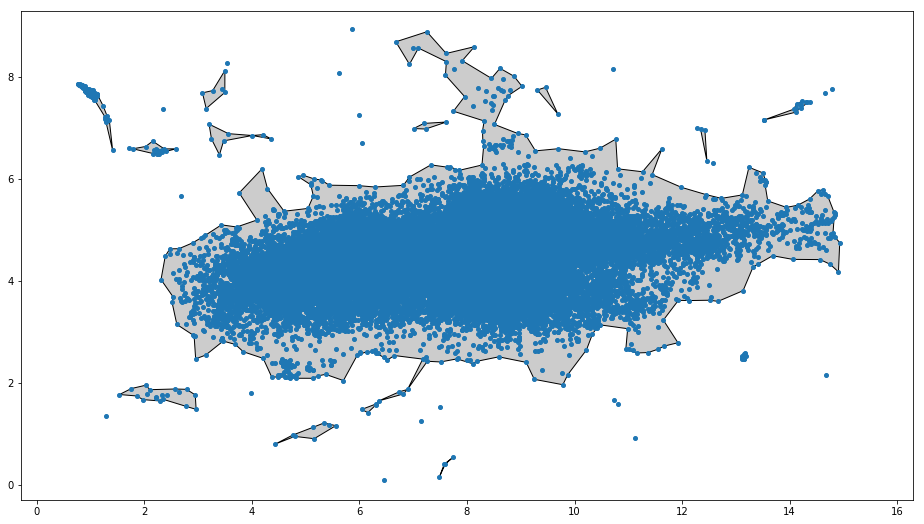

In [68]:
points = filter_data_by_label(*PersonActivity)[0]
scale(points, PersonActivity_range, Range2D(0, 0, canvas_width, canvas_height))
concave_hull, edge_points = alpha_shape(points,
                                        alpha=3.0)
# plot points and hull
_ = plot_polygon(concave_hull)
_ = plt.plot(points[:,0], points[:,1], 'o', markersize=4)

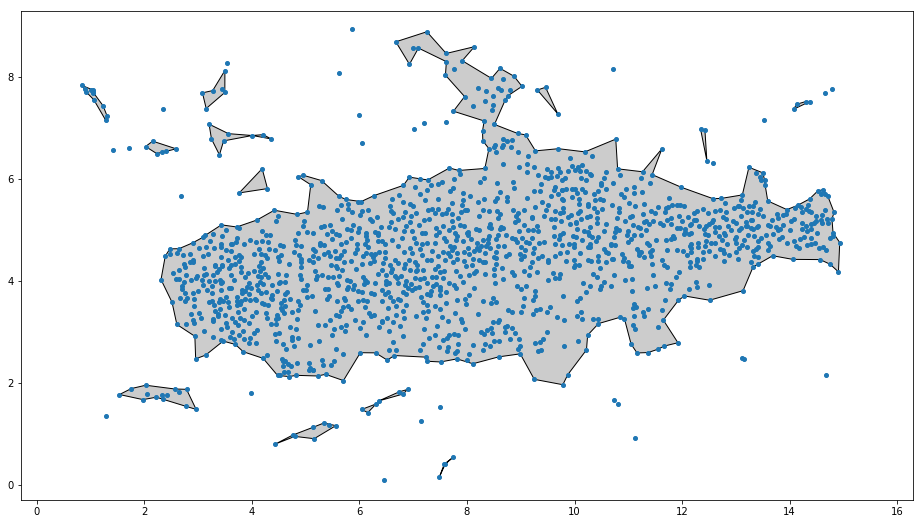

In [66]:
points = filter_data_by_label(*PersonActivity_result_our)[0]
scale(points, PersonActivity_range, Range2D(0, 0, canvas_width, canvas_height))
concave_hull, edge_points = alpha_shape(points,
                                        alpha=3.0)
# plot points and hull
_ = plot_polygon(concave_hull)
_ = plt.plot(points[:,0], points[:,1], 'o', markersize=4)

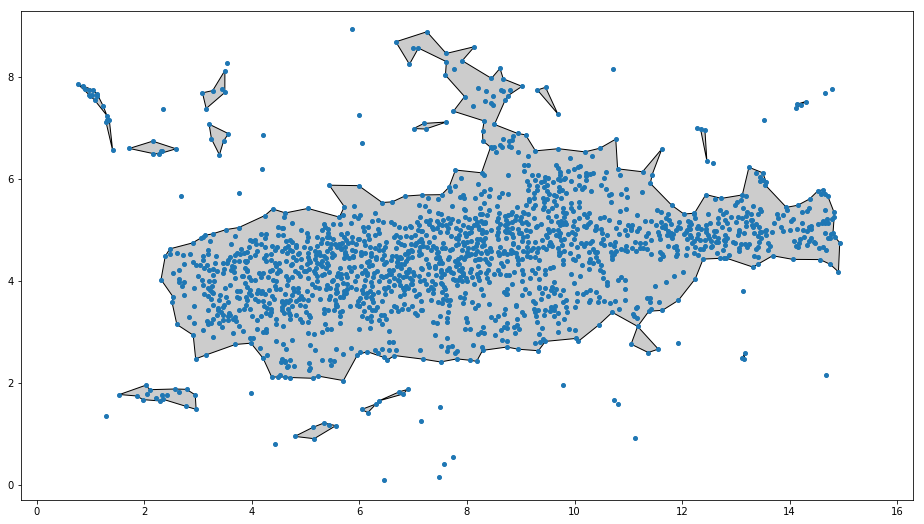

In [67]:
points = filter_data_by_label(*PersonActivity_result_non_uniform)[0]
scale(points, PersonActivity_range, Range2D(0, 0, canvas_width, canvas_height))
concave_hull, edge_points = alpha_shape(points,
                                        alpha=3.0)
# plot points and hull
_ = plot_polygon(concave_hull)
_ = plt.plot(points[:,0], points[:,1], 'o', markersize=4)

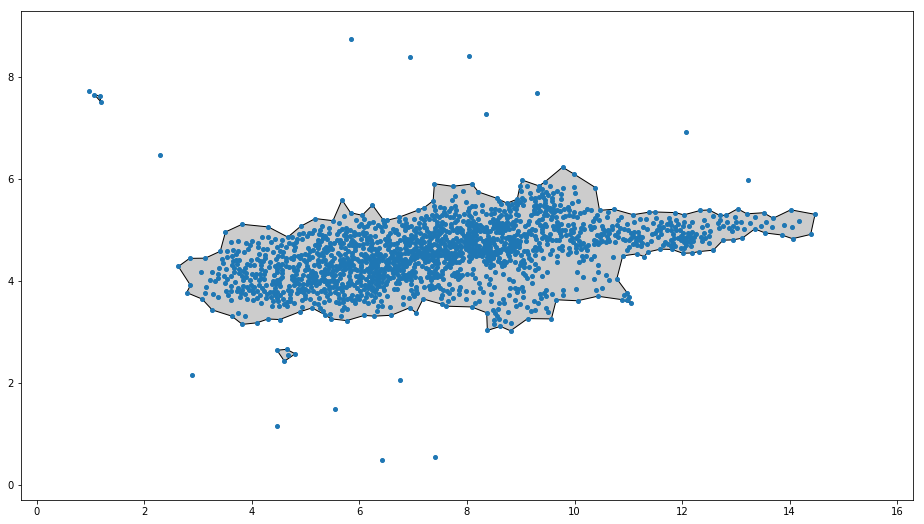

In [65]:
points = filter_data_by_label(*PersonActivity_result_weichen)[0]
scale(points, weichen_range, Range2D(0, 0, canvas_width, canvas_height))
concave_hull, edge_points = alpha_shape(points,
                                        alpha=4.0)
_ = plot_polygon(concave_hull)
_ = plt.plot(points[:,0], points[:,1], 'o', markersize=4)

In [4]:
canvas_width = 1600
canvas_height = 900

In [5]:
class SampleArea(object):
    def __init__(self):
        super().__init__()
        self.data_density = 0
        self.represented_density = defaultdict(int)
        self.class_points = defaultdict(int)
    
    def __repr__(self):
        return "["+str(self.data_density)+'\n'+str(self.represented_density)+"]"

grid_width, area_grid_ratio = 1, 40
area_width = grid_width*area_grid_ratio
area_size = area_grid_ratio**2
def construct_sample_areas(data, labels):
    sample_areas = dict()
    for i, p in enumerate(data):
        x, y = round(p[0])//area_width, round(p[1])//area_width
        abs_pos, rel_pos = (x,y), ((p[0]-x*area_width)//grid_width, (p[1]-y*area_width)//grid_width)
        if abs_pos not in sample_areas:
            sample_areas[abs_pos] = SampleArea()
        sample_areas[abs_pos].data_density += 1
        sample_areas[abs_pos].represented_density[rel_pos] += 1
        sample_areas[abs_pos].class_points[labels[i]] += 1
    return sample_areas

def get_sample_areas(data, data_range):
    xy, labels = filter_data_by_label(*data)
    scale(xy, data_range, Range2D(0, 0, canvas_width, canvas_height))
    #plt.figure(figsize=(5,5))
    plt.scatter(xy[:, 0], xy[:, 1], facecolor='black', s=1)
    plt.show()
    return construct_sample_areas(xy, labels)

In [6]:
# LDDr metric
delta = 0.32 # see the paper P18
def is_distorted_area(data_density, represented_density):
    return (data_density - len(represented_density.keys()))/data_density > delta

def diff(x, y):
    return 1 if x > y else -1 if x < y else 0

experiment_result = { 5:87, 8:81, 10:60, 20:45, 30:39, 40:27, 50:21, 60:22, 70:14, 80:10, 90:6 }
def minimum_delta(percentage):
    percentage *= 100
    if(percentage<5):
        return 100
    x_values = list(experiment_result.keys())
    for i,x in enumerate(x_values):
        if x > percentage:
            break
    return ((x-percentage)*experiment_result[x_values[i-1]]+(percentage-x_values[i-1])*experiment_result[x])/(x-x_values[i-1])/100

def p_diff(x, y):
    return 1 if x >= y+y*minimum_delta(y/area_size) else -1 if y >= x+x*minimum_delta(x/area_size) else 0

def lddr(sample_areas, match):
    couples, sum_ = 0, 0
    dsa = filter(lambda x: is_distorted_area(x.data_density, x.represented_density), sample_areas.values())
    pt = lambda a: a.data_density
    for a, b in combinations(dsa, 2):
        couples += pt(a) + pt(b)
        if not match(a, b):
            sum_ += pt(a) + pt(b)
    return 0 if couples == 0 else sum_/couples

In [13]:
# PPr(Points Pixels ratio)
def ppr(sample_areas):
    n = sum(sa.data_density for sa in sample_areas.values())
    return n/((canvas_width//grid_width+1)*(canvas_height//grid_width+1))

# CPr(Collisions Points ratio)
def cpr(sample_areas):
    k = sum(sa.data_density - len(sa.represented_density.keys()) for sa in sample_areas.values())
    n = sum(sa.data_density for sa in sample_areas.values())
    return k/n

# BGSAr(Bad Good SA ratio)
def bgsar(sample_areas):
    sa_num = (canvas_width//area_width+1)*(canvas_height//area_width+1)
    dsa = list(filter(lambda x: is_distorted_area(x.data_density, x.represented_density), sample_areas.values()))
    return len(dsa)/sa_num

# CPPr(Crowded Points Points ratio)
def cppr(sample_areas):
    n = sum(sa.data_density for sa in sample_areas.values())
    cp = sum(sa.data_density for sa in filter(lambda x: is_distorted_area(x.data_density, x.represented_density), sample_areas.values()))
    return cp/n

# ESAr (Erased SAs ratio)
def esar(sample_areas, sample_areas_after):
    esa_num = len(sample_areas.keys())-len(sample_areas_after.keys())
    sa_num = (canvas_width//area_width+1)*(canvas_height//area_width+1)
    #print(esa_num)
    return esa_num/sa_num

In [7]:
# RDMr (Represented Density Modified ratio) *not in the paper*
def rdmr(sample_areas, sample_areas_after):
    before_represented_density = sum(len(sa.represented_density.keys()) for sa in sample_areas.values())
    after_represented_density = sum(len(sa.represented_density.keys()) for sa in sample_areas_after.values())
    return (before_represented_density - after_represented_density)/before_represented_density

# VASAr (Visual Altered SAs ratio) *not in the paper*
def vasar(sample_areas, sample_areas_after):
    vasa_num = sum(1 for k in sample_areas if k not in sample_areas_after or\
                   p_diff(len(sample_areas[k].represented_density.keys()), len(sample_areas_after[k].represented_density.keys())) != 0)
    sa_num = (canvas_width//area_width+1)*(canvas_height//area_width+1)
    return vasa_num/sa_num

def modified_lddr(origin_sa, result_sa):
    pt = lambda x: origin_sa[x].data_density
    def match(a, b):
        a_after = result_sa[a].data_density if a in result_sa else 0
        b_after = result_sa[b].data_density if b in result_sa else 0
        return diff(pt(a), pt(b)) == diff(a_after, b_after)
    couples, sum_ = 0, 0
    for a, b in combinations(origin_sa, 2):
        couples += pt(a) + pt(b)
        if not match(a,b):
            sum_ += pt(a) + pt(b)
    return 0 if couples == 0 else sum_/couples

def PDDr(origin_sa, result_sa):
    pt = lambda x: origin_sa[x].data_density
    def match(a, b):
        a_after = len(result_sa[a].represented_density.keys()) if a in result_sa else 0
        b_after = len(result_sa[b].represented_density.keys()) if b in result_sa else 0
        return diff(pt(a), pt(b)) == diff(a_after, b_after)
    couples, sum_ = 0, 0
    for a, b in combinations(origin_sa, 2):
        couples += pt(a) + pt(b)
        if match(a,b):
            sum_ += pt(a) + pt(b)
    return 0 if couples == 0 else sum_/couples

def PCDr(origin_sa, result_sa):
    def get_ordered_label(class_points):
        d = deepcopy(class_points)
        for lb in selected_labels:
            if lb not in d:
                d[lb] = 0
        return [b for a,b in sorted(zip(d.values(), d.keys()))]
    score_sum = 0
    for k in origin_sa:
        origin_order = get_ordered_label(origin_sa[k].class_points)
        result_order = get_ordered_label(result_sa[k].class_points if k in result_sa else dict())
        score = origin_sa[k].data_density*stats.spearmanr(result_order, origin_order)[0]
        #if score < 1:
            #print(origin_order, result_order, score)
        score_sum += score
    return score_sum/origin_point_num

def LC(origin_sa, result_sa):
    loss_class_degree = 0
    for k in origin_sa:
        result_dict = result_sa[k].class_points if k in result_sa else dict()
        if len(origin_sa[k].class_points) != len(result_dict):
            loss_class_degree += origin_sa[k].data_density*len(origin_sa[k].class_points.keys()-result_dict.keys())

    return loss_class_degree/origin_point_num

In [22]:
pddr_list = []
pcdr_list = []
lc_list = []
esar_list = []

In [10]:
selected_labels = {'walking', 'lying', 'lying down', 'on all fours'}
PersonActivity = read_file('./evaluation_data/PersonActivity/origin.csv')
PersonActivity_result_our = read_file('./evaluation_data/PersonActivity/6_7_002_003_4.csv')
PersonActivity_result_non_uniform = read_file('./evaluation_data/PersonActivity/PersonActivity2_result_non_uniform_8_4895.csv')
PersonActivity_result_random = read_file('./evaluation_data/PersonActivity/PersonActivity2_result_random_5000.csv')
PersonActivity_result_weichen = read_file('./evaluation_data/PersonActivity/PersonActivity2_result_dt5.0_omega520_2.csv')
PersonActivity_result_weichen[0][:, 1] *= -1
PersonActivity_range = Range2D(*np.amin(PersonActivity[0], axis=0), *np.amax(PersonActivity[0], axis=0))

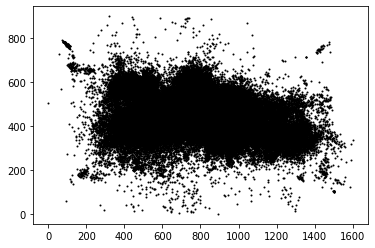

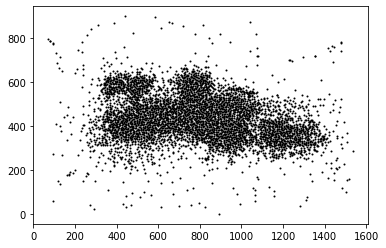

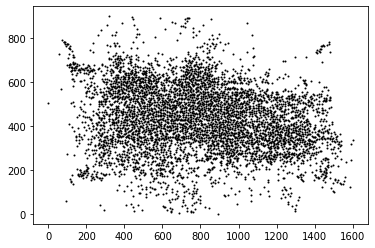

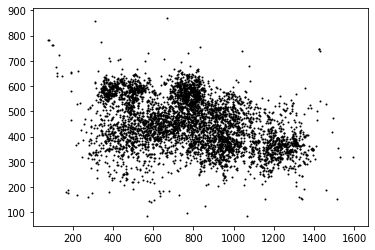

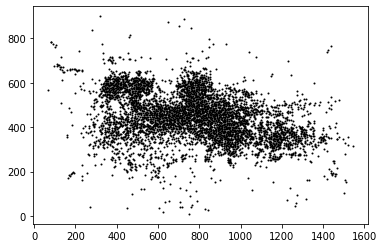

In [11]:
PersonActivity_sa = get_sample_areas(PersonActivity, PersonActivity_range)
PersonActivity_our_sa = get_sample_areas(PersonActivity_result_our, PersonActivity_range)
PersonActivity_non_uniform_sa = get_sample_areas(PersonActivity_result_non_uniform, PersonActivity_range)
PersonActivity_random_sa = get_sample_areas(PersonActivity_result_random, PersonActivity_range)
PersonActivity_weichen_sa = get_sample_areas(PersonActivity_result_weichen, PersonActivity_range)
origin_point_num = sum(map(lambda x: PersonActivity_sa[x].data_density, PersonActivity_sa))

In [20]:
pddr_list.append((PDDr(PersonActivity_sa, PersonActivity_our_sa), PDDr(PersonActivity_sa, PersonActivity_non_uniform_sa), 
                  PDDr(PersonActivity_sa, PersonActivity_random_sa), PDDr(PersonActivity_sa, PersonActivity_weichen_sa)))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][0], pddr_list[-1][1], pddr_list[-1][2], pddr_list[-1][3]))
pcdr_list.append((PCDr(PersonActivity_sa, abalone_our_sa), PCDr(PersonActivity_sa, abalone_non_uniform_sa), 
                  PCDr(PersonActivity_sa, abalone_random_sa), PCDr(PersonActivity_sa, abalone_weichen_sa)))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pcdr_list[-1][0], pcdr_list[-1][1], pcdr_list[-1][2], pcdr_list[-1][3]))
lc_list.append((LC(PersonActivity_sa, PersonActivity_our_sa), LC(PersonActivity_sa, PersonActivity_non_uniform_sa), 
                  LC(PersonActivity_sa, PersonActivity_random_sa), LC(PersonActivity_sa, PersonActivity_weichen_sa)))
print('%.4f, %.4f, %.4f, %.4f' % 
      (lc_list[-1][0], lc_list[-1][1], lc_list[-1][2], lc_list[-1][3]))
esar_list.append((esar(PersonActivity_sa, PersonActivity_our_sa), esar(PersonActivity_sa, PersonActivity_non_uniform_sa), 
                  esar(PersonActivity_sa, PersonActivity_random_sa), esar(PersonActivity_sa, PersonActivity_weichen_sa)))
print('%.4f, %.4f, %.4f, %.4f' % 
      (esar_list[-1][0], esar_list[-1][1], esar_list[-1][2], esar_list[-1][3]))

0.9274, 0.1580
0.8871, 0.0074
0.9568, 0.2831
0.9514, 0.2153


In [57]:
print('our PDDr:', PDDr(PersonActivity_sa, PersonActivity_our_sa))
print('non_uniform PDDr:', PDDr(PersonActivity_sa, PersonActivity_non_uniform_sa))
print('random PDDr:', PDDr(PersonActivity_sa, PersonActivity_random_sa))
print('weichen PDDr:', PDDr(PersonActivity_sa, PersonActivity_weichen_sa))

our PDDr: 0.9274933198491248
non_uniform PDDr: 0.8860205935752807
random PDDr: 0.9567645517411923
weichen PDDr: 0.9279712461446296


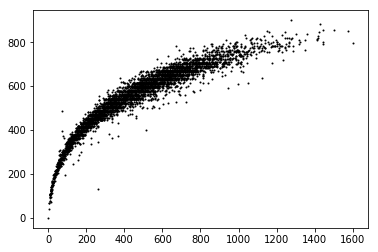

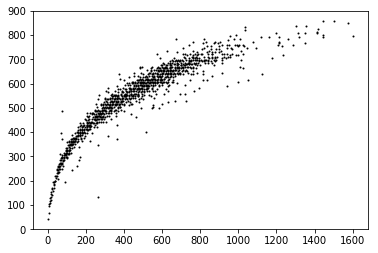

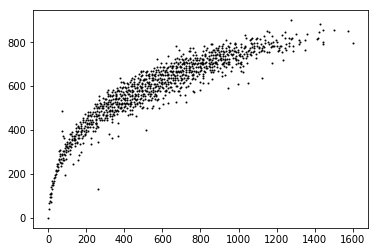

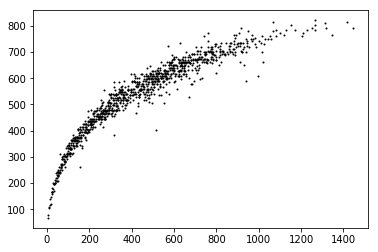

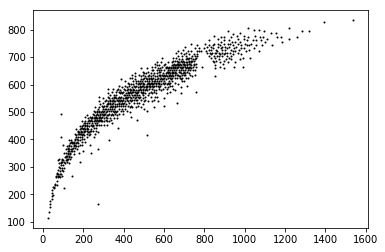

In [13]:
selected_labels = {'M', 'I', 'F'}
abalone = read_file('./evaluation_data/abalone/origin.csv')
abalone_result_our = read_file('./evaluation_data/abalone/6_6_002_002_4.csv')
abalone_result_non_uniform = read_file('./evaluation_data/abalone/6_11_8.csv')
abalone_result_random = read_file('./evaluation_data/abalone/6_1000.csv')
abalone_result_weichen = read_file('./evaluation_data/abalone/6_omega500_dt5.csv')
abalone_result_weichen[0][:, 1] *= -1
abalone_range = Range2D(*np.amin(abalone[0], axis=0), *np.amax(abalone[0], axis=0))
abalone_sa = get_sample_areas(abalone, abalone_range)
abalone_our_sa = get_sample_areas(abalone_result_our, abalone_range)
abalone_non_uniform_sa = get_sample_areas(abalone_result_non_uniform, abalone_range)
abalone_random_sa = get_sample_areas(abalone_result_random, abalone_range)
abalone_weichen_sa = get_sample_areas(abalone_result_weichen, weichen_range)
origin_point_num = sum(map(lambda x: abalone_sa[x].data_density, abalone_sa))

In [14]:
pddr_list.append((PDDr(abalone_sa, abalone_our_sa), PDDr(abalone_sa, abalone_non_uniform_sa), 
                  PDDr(abalone_sa, abalone_random_sa), PDDr(abalone_sa, abalone_weichen_sa)))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][0], pddr_list[-1][1], pddr_list[-1][2], pddr_list[-1][3]))
pcdr_list.append((PCDr(abalone_sa, abalone_our_sa), PCDr(abalone_sa, abalone_non_uniform_sa), 
                  PCDr(abalone_sa, abalone_random_sa), PCDr(abalone_sa, abalone_weichen_sa)))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pcdr_list[-1][0], pcdr_list[-1][1], pcdr_list[-1][2], pcdr_list[-1][3]))
lc_list.append((LC(abalone_sa, abalone_our_sa), LC(abalone_sa, abalone_non_uniform_sa), 
                  LC(abalone_sa, abalone_random_sa), LC(abalone_sa, abalone_weichen_sa)))
print('%.4f, %.4f, %.4f, %.4f' % 
      (lc_list[-1][0], lc_list[-1][1], lc_list[-1][2], lc_list[-1][3]))
esar_list.append((esar(abalone_sa, abalone_our_sa), esar(abalone_sa, abalone_non_uniform_sa), 
                  esar(abalone_sa, abalone_random_sa), esar(abalone_sa, abalone_weichen_sa)))
print('%.4f, %.4f, %.4f, %.4f' % 
      (esar_list[-1][0], esar_list[-1][1], esar_list[-1][2], esar_list[-1][3]))

0.9339, 0.8767, 0.9349, 0.9012
0.5376, 0.5034, 0.4191, 0.4756
0.1887, 0.4429, 0.2667, 0.4613
0.0286, 0.0032, 0.0647, 0.0541


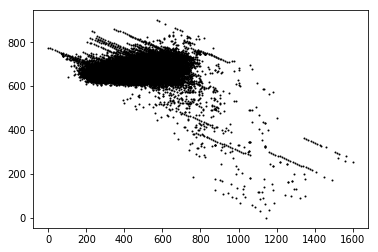

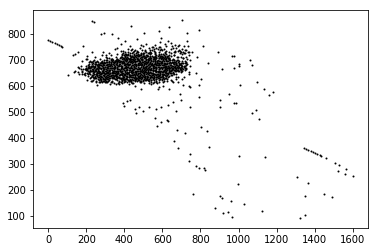

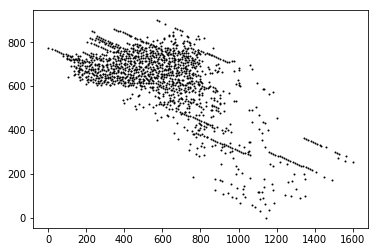

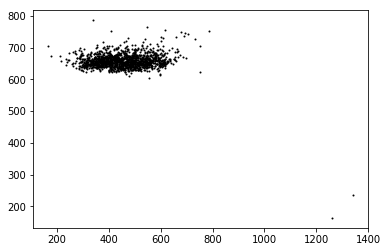

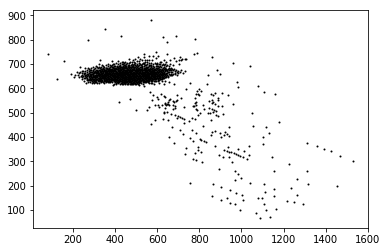

0.9633, 0.9965, 0.0292, 0.1230
0.9133, 0.9997, 0.8602, 0.0021
0.9872, 0.9821, 0.8590, 0.2492
0.9817, 0.9911, 0.8387, 0.1039


In [13]:
selected_labels = {0, 1}
CreditCardFaurd = read_file('./evaluation_data/CreditCardFaurd/origin.csv')
CreditCardFaurd_result_our = read_file('./evaluation_data/CreditCardFaurd/6_6_002_002_4.csv')
CreditCardFaurd_result_non_uniform = read_file('./evaluation_data/CreditCardFaurd/6_11_8.csv')
CreditCardFaurd_result_random = read_file('./evaluation_data/CreditCardFaurd/6_1400.csv')
CreditCardFaurd_result_weichen = read_file('./evaluation_data/CreditCardFaurd/6_omega360_dt5.csv')
CreditCardFaurd_result_weichen[0][:, 1] *= -1
CreditCardFaurd_range = Range2D(*np.amin(CreditCardFaurd[0], axis=0), *np.amax(CreditCardFaurd[0], axis=0))
CreditCardFaurd_sa = get_sample_areas(CreditCardFaurd, CreditCardFaurd_range)
CreditCardFaurd_our_sa = get_sample_areas(CreditCardFaurd_result_our, CreditCardFaurd_range)
CreditCardFaurd_non_uniform_sa = get_sample_areas(CreditCardFaurd_result_non_uniform, CreditCardFaurd_range)
CreditCardFaurd_random_sa = get_sample_areas(CreditCardFaurd_result_random, CreditCardFaurd_range)
CreditCardFaurd_weichen_sa = get_sample_areas(CreditCardFaurd_result_weichen, weichen_range)
origin_point_num = sum(map(lambda x: CreditCardFaurd_sa[x].data_density, CreditCardFaurd_sa))
pddr_list.append((PDDr(CreditCardFaurd_sa, CreditCardFaurd_our_sa), PDDr(CreditCardFaurd_sa, CreditCardFaurd_non_uniform_sa), 
      PDDr(CreditCardFaurd_sa, CreditCardFaurd_random_sa), PDDr(CreditCardFaurd_sa, CreditCardFaurd_weichen_sa)))
pcdr_list.append((PCDr(CreditCardFaurd_sa, CreditCardFaurd_our_sa), PCDr(CreditCardFaurd_sa, CreditCardFaurd_non_uniform_sa), 
      PCDr(CreditCardFaurd_sa, CreditCardFaurd_random_sa), PCDr(CreditCardFaurd_sa, CreditCardFaurd_weichen_sa)))
lc_list.append((LC(CreditCardFaurd_sa, CreditCardFaurd_our_sa), LC(CreditCardFaurd_sa, CreditCardFaurd_non_uniform_sa), 
      LC(CreditCardFaurd_sa, CreditCardFaurd_random_sa), LC(CreditCardFaurd_sa, CreditCardFaurd_weichen_sa)))
esar_list.append((esar(CreditCardFaurd_sa, CreditCardFaurd_our_sa), esar(CreditCardFaurd_sa, CreditCardFaurd_non_uniform_sa), 
      esar(CreditCardFaurd_sa, CreditCardFaurd_random_sa), esar(CreditCardFaurd_sa, CreditCardFaurd_weichen_sa)))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][0], pcdr_list[-1][0], lc_list[-1][0], esar_list[-1][0]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][1], pcdr_list[-1][1], lc_list[-1][1], esar_list[-1][1]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][2], pcdr_list[-1][2], lc_list[-1][2], esar_list[-1][2]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][3], pcdr_list[-1][3], lc_list[-1][3], esar_list[-1][3]))

In [16]:
pddr_list.append((PDDr(CreditCardFaurd_sa, CreditCardFaurd_our_sa), PDDr(CreditCardFaurd_sa, CreditCardFaurd_non_uniform_sa), 
      PDDr(CreditCardFaurd_sa, CreditCardFaurd_random_sa), PDDr(CreditCardFaurd_sa, CreditCardFaurd_weichen_sa)))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][0], pddr_list[-1][1], pddr_list[-1][2], pddr_list[-1][3]))
pcdr_list.append((PCDr(CreditCardFaurd_sa, CreditCardFaurd_our_sa), PCDr(CreditCardFaurd_sa, CreditCardFaurd_non_uniform_sa), 
      PCDr(CreditCardFaurd_sa, CreditCardFaurd_random_sa), PCDr(CreditCardFaurd_sa, CreditCardFaurd_weichen_sa)))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pcdr_list[-1][0], pcdr_list[-1][1], pcdr_list[-1][2], pcdr_list[-1][3]))
lc_list.append((LC(CreditCardFaurd_sa, CreditCardFaurd_our_sa), LC(CreditCardFaurd_sa, CreditCardFaurd_non_uniform_sa), 
      LC(CreditCardFaurd_sa, CreditCardFaurd_random_sa), LC(CreditCardFaurd_sa, CreditCardFaurd_weichen_sa)))
print('%.4f, %.4f, %.4f, %.4f' % 
      (lc_list[-1][0], lc_list[-1][1], lc_list[-1][2], lc_list[-1][3]))
esar_list.append((esar(CreditCardFaurd_sa, CreditCardFaurd_our_sa), esar(CreditCardFaurd_sa, CreditCardFaurd_non_uniform_sa), 
      esar(CreditCardFaurd_sa, CreditCardFaurd_random_sa), esar(CreditCardFaurd_sa, CreditCardFaurd_weichen_sa)))
print('%.4f, %.4f, %.4f, %.4f' % 
      (esar_list[-1][0], esar_list[-1][1], esar_list[-1][2], esar_list[-1][3]))

0.9633, 0.9133, 0.9872, 0.9817
0.9965, 0.9997, 0.9821, 0.9911
0.0292, 0.8602, 0.8590, 0.8387
0.1230, 0.0021, 0.2492, 0.1039


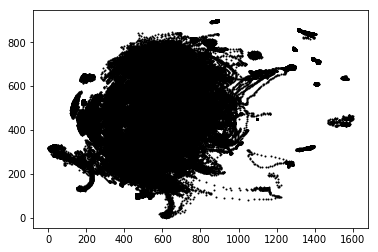

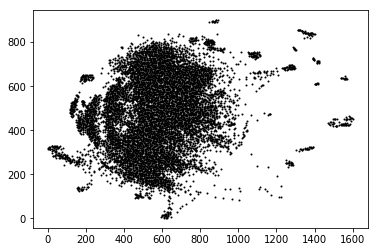

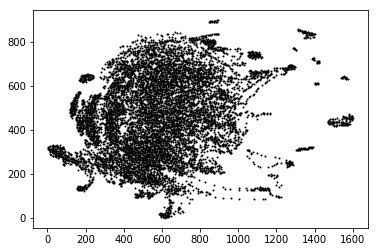

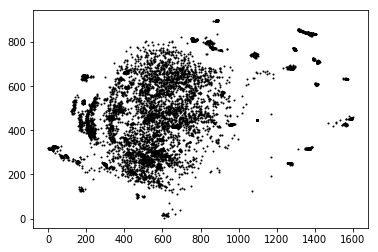

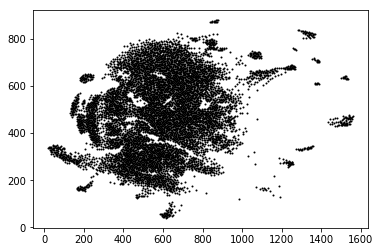

In [132]:
selected_labels = {'a01', 'a02', 'a03', 'a04', 'a05', 'a06', 'a07', 'a08', 'a09'}
DailySports = read_file('./evaluation_data/DailySports/origin.csv')
DailySports_result_our = read_file('./evaluation_data/DailySports/6_6_0022_004_4.csv')
DailySports_result_non_uniform = read_file('./evaluation_data/DailySports/6_6_8.csv')
DailySports_result_random = read_file('./evaluation_data/DailySports/6_8400.csv')
DailySports_result_weichen = read_file('./evaluation_data/DailySports/6_omega450_dt5_2.csv')
DailySports_result_weichen[0][:, 1] *= -1
DailySports_range = Range2D(*np.amin(DailySports[0], axis=0), *np.amax(DailySports[0], axis=0))
DailySports_sa = get_sample_areas(DailySports, DailySports_range)
DailySports_our_sa = get_sample_areas(DailySports_result_our, DailySports_range)
DailySports_non_uniform_sa = get_sample_areas(DailySports_result_non_uniform, DailySports_range)
DailySports_random_sa = get_sample_areas(DailySports_result_random, DailySports_range)
DailySports_weichen_sa = get_sample_areas(DailySports_result_weichen, weichen_range)
origin_point_num = sum(map(lambda x: DailySports_sa[x].data_density, DailySports_sa))

In [135]:
pddr_list.append((PDDr(DailySports_sa, DailySports_our_sa), PDDr(DailySports_sa, DailySports_non_uniform_sa), 
      PDDr(DailySports_sa, DailySports_random_sa), PDDr(DailySports_sa, DailySports_weichen_sa)))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][0], pddr_list[-1][3], pddr_list[-1][2], pddr_list[-1][3]))
pcdr_list.append((PCDr(DailySports_sa, DailySports_our_sa), PCDr(DailySports_sa, DailySports_non_uniform_sa), 
      PCDr(DailySports_sa, DailySports_random_sa), PCDr(DailySports_sa, DailySports_weichen_sa)))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pcdr_list[-1][0], pcdr_list[-1][3], pcdr_list[-1][2], pcdr_list[-1][3]))
lc_list.append((LC(DailySports_sa, DailySports_our_sa), LC(DailySports_sa, DailySports_non_uniform_sa), 
      LC(DailySports_sa, DailySports_random_sa), LC(DailySports_sa, DailySports_weichen_sa)))
print('%.4f, %.4f, %.4f, %.4f' % 
      (lc_list[-1][0], lc_list[-1][3], lc_list[-1][2], lc_list[-1][3]))
esar_list.append((esar(DailySports_sa, DailySports_our_sa), esar(DailySports_sa, DailySports_non_uniform_sa), 
      esar(DailySports_sa, DailySports_random_sa), esar(DailySports_sa, DailySports_weichen_sa)))
print('%.4f, %.4f, %.4f, %.4f' % 
      (esar_list[-1][0], esar_list[-1][3], esar_list[-1][2], esar_list[-1][3]))

0.7281, 0.6601, 0.9336, 0.6601
0.9061, 0.7960, 0.9490, 0.7960
0.1875, 0.7106, 0.5345, 0.7106
0.0445, 0.0912, 0.1347, 0.0912


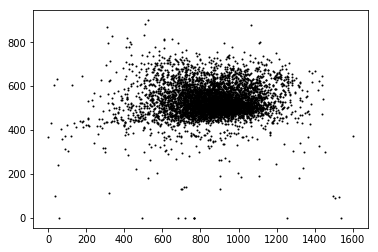

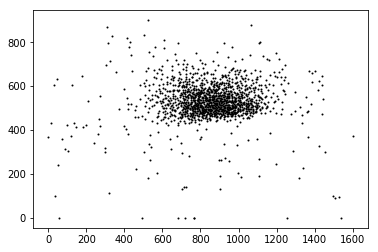

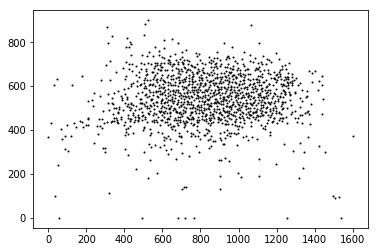

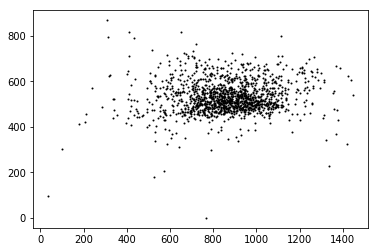

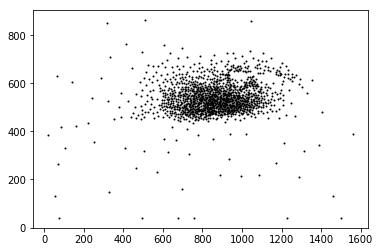

0.9197, 0.8766, 0.9322, 0.9231
0.6263, 0.5242, 0.5735, 0.4952
0.2687, 0.7031, 0.4947, 0.7720
0.1007, 0.0042, 0.1538, 0.1622


In [17]:
selected_labels = {'F', 'D', 'X'}
avila = read_file('./evaluation_data/avila/origin.csv')
avila_result_our = read_file('./evaluation_data/avila/6_6_002_002_4.csv')
avila_result_non_uniform = read_file('./evaluation_data/avila/6_13_8.csv')
avila_result_random = read_file('./evaluation_data/avila/6_1350.csv')
avila_result_weichen = read_file('./evaluation_data/avila/6_omega360_dt5.csv')
avila_result_weichen[0][:, 1] *= -1
avila_range = Range2D(*np.amin(avila[0], axis=0), *np.amax(avila[0], axis=0))
avila_sa = get_sample_areas(avila, avila_range)
avila_our_sa = get_sample_areas(avila_result_our, avila_range)
avila_non_uniform_sa = get_sample_areas(avila_result_non_uniform, avila_range)
avila_random_sa = get_sample_areas(avila_result_random, avila_range)
avila_weichen_sa = get_sample_areas(avila_result_weichen, weichen_range)
origin_point_num = sum(map(lambda x: avila_sa[x].data_density, avila_sa))
pddr_list.append((PDDr(avila_sa, avila_our_sa), PDDr(avila_sa, avila_non_uniform_sa), 
      PDDr(avila_sa, avila_random_sa), PDDr(avila_sa, avila_weichen_sa)))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][0], pddr_list[-1][1], pddr_list[-1][2], pddr_list[-1][3]))
pcdr_list.append((PCDr(avila_sa, avila_our_sa), PCDr(avila_sa, avila_non_uniform_sa), 
      PCDr(avila_sa, avila_random_sa), PCDr(avila_sa, avila_weichen_sa)))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pcdr_list[-1][0], pcdr_list[-1][1], pcdr_list[-1][2], pcdr_list[-1][3]))
lc_list.append((LC(avila_sa, avila_our_sa), LC(avila_sa, avila_non_uniform_sa), 
      LC(avila_sa, avila_random_sa), LC(avila_sa, avila_weichen_sa)))
print('%.4f, %.4f, %.4f, %.4f' % 
      (lc_list[-1][0], lc_list[-1][1], lc_list[-1][2], lc_list[-1][3]))
esar_list.append((esar(avila_sa, avila_our_sa), esar(avila_sa, avila_non_uniform_sa), 
      esar(avila_sa, avila_random_sa), esar(avila_sa, avila_weichen_sa)))
print('%.4f, %.4f, %.4f, %.4f' % 
      (esar_list[-1][0], esar_list[-1][1], esar_list[-1][2], esar_list[-1][3]))

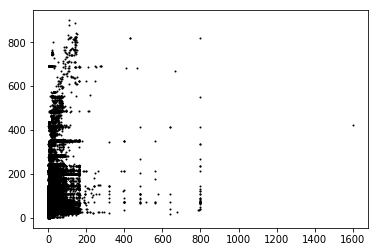

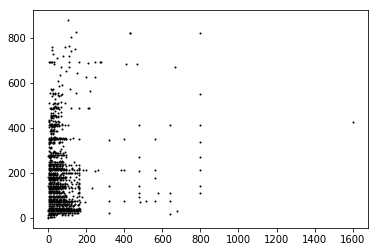

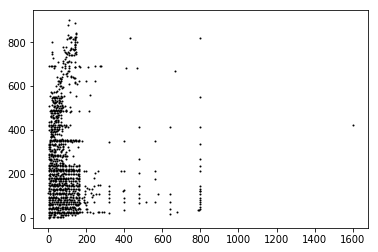

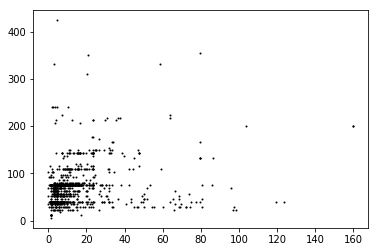

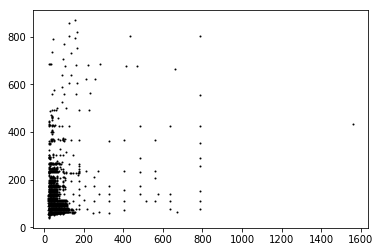

0.9755, 0.8867, 0.0055, 0.0329
0.9405, 0.6905, 0.7797, 0.0021
0.9938, 0.8894, 0.7557, 0.1336
0.8406, 0.4086, 1.0856, 0.0265


In [15]:
selected_labels = {'weekly', 'monthly', 'irregular', 'bullet'}
kiva_loans = read_file('./evaluation_data/kiva_loans/origin.csv')
kiva_loans_result_our = read_file('./evaluation_data/kiva_loans/6_6_006_002_4.csv')
kiva_loans_result_non_uniform = read_file('./evaluation_data/kiva_loans/6_8_8.csv')
kiva_loans_result_random = read_file('./evaluation_data/kiva_loans/6_1000.csv')
kiva_loans_result_weichen = read_file('./evaluation_data/kiva_loans/6_omega160_dt5.csv')
kiva_loans_result_weichen[0][:, 1] *= -1
kiva_loans_range = Range2D(*np.amin(kiva_loans[0], axis=0), *np.amax(kiva_loans[0], axis=0))
kiva_loans_sa = get_sample_areas(kiva_loans, kiva_loans_range)
kiva_loans_our_sa = get_sample_areas(kiva_loans_result_our, kiva_loans_range)
kiva_loans_non_uniform_sa = get_sample_areas(kiva_loans_result_non_uniform, kiva_loans_range)
kiva_loans_random_sa = get_sample_areas(kiva_loans_result_random, kiva_loans_range)
kiva_loans_weichen_sa = get_sample_areas(kiva_loans_result_weichen, weichen_range)
origin_point_num = sum(map(lambda x: kiva_loans_sa[x].data_density, kiva_loans_sa))
pddr_list.append((PDDr(kiva_loans_sa, kiva_loans_our_sa), PDDr(kiva_loans_sa, kiva_loans_non_uniform_sa), 
      PDDr(kiva_loans_sa, kiva_loans_random_sa), PDDr(kiva_loans_sa, kiva_loans_weichen_sa)))
pcdr_list.append((PCDr(kiva_loans_sa, kiva_loans_our_sa), PCDr(kiva_loans_sa, kiva_loans_non_uniform_sa), 
      PCDr(kiva_loans_sa, kiva_loans_random_sa), PCDr(kiva_loans_sa, kiva_loans_weichen_sa)))
lc_list.append((LC(kiva_loans_sa, kiva_loans_our_sa), LC(kiva_loans_sa, kiva_loans_non_uniform_sa), 
      LC(kiva_loans_sa, kiva_loans_random_sa), LC(kiva_loans_sa, kiva_loans_weichen_sa)))
esar_list.append((esar(kiva_loans_sa, kiva_loans_our_sa), esar(kiva_loans_sa, kiva_loans_non_uniform_sa), 
      esar(kiva_loans_sa, kiva_loans_random_sa), esar(kiva_loans_sa, kiva_loans_weichen_sa)))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][0], pcdr_list[-1][0], lc_list[-1][0], esar_list[-1][0]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][1], pcdr_list[-1][1], lc_list[-1][1], esar_list[-1][1]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][2], pcdr_list[-1][2], lc_list[-1][2], esar_list[-1][2]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][3], pcdr_list[-1][3], lc_list[-1][3], esar_list[-1][3]))

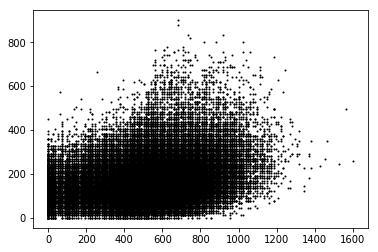

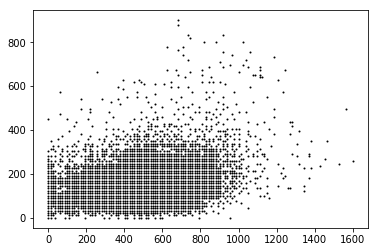

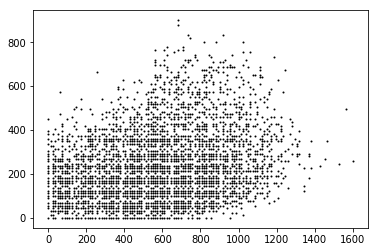

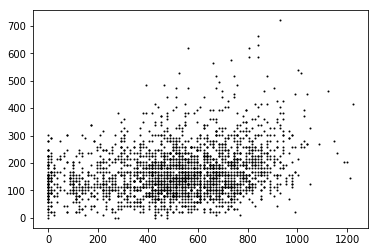

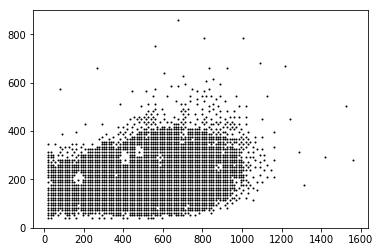

0.8551, 0.5294, 1.8512, 0.0965
0.8023, 0.5292, 2.7186, 0.0074
0.9115, 0.6540, 2.3487, 0.2662
0.7727, 0.6814, 2.7251, 0.2047


In [16]:
selected_labels = {'Asian', 'Caucasian', 'AfricanAmerican', 'Other', 'Hispanic'}
diabetes = read_file('./evaluation_data/diabetes/origin.csv')
diabetes_result_our = read_file('./evaluation_data/diabetes/6_6_0022_004_4.csv')
diabetes_result_non_uniform = read_file('./evaluation_data/diabetes/6_13_8.csv')
diabetes_result_random = read_file('./evaluation_data/diabetes/6_2400.csv')
diabetes_result_weichen = read_file('./evaluation_data/diabetes/6_omega600_dt5.csv')
diabetes_result_weichen[0][:, 1] *= -1
diabetes_range = Range2D(*np.amin(diabetes[0], axis=0), *np.amax(diabetes[0], axis=0))
diabetes_sa = get_sample_areas(diabetes, diabetes_range)
diabetes_our_sa = get_sample_areas(diabetes_result_our, diabetes_range)
diabetes_non_uniform_sa = get_sample_areas(diabetes_result_non_uniform, diabetes_range)
diabetes_random_sa = get_sample_areas(diabetes_result_random, diabetes_range)
diabetes_weichen_sa = get_sample_areas(diabetes_result_weichen, weichen_range)
origin_point_num = sum(map(lambda x: diabetes_sa[x].data_density, diabetes_sa))
pddr_list.append((PDDr(diabetes_sa, diabetes_our_sa), PDDr(diabetes_sa, diabetes_non_uniform_sa), 
      PDDr(diabetes_sa, diabetes_random_sa), PDDr(diabetes_sa, diabetes_weichen_sa)))
pcdr_list.append((PCDr(diabetes_sa, diabetes_our_sa), PCDr(diabetes_sa, diabetes_non_uniform_sa), 
      PCDr(diabetes_sa, diabetes_random_sa), PCDr(diabetes_sa, diabetes_weichen_sa)))
lc_list.append((LC(diabetes_sa, diabetes_our_sa), LC(diabetes_sa, diabetes_non_uniform_sa), 
      LC(diabetes_sa, diabetes_random_sa), LC(diabetes_sa, diabetes_weichen_sa)))
esar_list.append((esar(diabetes_sa, diabetes_our_sa), esar(diabetes_sa, diabetes_non_uniform_sa), 
      esar(diabetes_sa, diabetes_random_sa), esar(diabetes_sa, diabetes_weichen_sa)))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][0], pcdr_list[-1][0], lc_list[-1][0], esar_list[-1][0]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][1], pcdr_list[-1][1], lc_list[-1][1], esar_list[-1][1]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][2], pcdr_list[-1][2], lc_list[-1][2], esar_list[-1][2]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][3], pcdr_list[-1][3], lc_list[-1][3], esar_list[-1][3]))

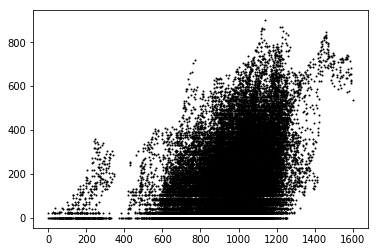

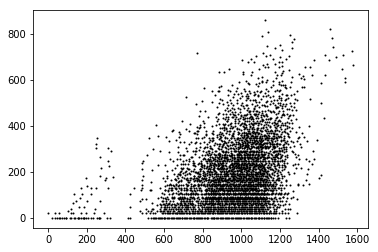

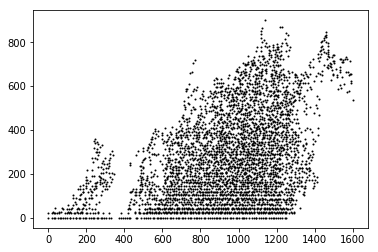

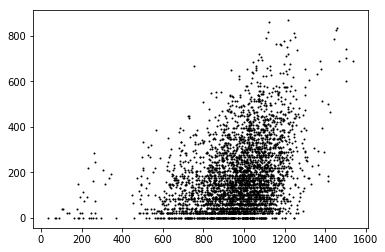

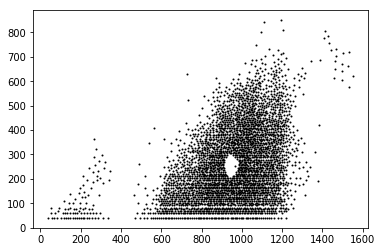

0.9355, 0.9004, 0.0639, 0.1071
0.8383, 0.9602, 0.3040, 0.0064
0.9465, 0.8978, 0.2779, 0.1421
0.7395, 0.6701, 0.5087, 0.1527


In [21]:
selected_labels = {5, 1, 7, 4}
forest_covertype = read_file('./evaluation_data/forest_covertype/origin.csv')
forest_covertype_result_our = read_file('./evaluation_data/forest_covertype/6_6_002_0_4.csv')
forest_covertype_result_non_uniform = read_file('./evaluation_data/forest_covertype/6_10_8.csv')
forest_covertype_result_random = read_file('./evaluation_data/forest_covertype/6_3500.csv')
forest_covertype_result_weichen = read_file('./evaluation_data/forest_covertype/6_omega530_dt5.csv')
forest_covertype_result_weichen[0][:, 1] *= -1
forest_covertype_range = Range2D(*np.amin(forest_covertype[0], axis=0), *np.amax(forest_covertype[0], axis=0))
forest_covertype_sa = get_sample_areas(forest_covertype, forest_covertype_range)
forest_covertype_our_sa = get_sample_areas(forest_covertype_result_our, forest_covertype_range)
forest_covertype_non_uniform_sa = get_sample_areas(forest_covertype_result_non_uniform, forest_covertype_range)
forest_covertype_random_sa = get_sample_areas(forest_covertype_result_random, forest_covertype_range)
forest_covertype_weichen_sa = get_sample_areas(forest_covertype_result_weichen, weichen_range)
origin_point_num = sum(map(lambda x: forest_covertype_sa[x].data_density, forest_covertype_sa))
pddr_list.append((PDDr(forest_covertype_sa, forest_covertype_our_sa), PDDr(forest_covertype_sa, forest_covertype_non_uniform_sa), 
      PDDr(forest_covertype_sa, forest_covertype_random_sa), PDDr(forest_covertype_sa, forest_covertype_weichen_sa)))
pcdr_list.append((PCDr(forest_covertype_sa, forest_covertype_our_sa), PCDr(forest_covertype_sa, forest_covertype_non_uniform_sa), 
      PCDr(forest_covertype_sa, forest_covertype_random_sa), PCDr(forest_covertype_sa, forest_covertype_weichen_sa)))
lc_list.append((LC(forest_covertype_sa, forest_covertype_our_sa), LC(forest_covertype_sa, forest_covertype_non_uniform_sa), 
      LC(forest_covertype_sa, forest_covertype_random_sa), LC(forest_covertype_sa, forest_covertype_weichen_sa)))
esar_list.append((esar(forest_covertype_sa, forest_covertype_our_sa), esar(forest_covertype_sa, forest_covertype_non_uniform_sa), 
      esar(forest_covertype_sa, forest_covertype_random_sa), esar(forest_covertype_sa, forest_covertype_weichen_sa)))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][0], pcdr_list[-1][0], lc_list[-1][0], esar_list[-1][0]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][1], pcdr_list[-1][1], lc_list[-1][1], esar_list[-1][1]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][2], pcdr_list[-1][2], lc_list[-1][2], esar_list[-1][2]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][3], pcdr_list[-1][3], lc_list[-1][3], esar_list[-1][3]))

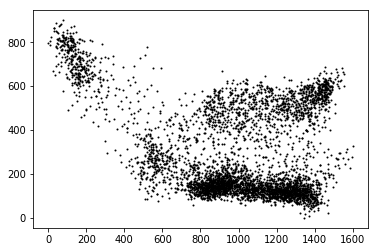

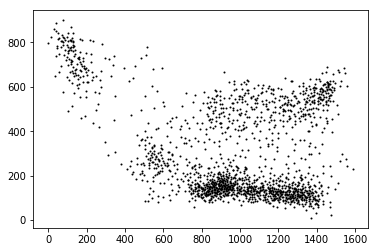

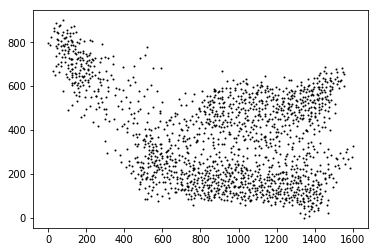

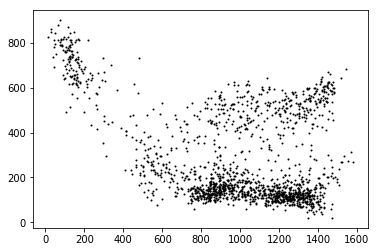

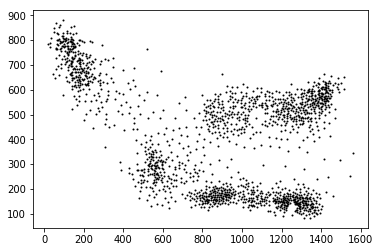

0.9021, 0.9291, 0.1339, 0.0774
0.8393, 0.9218, 0.4744, 0.0032
0.8706, 0.8918, 0.3637, 0.1283
0.7297, 0.8680, 0.9177, 0.1241


In [36]:
selected_labels = {3,4,5,7,2,1}
satimage = read_file('./evaluation_data/satimage/origin.csv')
satimage_result_our = read_file('./evaluation_data/satimage/6_6_002_002_4.csv')
satimage_result_non_uniform = read_file('./evaluation_data/satimage/6_15_8.csv')
satimage_result_random = read_file('./evaluation_data/satimage/6_1580.csv')
satimage_result_weichen = read_file('./evaluation_data/satimage/6_omega340_dt5.csv')
satimage_result_weichen[0][:, 1] *= -1
satimage_range = Range2D(*np.amin(satimage[0], axis=0), *np.amax(satimage[0], axis=0))
satimage_sa = get_sample_areas(satimage, satimage_range)
satimage_our_sa = get_sample_areas(satimage_result_our, satimage_range)
satimage_non_uniform_sa = get_sample_areas(satimage_result_non_uniform, satimage_range)
satimage_random_sa = get_sample_areas(satimage_result_random, satimage_range)
satimage_weichen_sa = get_sample_areas(satimage_result_weichen, weichen_range)
origin_point_num = sum(map(lambda x: satimage_sa[x].data_density, satimage_sa))
pddr_list.append((PDDr(satimage_sa, satimage_our_sa), PDDr(satimage_sa, satimage_non_uniform_sa), 
      PDDr(satimage_sa, satimage_random_sa), PDDr(satimage_sa, satimage_weichen_sa)))
pcdr_list.append((PCDr(satimage_sa, satimage_our_sa), PCDr(satimage_sa, satimage_non_uniform_sa), 
      PCDr(satimage_sa, satimage_random_sa), PCDr(satimage_sa, satimage_weichen_sa)))
lc_list.append((LC(satimage_sa, satimage_our_sa), LC(satimage_sa, satimage_non_uniform_sa), 
      LC(satimage_sa, satimage_random_sa), LC(satimage_sa, satimage_weichen_sa)))
esar_list.append((esar(satimage_sa, satimage_our_sa), esar(satimage_sa, satimage_non_uniform_sa), 
      esar(satimage_sa, satimage_random_sa), esar(satimage_sa, satimage_weichen_sa)))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][0], pcdr_list[-1][0], lc_list[-1][0], esar_list[-1][0]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][1], pcdr_list[-1][1], lc_list[-1][1], esar_list[-1][1]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][2], pcdr_list[-1][2], lc_list[-1][2], esar_list[-1][2]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][3], pcdr_list[-1][3], lc_list[-1][3], esar_list[-1][3]))

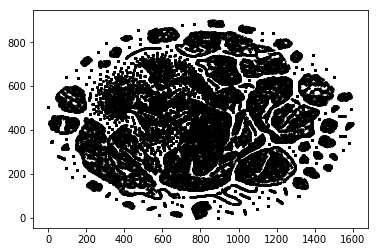

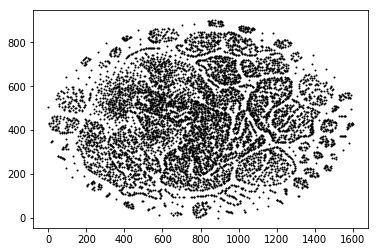

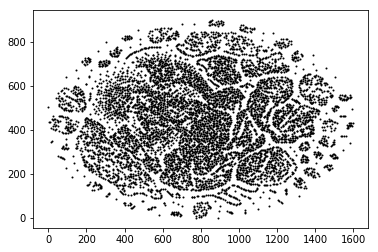

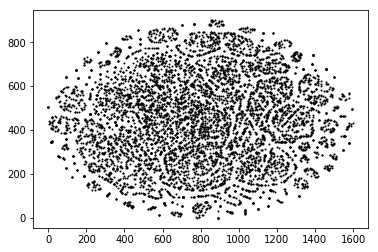

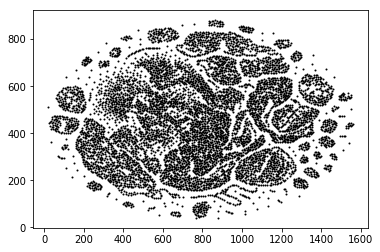

0.7953, 0.3859, 0.5283, 0.0074
0.7999, 0.4176, 0.7996, 0.0106
0.7377, 0.4569, 0.7432, 0.0095
0.6875, 0.2886, 1.1113, 0.0774


In [29]:
selected_labels = {'obama', 'microsoft', 'economy', 'palestine'}
NewsPopularity = read_file('./evaluation_data/NewsPopularity/origin.csv')
NewsPopularity_result_our = read_file('./evaluation_data/NewsPopularity/6_6_002_002_4.csv')
NewsPopularity_result_non_uniform = read_file('./evaluation_data/NewsPopularity/6_8_8.csv')
NewsPopularity_result_random = read_file('./evaluation_data/NewsPopularity/6_7500.csv')
NewsPopularity_result_weichen = read_file('./evaluation_data/NewsPopularity/6_omega520_dt5.csv')
NewsPopularity_result_weichen[0][:, 1] *= -1
NewsPopularity_range = Range2D(*np.amin(NewsPopularity[0], axis=0), *np.amax(NewsPopularity[0], axis=0))
NewsPopularity_sa = get_sample_areas(NewsPopularity, NewsPopularity_range)
NewsPopularity_our_sa = get_sample_areas(NewsPopularity_result_our, NewsPopularity_range)
NewsPopularity_non_uniform_sa = get_sample_areas(NewsPopularity_result_non_uniform, NewsPopularity_range)
NewsPopularity_random_sa = get_sample_areas(NewsPopularity_result_random, NewsPopularity_range)
NewsPopularity_weichen_sa = get_sample_areas(NewsPopularity_result_weichen, weichen_range)
origin_point_num = sum(map(lambda x: NewsPopularity_sa[x].data_density, NewsPopularity_sa))
pddr_list.append((PDDr(NewsPopularity_sa, NewsPopularity_our_sa), PDDr(NewsPopularity_sa, NewsPopularity_non_uniform_sa), 
      PDDr(NewsPopularity_sa, NewsPopularity_random_sa), PDDr(NewsPopularity_sa, NewsPopularity_weichen_sa)))
pcdr_list.append((PCDr(NewsPopularity_sa, NewsPopularity_our_sa), PCDr(NewsPopularity_sa, NewsPopularity_non_uniform_sa), 
      PCDr(NewsPopularity_sa, NewsPopularity_random_sa), PCDr(NewsPopularity_sa, NewsPopularity_weichen_sa)))
lc_list.append((LC(NewsPopularity_sa, NewsPopularity_our_sa), LC(NewsPopularity_sa, NewsPopularity_non_uniform_sa), 
      LC(NewsPopularity_sa, NewsPopularity_random_sa), LC(NewsPopularity_sa, NewsPopularity_weichen_sa)))
esar_list.append((esar(NewsPopularity_sa, NewsPopularity_our_sa), esar(NewsPopularity_sa, NewsPopularity_non_uniform_sa), 
      esar(NewsPopularity_sa, NewsPopularity_random_sa), esar(NewsPopularity_sa, NewsPopularity_weichen_sa)))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][0], pcdr_list[-1][0], lc_list[-1][0], esar_list[-1][0]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][1], pcdr_list[-1][1], lc_list[-1][1], esar_list[-1][1]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][2], pcdr_list[-1][2], lc_list[-1][2], esar_list[-1][2]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][3], pcdr_list[-1][3], lc_list[-1][3], esar_list[-1][3]))

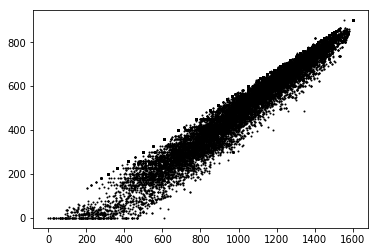

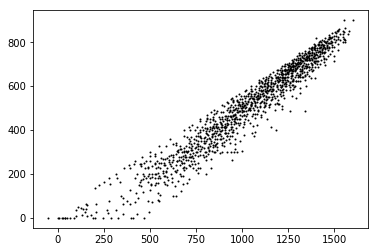

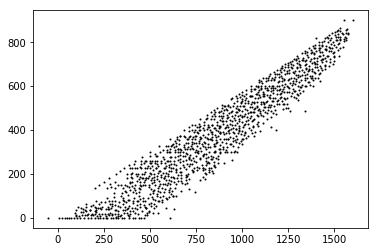

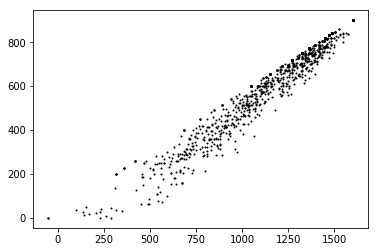

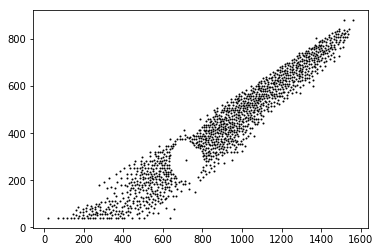

0.7772, 0.6601, 0.8006, 0.0339
0.5539, 0.7659, 1.2755, 0.0032
0.7685, 0.7149, 0.6887, 0.0848
0.6376, 0.6478, 1.3722, 0.0488


In [30]:
selected_labels = {'s', 'n', 'm'}
Nomao = read_file('./evaluation_data/Nomao/origin.csv')
Nomao_result_our = read_file('./evaluation_data/Nomao/6_6_002_002_4.csv')
Nomao_result_non_uniform = read_file('./evaluation_data/Nomao/6_14_8.csv')
Nomao_result_random = read_file('./evaluation_data/Nomao/6_1200.csv')
Nomao_result_weichen = read_file('./evaluation_data/Nomao/6_omega810_dt5.csv')
Nomao_result_weichen[0][:, 1] *= -1
Nomao_range = Range2D(*np.amin(Nomao[0], axis=0), *np.amax(Nomao[0], axis=0))
Nomao_sa = get_sample_areas(Nomao, Nomao_range)
Nomao_our_sa = get_sample_areas(Nomao_result_our, Nomao_range)
Nomao_non_uniform_sa = get_sample_areas(Nomao_result_non_uniform, Nomao_range)
Nomao_random_sa = get_sample_areas(Nomao_result_random, Nomao_range)
Nomao_weichen_sa = get_sample_areas(Nomao_result_weichen, weichen_range)
origin_point_num = sum(map(lambda x: Nomao_sa[x].data_density, Nomao_sa))
pddr_list.append((PDDr(Nomao_sa, Nomao_our_sa), PDDr(Nomao_sa, Nomao_non_uniform_sa), 
      PDDr(Nomao_sa, Nomao_random_sa), PDDr(Nomao_sa, Nomao_weichen_sa)))
pcdr_list.append((PCDr(Nomao_sa, Nomao_our_sa), PCDr(Nomao_sa, Nomao_non_uniform_sa), 
      PCDr(Nomao_sa, Nomao_random_sa), PCDr(Nomao_sa, Nomao_weichen_sa)))
lc_list.append((LC(Nomao_sa, Nomao_our_sa), LC(Nomao_sa, Nomao_non_uniform_sa), 
      LC(Nomao_sa, Nomao_random_sa), LC(Nomao_sa, Nomao_weichen_sa)))
esar_list.append((esar(Nomao_sa, Nomao_our_sa), esar(Nomao_sa, Nomao_non_uniform_sa), 
      esar(Nomao_sa, Nomao_random_sa), esar(Nomao_sa, Nomao_weichen_sa)))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][0], pcdr_list[-1][0], lc_list[-1][0], esar_list[-1][0]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][1], pcdr_list[-1][1], lc_list[-1][1], esar_list[-1][1]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][2], pcdr_list[-1][2], lc_list[-1][2], esar_list[-1][2]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][3], pcdr_list[-1][3], lc_list[-1][3], esar_list[-1][3]))

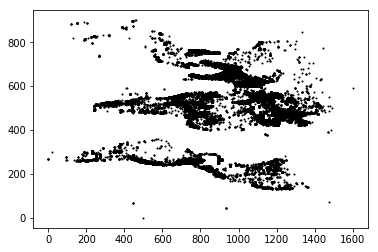

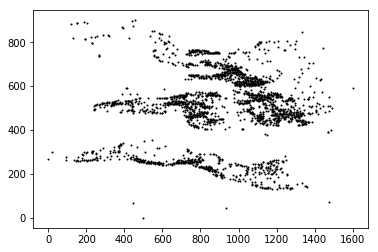

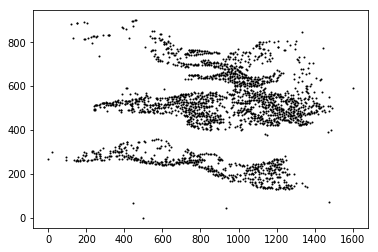

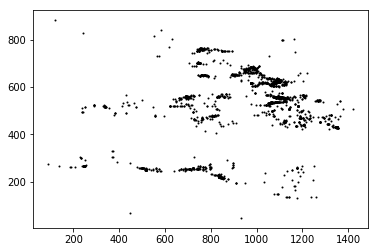

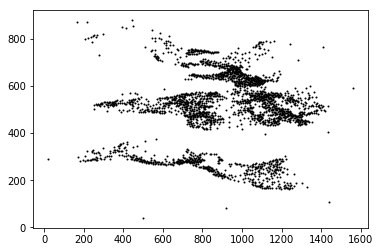

0.9125, 0.8192, 0.4753, 0.0318
0.8411, 0.7804, 1.2813, 0.0074
0.9476, 0.7797, 0.8780, 0.1792
0.7967, 0.4386, 1.1921, 0.0795


In [38]:
selected_labels = {1.0, 2.0, 3.0, 4.0}
terrorism = read_file('./evaluation_data/terrorism/origin.csv')
terrorism_result_our = read_file('./evaluation_data/terrorism/6_6_004_002_4.csv')
terrorism_result_non_uniform = read_file('./evaluation_data/terrorism/6_9_8.csv')
terrorism_result_random = read_file('./evaluation_data/terrorism/6_2230.csv')
terrorism_result_weichen = read_file('./evaluation_data/terrorism/6_omega450_dt5.csv')
terrorism_result_weichen[0][:, 1] *= -1
terrorism_range = Range2D(*np.amin(terrorism[0], axis=0), *np.amax(terrorism[0], axis=0))
terrorism_sa = get_sample_areas(terrorism, terrorism_range)
terrorism_our_sa = get_sample_areas(terrorism_result_our, terrorism_range)
terrorism_non_uniform_sa = get_sample_areas(terrorism_result_non_uniform, terrorism_range)
terrorism_random_sa = get_sample_areas(terrorism_result_random, terrorism_range)
terrorism_weichen_sa = get_sample_areas(terrorism_result_weichen, weichen_range)
origin_point_num = sum(map(lambda x: terrorism_sa[x].data_density, terrorism_sa))
pddr_list.append((PDDr(terrorism_sa, terrorism_our_sa), PDDr(terrorism_sa, terrorism_non_uniform_sa), 
      PDDr(terrorism_sa, terrorism_random_sa), PDDr(terrorism_sa, terrorism_weichen_sa)))
pcdr_list.append((PCDr(terrorism_sa, terrorism_our_sa), PCDr(terrorism_sa, terrorism_non_uniform_sa), 
      PCDr(terrorism_sa, terrorism_random_sa), PCDr(terrorism_sa, terrorism_weichen_sa)))
lc_list.append((LC(terrorism_sa, terrorism_our_sa), LC(terrorism_sa, terrorism_non_uniform_sa), 
      LC(terrorism_sa, terrorism_random_sa), LC(terrorism_sa, terrorism_weichen_sa)))
esar_list.append((esar(terrorism_sa, terrorism_our_sa), esar(terrorism_sa, terrorism_non_uniform_sa), 
      esar(terrorism_sa, terrorism_random_sa), esar(terrorism_sa, terrorism_weichen_sa)))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][0], pcdr_list[-1][0], lc_list[-1][0], esar_list[-1][0]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][1], pcdr_list[-1][1], lc_list[-1][1], esar_list[-1][1]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][2], pcdr_list[-1][2], lc_list[-1][2], esar_list[-1][2]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][3], pcdr_list[-1][3], lc_list[-1][3], esar_list[-1][3]))

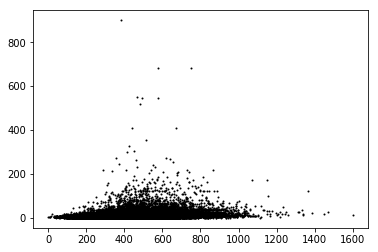

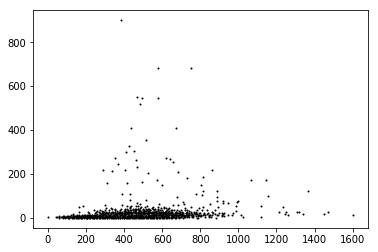

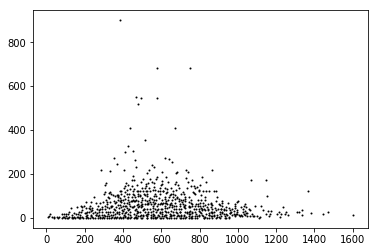

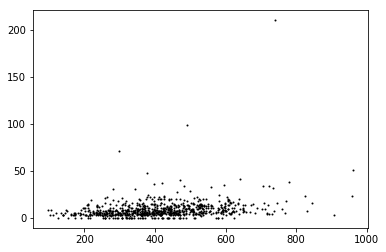

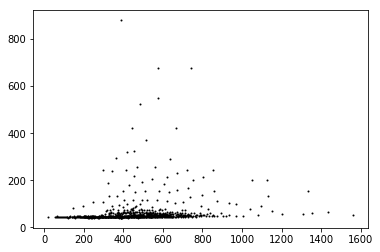

0.9655, 0.4843, 0.5281, 0.0392
0.9193, 0.4527, 2.1184, 0.0000
0.9855, 0.6674, 0.6821, 0.1145
0.0094, 0.4171, 5.9277, 0.0445


In [39]:
selected_labels = {'Italy', 'Portugal', 'US', 'Spain', 'Chile', 'France'}
wine = read_file('./evaluation_data/wine/origin.csv')
wine_result_our = read_file('./evaluation_data/wine/6_6_002_002_4.csv')
wine_result_non_uniform = read_file('./evaluation_data/wine/6_12_8.csv')
wine_result_random = read_file('./evaluation_data/wine/6_750.csv')
wine_result_weichen = read_file('./evaluation_data/wine/6_omega180_dt5.csv')
wine_result_weichen[0][:, 1] *= -1
wine_range = Range2D(*np.amin(wine[0], axis=0), *np.amax(wine[0], axis=0))
wine_sa = get_sample_areas(wine, wine_range)
wine_our_sa = get_sample_areas(wine_result_our, wine_range)
wine_non_uniform_sa = get_sample_areas(wine_result_non_uniform, wine_range)
wine_random_sa = get_sample_areas(wine_result_random, wine_range)
wine_weichen_sa = get_sample_areas(wine_result_weichen, weichen_range)
origin_point_num = sum(map(lambda x: wine_sa[x].data_density, wine_sa))
pddr_list.append((PDDr(wine_sa, wine_our_sa), PDDr(wine_sa, wine_non_uniform_sa), 
      PDDr(wine_sa, wine_random_sa), PDDr(wine_sa, wine_weichen_sa)))
pcdr_list.append((PCDr(wine_sa, wine_our_sa), PCDr(wine_sa, wine_non_uniform_sa), 
      PCDr(wine_sa, wine_random_sa), PCDr(wine_sa, wine_weichen_sa)))
lc_list.append((LC(wine_sa, wine_our_sa), LC(wine_sa, wine_non_uniform_sa), 
      LC(wine_sa, wine_random_sa), LC(wine_sa, wine_weichen_sa)))
esar_list.append((esar(wine_sa, wine_our_sa), esar(wine_sa, wine_non_uniform_sa), 
      esar(wine_sa, wine_random_sa), esar(wine_sa, wine_weichen_sa)))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][0], pcdr_list[-1][0], lc_list[-1][0], esar_list[-1][0]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][1], pcdr_list[-1][1], lc_list[-1][1], esar_list[-1][1]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][2], pcdr_list[-1][2], lc_list[-1][2], esar_list[-1][2]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][3], pcdr_list[-1][3], lc_list[-1][3], esar_list[-1][3]))

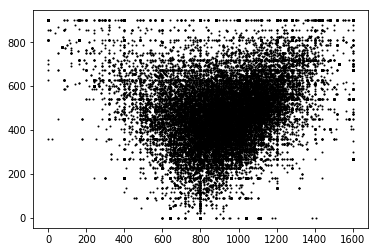

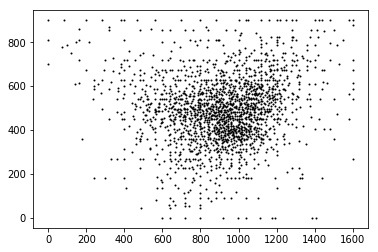

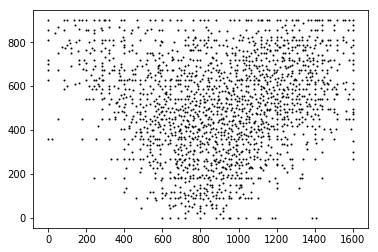

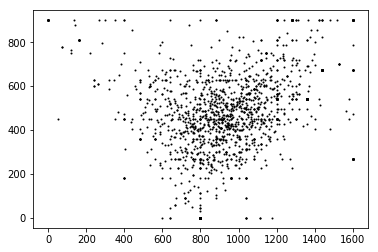

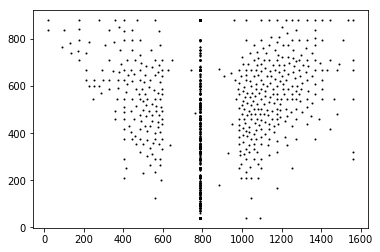

0.7533, 0.9719, 0.1854, 0.2206
0.6640, 0.9837, 0.0656, 0.0414
0.7736, 0.9418, 0.2319, 0.3457
0.3623, 0.7319, 0.7600, 0.4178


In [25]:
selected_labels = {'Negative', 'Positive', 'Neutral'}
google_sentiment = read_file('./evaluation_data/google_sentiment/origin.csv')
google_sentiment_result_our = read_file('./evaluation_data/google_sentiment/6_6_002_002_4.csv')
google_sentiment_result_non_uniform = read_file('./evaluation_data/google_sentiment/6_18_8.csv')
google_sentiment_result_random = read_file('./evaluation_data/google_sentiment/6_1700.csv')
google_sentiment_result_weichen = read_file('./evaluation_data/google_sentiment/6_omega1800_dt5.csv')
google_sentiment_result_weichen[0][:, 1] *= -1
google_sentiment_range = Range2D(*np.amin(google_sentiment[0], axis=0), *np.amax(google_sentiment[0], axis=0))
google_sentiment_sa = get_sample_areas(google_sentiment, google_sentiment_range)
google_sentiment_our_sa = get_sample_areas(google_sentiment_result_our, google_sentiment_range)
google_sentiment_non_uniform_sa = get_sample_areas(google_sentiment_result_non_uniform, google_sentiment_range)
google_sentiment_random_sa = get_sample_areas(google_sentiment_result_random, google_sentiment_range)
google_sentiment_weichen_sa = get_sample_areas(google_sentiment_result_weichen, weichen_range)
origin_point_num = sum(map(lambda x: google_sentiment_sa[x].data_density, google_sentiment_sa))
pddr_list.append((PDDr(google_sentiment_sa, google_sentiment_our_sa), PDDr(google_sentiment_sa, google_sentiment_non_uniform_sa), 
      PDDr(google_sentiment_sa, google_sentiment_random_sa), PDDr(google_sentiment_sa, google_sentiment_weichen_sa)))
pcdr_list.append((PCDr(google_sentiment_sa, google_sentiment_our_sa), PCDr(google_sentiment_sa, google_sentiment_non_uniform_sa), 
      PCDr(google_sentiment_sa, google_sentiment_random_sa), PCDr(google_sentiment_sa, google_sentiment_weichen_sa)))
lc_list.append((LC(google_sentiment_sa, google_sentiment_our_sa), LC(google_sentiment_sa, google_sentiment_non_uniform_sa), 
      LC(google_sentiment_sa, google_sentiment_random_sa), LC(google_sentiment_sa, google_sentiment_weichen_sa)))
esar_list.append((esar(google_sentiment_sa, google_sentiment_our_sa), esar(google_sentiment_sa, google_sentiment_non_uniform_sa), 
      esar(google_sentiment_sa, google_sentiment_random_sa), esar(google_sentiment_sa, google_sentiment_weichen_sa)))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][0], pcdr_list[-1][0], lc_list[-1][0], esar_list[-1][0]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][1], pcdr_list[-1][1], lc_list[-1][1], esar_list[-1][1]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][2], pcdr_list[-1][2], lc_list[-1][2], esar_list[-1][2]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][3], pcdr_list[-1][3], lc_list[-1][3], esar_list[-1][3]))

In [17]:
selected_labels = {'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3'}
PowerConsumption = read_file('./evaluation_data/PowerConsumption/origin.csv')
PowerConsumption_result_our = read_file('./evaluation_data/PowerConsumption/6_0.02_0.02_4.csv')
PowerConsumption_result_non_uniform = read_file('./evaluation_data/PowerConsumption/6_13_8.csv')
PowerConsumption_result_random = read_file('./evaluation_data/PowerConsumption/6_3000.csv')
PowerConsumption_result_weichen = read_file('./evaluation_data/PowerConsumption/6_omega520_dt5.csv')
PowerConsumption_result_weichen[0][:, 1] *= -1
PowerConsumption_range = Range2D(*np.amin(PowerConsumption[0], axis=0), *np.amax(PowerConsumption[0], axis=0))

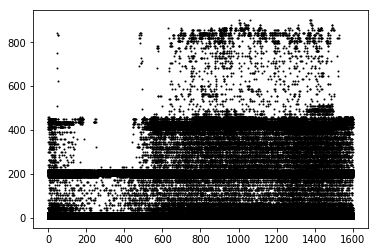

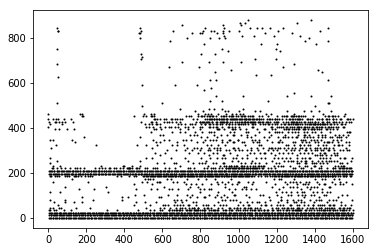

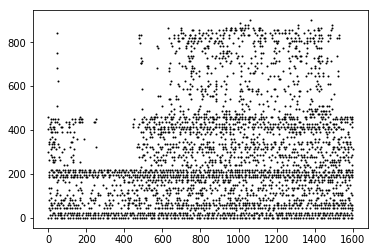

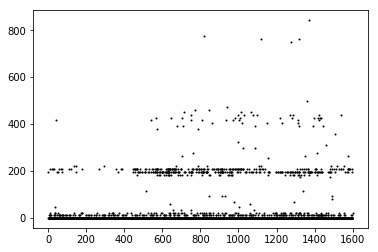

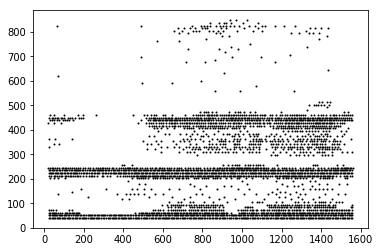

0.9528, 0.2507, 0.0886, 0.2174
0.8866, 0.2477, 0.4713, 0.0392
0.9524, 0.4746, 0.2532, 0.5620
0.0757, -0.5970, 2.8227, 0.3139


In [18]:
PowerConsumption_sa = get_sample_areas(PowerConsumption, PowerConsumption_range)
PowerConsumption_our_sa = get_sample_areas(PowerConsumption_result_our, PowerConsumption_range)
PowerConsumption_non_uniform_sa = get_sample_areas(PowerConsumption_result_non_uniform, PowerConsumption_range)
PowerConsumption_random_sa = get_sample_areas(PowerConsumption_result_random, PowerConsumption_range)
PowerConsumption_weichen_sa = get_sample_areas(PowerConsumption_result_weichen, weichen_range)
origin_point_num = sum(map(lambda x: PowerConsumption_sa[x].data_density, PowerConsumption_sa))
pddr_list.append((PDDr(PowerConsumption_sa, PowerConsumption_our_sa), PDDr(PowerConsumption_sa, PowerConsumption_non_uniform_sa), 
      PDDr(PowerConsumption_sa, PowerConsumption_random_sa), PDDr(PowerConsumption_sa, PowerConsumption_weichen_sa)))
pcdr_list.append((PCDr(PowerConsumption_sa, PowerConsumption_our_sa), PCDr(PowerConsumption_sa, PowerConsumption_non_uniform_sa), 
      PCDr(PowerConsumption_sa, PowerConsumption_random_sa), PCDr(PowerConsumption_sa, PowerConsumption_weichen_sa)))
lc_list.append((LC(PowerConsumption_sa, PowerConsumption_our_sa), LC(PowerConsumption_sa, PowerConsumption_non_uniform_sa), 
      LC(PowerConsumption_sa, PowerConsumption_random_sa), LC(PowerConsumption_sa, PowerConsumption_weichen_sa)))
esar_list.append((esar(PowerConsumption_sa, PowerConsumption_our_sa), esar(PowerConsumption_sa, PowerConsumption_non_uniform_sa), 
      esar(PowerConsumption_sa, PowerConsumption_random_sa), esar(PowerConsumption_sa, PowerConsumption_weichen_sa)))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][0], pcdr_list[-1][0], lc_list[-1][0], esar_list[-1][0]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][1], pcdr_list[-1][1], lc_list[-1][1], esar_list[-1][1]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][2], pcdr_list[-1][2], lc_list[-1][2], esar_list[-1][2]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][3], pcdr_list[-1][3], lc_list[-1][3], esar_list[-1][3]))

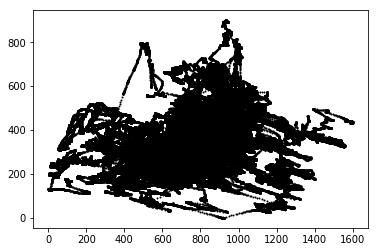

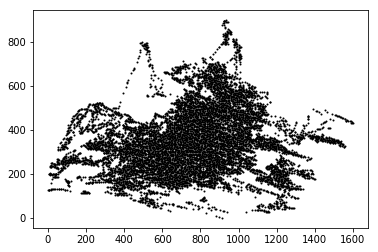

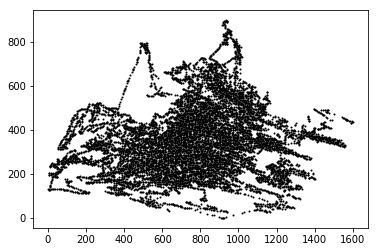

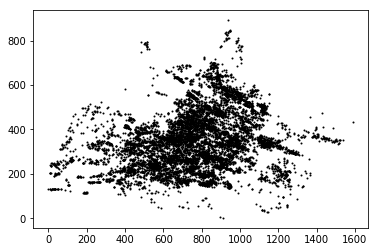

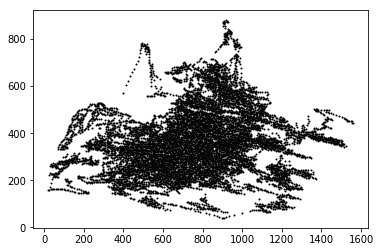

0.8743, 0.6847, 0.0495, 0.0265
0.9010, 0.7161, 0.1145, 0.0106
0.9573, 0.8536, 0.1781, 0.0997
0.8461, 0.4541, 0.2354, 0.0668


In [23]:
selected_labels = {'banana', 'wine', 'background'}
HT_sensor = read_file('./evaluation_data/HT_sensor/origin.csv')
HT_sensor_result_our = read_file('./evaluation_data/HT_sensor/6_6_002_002_4.csv')
HT_sensor_result_non_uniform = read_file('./evaluation_data/HT_sensor/6_6_8.csv')
HT_sensor_result_random = read_file('./evaluation_data/HT_sensor/6_9600.csv')
HT_sensor_result_weichen = read_file('./evaluation_data/HT_sensor/6_omega460_dt5.csv')
HT_sensor_result_weichen[0][:, 1] *= -1
HT_sensor_range = Range2D(*np.amin(HT_sensor[0], axis=0), *np.amax(HT_sensor[0], axis=0))
HT_sensor_sa = get_sample_areas(HT_sensor, HT_sensor_range)
HT_sensor_our_sa = get_sample_areas(HT_sensor_result_our, HT_sensor_range)
HT_sensor_non_uniform_sa = get_sample_areas(HT_sensor_result_non_uniform, HT_sensor_range)
HT_sensor_random_sa = get_sample_areas(HT_sensor_result_random, HT_sensor_range)
HT_sensor_weichen_sa = get_sample_areas(HT_sensor_result_weichen, weichen_range)
origin_point_num = sum(map(lambda x: HT_sensor_sa[x].data_density, HT_sensor_sa))
pddr_list.append((PDDr(HT_sensor_sa, HT_sensor_our_sa), PDDr(HT_sensor_sa, HT_sensor_non_uniform_sa), 
      PDDr(HT_sensor_sa, HT_sensor_random_sa), PDDr(HT_sensor_sa, HT_sensor_weichen_sa)))
pcdr_list.append((PCDr(HT_sensor_sa, HT_sensor_our_sa), PCDr(HT_sensor_sa, HT_sensor_non_uniform_sa), 
      PCDr(HT_sensor_sa, HT_sensor_random_sa), PCDr(HT_sensor_sa, HT_sensor_weichen_sa)))
lc_list.append((LC(HT_sensor_sa, HT_sensor_our_sa), LC(HT_sensor_sa, HT_sensor_non_uniform_sa), 
      LC(HT_sensor_sa, HT_sensor_random_sa), LC(HT_sensor_sa, HT_sensor_weichen_sa)))
esar_list.append((esar(HT_sensor_sa, HT_sensor_our_sa), esar(HT_sensor_sa, HT_sensor_non_uniform_sa), 
      esar(HT_sensor_sa, HT_sensor_random_sa), esar(HT_sensor_sa, HT_sensor_weichen_sa)))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][0], pcdr_list[-1][0], lc_list[-1][0], esar_list[-1][0]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][1], pcdr_list[-1][1], lc_list[-1][1], esar_list[-1][1]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][2], pcdr_list[-1][2], lc_list[-1][2], esar_list[-1][2]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][3], pcdr_list[-1][3], lc_list[-1][3], esar_list[-1][3]))

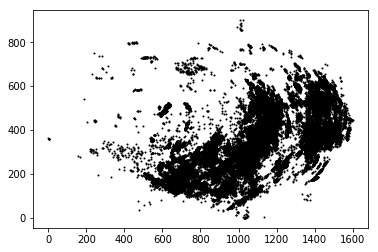

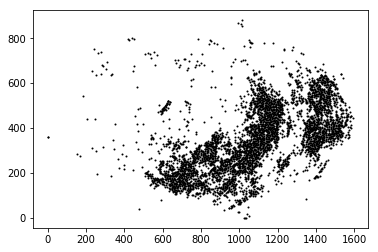

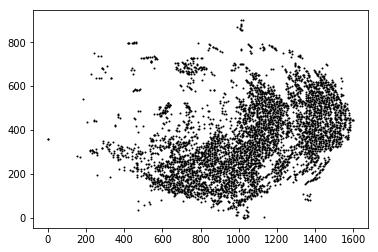

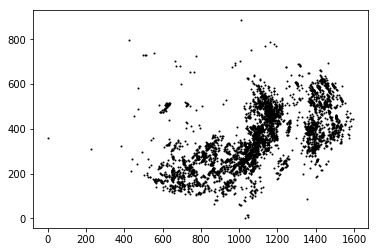

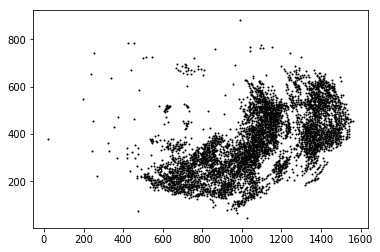

0.9417, 0.7160, 0.3596, 0.0795
0.9012, 0.6586, 0.6713, 0.0095
0.9608, 0.7346, 0.7334, 0.1898
0.8677, 0.4212, 0.9647, 0.1516


In [28]:
selected_labels = {1,2,3,4,5}
MoCap = read_file('./evaluation_data/MoCap/origin.csv')
MoCap_result_our = read_file('./evaluation_data/MoCap/6_6_004_002_4.csv')
MoCap_result_non_uniform = read_file('./evaluation_data/MoCap/6_8_8.csv')
MoCap_result_random = read_file('./evaluation_data/MoCap/6_4500.csv')
MoCap_result_weichen = read_file('./evaluation_data/MoCap/6_omega450_dt5.csv')
MoCap_result_weichen[0][:, 1] *= -1
MoCap_range = Range2D(*np.amin(MoCap[0], axis=0), *np.amax(MoCap[0], axis=0))
MoCap_sa = get_sample_areas(MoCap, MoCap_range)
MoCap_our_sa = get_sample_areas(MoCap_result_our, MoCap_range)
MoCap_non_uniform_sa = get_sample_areas(MoCap_result_non_uniform, MoCap_range)
MoCap_random_sa = get_sample_areas(MoCap_result_random, MoCap_range)
MoCap_weichen_sa = get_sample_areas(MoCap_result_weichen, weichen_range)
origin_point_num = sum(map(lambda x: MoCap_sa[x].data_density, MoCap_sa))
pddr_list.append((PDDr(MoCap_sa, MoCap_our_sa), PDDr(MoCap_sa, MoCap_non_uniform_sa), 
      PDDr(MoCap_sa, MoCap_random_sa), PDDr(MoCap_sa, MoCap_weichen_sa)))
pcdr_list.append((PCDr(MoCap_sa, MoCap_our_sa), PCDr(MoCap_sa, MoCap_non_uniform_sa), 
      PCDr(MoCap_sa, MoCap_random_sa), PCDr(MoCap_sa, MoCap_weichen_sa)))
lc_list.append((LC(MoCap_sa, MoCap_our_sa), LC(MoCap_sa, MoCap_non_uniform_sa), 
      LC(MoCap_sa, MoCap_random_sa), LC(MoCap_sa, MoCap_weichen_sa)))
esar_list.append((esar(MoCap_sa, MoCap_our_sa), esar(MoCap_sa, MoCap_non_uniform_sa), 
      esar(MoCap_sa, MoCap_random_sa), esar(MoCap_sa, MoCap_weichen_sa)))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][0], pcdr_list[-1][0], lc_list[-1][0], esar_list[-1][0]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][1], pcdr_list[-1][1], lc_list[-1][1], esar_list[-1][1]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][2], pcdr_list[-1][2], lc_list[-1][2], esar_list[-1][2]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][3], pcdr_list[-1][3], lc_list[-1][3], esar_list[-1][3]))

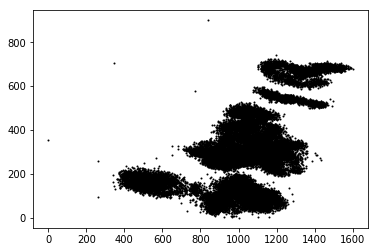

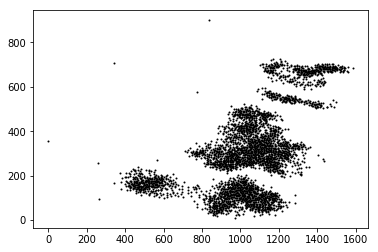

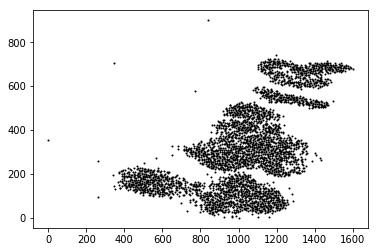

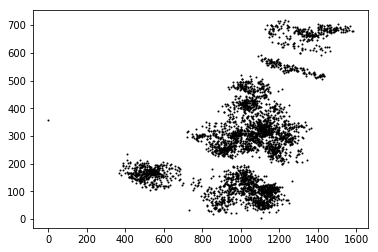

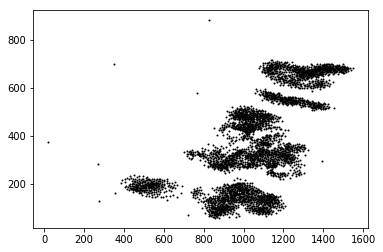

0.9444, 0.9882, 0.0788, 0.0361
0.8664, 0.9152, 0.2923, 0.0053
0.9431, 0.9232, 0.3037, 0.0721
0.7445, 0.8516, 0.5164, 0.0710


In [37]:
selected_labels = {1,3,4,5,7,8,9,10}
sensorless = read_file('./evaluation_data/sensorless/origin.csv')
sensorless_result_our = read_file('./evaluation_data/sensorless/6_6_002_002_4.csv')
sensorless_result_non_uniform = read_file('./evaluation_data/sensorless/6_8_8.csv')
sensorless_result_random = read_file('./evaluation_data/sensorless/6_3600.csv')
sensorless_result_weichen = read_file('./evaluation_data/sensorless/6_omega360_dt5.csv')
sensorless_result_weichen[0][:, 1] *= -1
sensorless_range = Range2D(*np.amin(sensorless[0], axis=0), *np.amax(sensorless[0], axis=0))
sensorless_sa = get_sample_areas(sensorless, sensorless_range)
sensorless_our_sa = get_sample_areas(sensorless_result_our, sensorless_range)
sensorless_non_uniform_sa = get_sample_areas(sensorless_result_non_uniform, sensorless_range)
sensorless_random_sa = get_sample_areas(sensorless_result_random, sensorless_range)
sensorless_weichen_sa = get_sample_areas(sensorless_result_weichen, weichen_range)
origin_point_num = sum(map(lambda x: sensorless_sa[x].data_density, sensorless_sa))
pddr_list.append((PDDr(sensorless_sa, sensorless_our_sa), PDDr(sensorless_sa, sensorless_non_uniform_sa), 
      PDDr(sensorless_sa, sensorless_random_sa), PDDr(sensorless_sa, sensorless_weichen_sa)))
pcdr_list.append((PCDr(sensorless_sa, sensorless_our_sa), PCDr(sensorless_sa, sensorless_non_uniform_sa), 
      PCDr(sensorless_sa, sensorless_random_sa), PCDr(sensorless_sa, sensorless_weichen_sa)))
lc_list.append((LC(sensorless_sa, sensorless_our_sa), LC(sensorless_sa, sensorless_non_uniform_sa), 
      LC(sensorless_sa, sensorless_random_sa), LC(sensorless_sa, sensorless_weichen_sa)))
esar_list.append((esar(sensorless_sa, sensorless_our_sa), esar(sensorless_sa, sensorless_non_uniform_sa), 
      esar(sensorless_sa, sensorless_random_sa), esar(sensorless_sa, sensorless_weichen_sa)))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][0], pcdr_list[-1][0], lc_list[-1][0], esar_list[-1][0]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][1], pcdr_list[-1][1], lc_list[-1][1], esar_list[-1][1]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][2], pcdr_list[-1][2], lc_list[-1][2], esar_list[-1][2]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][3], pcdr_list[-1][3], lc_list[-1][3], esar_list[-1][3]))

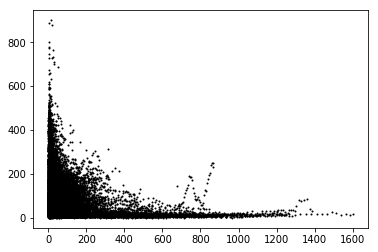

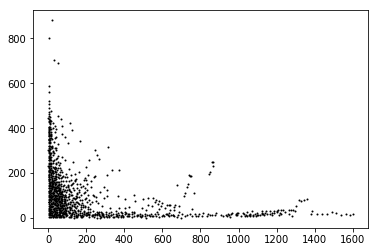

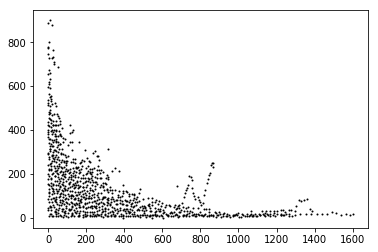

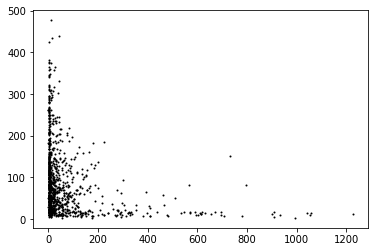

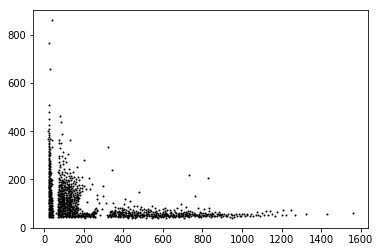

C:\Users\chenxin\Anaconda3\lib\site-packages\scipy\stats\stats.py:248: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


0.9673, 0.4677, 0.0915, 0.0318
0.8120, 0.5618, 0.5265, 0.0011
0.9716, 0.5130, 0.4274, 0.1029
0.5989, 0.0561, 1.4184, 0.0615


In [11]:
selected_labels = {'SE', 'NE', 'cv', 'NW'}
Beijing = read_file('./evaluation_data/Beijing/origin.csv')
Beijing_result_our = read_file('./evaluation_data/Beijing/6_6_003_002_4.csv')
Beijing_result_non_uniform = read_file('./evaluation_data/Beijing/6_12_8.csv')
Beijing_result_random = read_file('./evaluation_data/Beijing/6_1000.csv')
Beijing_result_weichen = read_file('./evaluation_data/Beijing/6_omega430_dt5.csv')
Beijing_result_weichen[0][:, 1] *= -1
Beijing_range = Range2D(*np.amin(Beijing[0], axis=0), *np.amax(Beijing[0], axis=0))
Beijing_sa = get_sample_areas(Beijing, Beijing_range)
Beijing_our_sa = get_sample_areas(Beijing_result_our, Beijing_range)
Beijing_non_uniform_sa = get_sample_areas(Beijing_result_non_uniform, Beijing_range)
Beijing_random_sa = get_sample_areas(Beijing_result_random, Beijing_range)
Beijing_weichen_sa = get_sample_areas(Beijing_result_weichen, weichen_range)
origin_point_num = sum(map(lambda x: Beijing_sa[x].data_density, Beijing_sa))
pddr_list.append((PDDr(Beijing_sa, Beijing_our_sa), PDDr(Beijing_sa, Beijing_non_uniform_sa), 
      PDDr(Beijing_sa, Beijing_random_sa), PDDr(Beijing_sa, Beijing_weichen_sa)))
pcdr_list.append((PCDr(Beijing_sa, Beijing_our_sa), PCDr(Beijing_sa, Beijing_non_uniform_sa), 
      PCDr(Beijing_sa, Beijing_random_sa), PCDr(Beijing_sa, Beijing_weichen_sa)))
lc_list.append((LC(Beijing_sa, Beijing_our_sa), LC(Beijing_sa, Beijing_non_uniform_sa), 
      LC(Beijing_sa, Beijing_random_sa), LC(Beijing_sa, Beijing_weichen_sa)))
esar_list.append((esar(Beijing_sa, Beijing_our_sa), esar(Beijing_sa, Beijing_non_uniform_sa), 
      esar(Beijing_sa, Beijing_random_sa), esar(Beijing_sa, Beijing_weichen_sa)))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][0], pcdr_list[-1][0], lc_list[-1][0], esar_list[-1][0]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][1], pcdr_list[-1][1], lc_list[-1][1], esar_list[-1][1]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][2], pcdr_list[-1][2], lc_list[-1][2], esar_list[-1][2]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][3], pcdr_list[-1][3], lc_list[-1][3], esar_list[-1][3]))

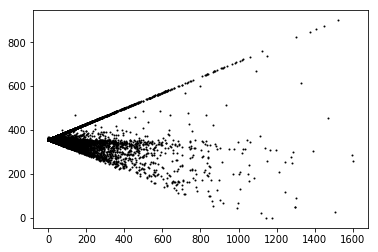

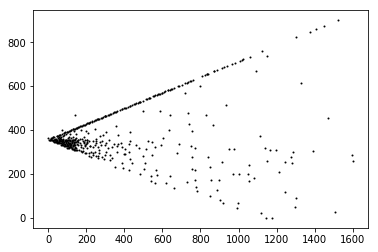

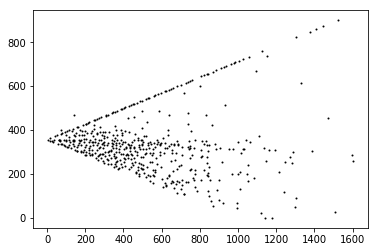

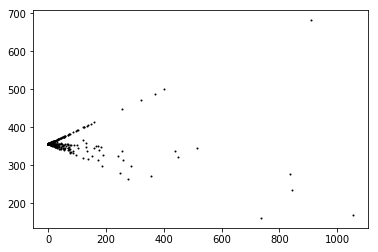

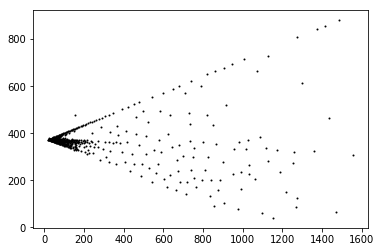

0.9647, 0.2918, 1.7648, 0.0498
0.7555, -0.2934, 3.2262, 0.0074
0.9656, 0.3998, 0.4659, 0.1803
0.2877, -0.4445, 5.1882, 0.0583


In [51]:
selected_labels = {6,5,1,2,4,3,0}
facebook = read_file('./evaluation_data/facebook/origin.csv')
facebook_result_our = read_file('./evaluation_data/facebook/6_6_006_002_4.csv')
facebook_result_non_uniform = read_file('./evaluation_data/facebook/6_15_8.csv')
facebook_result_random = read_file('./evaluation_data/facebook/6_500.csv')
facebook_result_weichen = read_file('./evaluation_data/facebook/6_omega180_dt5.csv')
facebook_result_weichen[0][:, 1] *= -1
facebook_range = Range2D(*np.amin(facebook[0], axis=0), *np.amax(facebook[0], axis=0))
facebook_sa = get_sample_areas(facebook, facebook_range)
facebook_our_sa = get_sample_areas(facebook_result_our, facebook_range)
facebook_non_uniform_sa = get_sample_areas(facebook_result_non_uniform, facebook_range)
facebook_random_sa = get_sample_areas(facebook_result_random, facebook_range)
facebook_weichen_sa = get_sample_areas(facebook_result_weichen, weichen_range)
origin_point_num = sum(map(lambda x: facebook_sa[x].data_density, facebook_sa))
pddr_list.append((PDDr(facebook_sa, facebook_our_sa), PDDr(facebook_sa, facebook_non_uniform_sa), 
      PDDr(facebook_sa, facebook_random_sa), PDDr(facebook_sa, facebook_weichen_sa)))
pcdr_list.append((PCDr(facebook_sa, facebook_our_sa), PCDr(facebook_sa, facebook_non_uniform_sa), 
      PCDr(facebook_sa, facebook_random_sa), PCDr(facebook_sa, facebook_weichen_sa)))
lc_list.append((LC(facebook_sa, facebook_our_sa), LC(facebook_sa, facebook_non_uniform_sa), 
      LC(facebook_sa, facebook_random_sa), LC(facebook_sa, facebook_weichen_sa)))
esar_list.append((esar(facebook_sa, facebook_our_sa), esar(facebook_sa, facebook_non_uniform_sa), 
      esar(facebook_sa, facebook_random_sa), esar(facebook_sa, facebook_weichen_sa)))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][0], pcdr_list[-1][0], lc_list[-1][0], esar_list[-1][0]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][1], pcdr_list[-1][1], lc_list[-1][1], esar_list[-1][1]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][2], pcdr_list[-1][2], lc_list[-1][2], esar_list[-1][2]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][3], pcdr_list[-1][3], lc_list[-1][3], esar_list[-1][3]))

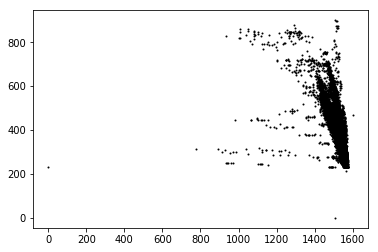

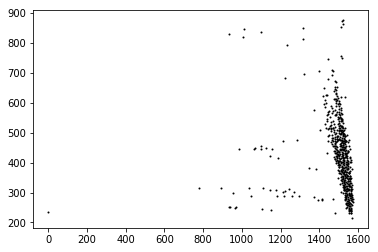

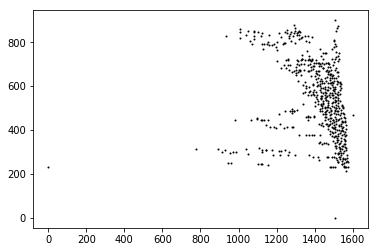

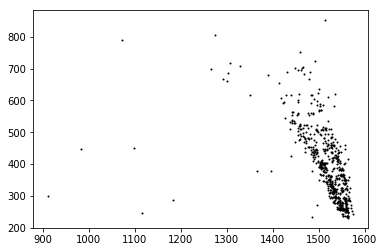

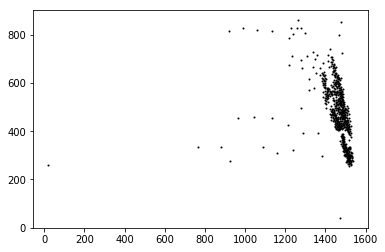

0.9522, 0.3468, 0.4340, 0.0647
0.8903, 0.1568, 1.6247, 0.0011
0.9681, 0.4874, 0.4592, 0.0933
0.7475, -0.1252, 2.1165, 0.0732


In [22]:
selected_labels = {1,2,3,4,5,6}
gas_sensor = read_file('./evaluation_data/gas_sensor/origin.csv')
gas_sensor_result_our = read_file('./evaluation_data/gas_sensor/6_6_002_002_4.csv')
gas_sensor_result_non_uniform = read_file('./evaluation_data/gas_sensor/6_12_8.csv')
gas_sensor_result_random = read_file('./evaluation_data/gas_sensor/6_600.csv')
gas_sensor_result_weichen = read_file('./evaluation_data/gas_sensor/6_omega360_dt5.csv')
gas_sensor_result_weichen[0][:, 1] *= -1
gas_sensor_range = Range2D(*np.amin(gas_sensor[0], axis=0), *np.amax(gas_sensor[0], axis=0))
gas_sensor_sa = get_sample_areas(gas_sensor, gas_sensor_range)
gas_sensor_our_sa = get_sample_areas(gas_sensor_result_our, gas_sensor_range)
gas_sensor_non_uniform_sa = get_sample_areas(gas_sensor_result_non_uniform, gas_sensor_range)
gas_sensor_random_sa = get_sample_areas(gas_sensor_result_random, gas_sensor_range)
gas_sensor_weichen_sa = get_sample_areas(gas_sensor_result_weichen, weichen_range)
origin_point_num = sum(map(lambda x: gas_sensor_sa[x].data_density, gas_sensor_sa))
pddr_list.append((PDDr(gas_sensor_sa, gas_sensor_our_sa), PDDr(gas_sensor_sa, gas_sensor_non_uniform_sa), 
      PDDr(gas_sensor_sa, gas_sensor_random_sa), PDDr(gas_sensor_sa, gas_sensor_weichen_sa)))
pcdr_list.append((PCDr(gas_sensor_sa, gas_sensor_our_sa), PCDr(gas_sensor_sa, gas_sensor_non_uniform_sa), 
      PCDr(gas_sensor_sa, gas_sensor_random_sa), PCDr(gas_sensor_sa, gas_sensor_weichen_sa)))
lc_list.append((LC(gas_sensor_sa, gas_sensor_our_sa), LC(gas_sensor_sa, gas_sensor_non_uniform_sa), 
      LC(gas_sensor_sa, gas_sensor_random_sa), LC(gas_sensor_sa, gas_sensor_weichen_sa)))
esar_list.append((esar(gas_sensor_sa, gas_sensor_our_sa), esar(gas_sensor_sa, gas_sensor_non_uniform_sa), 
      esar(gas_sensor_sa, gas_sensor_random_sa), esar(gas_sensor_sa, gas_sensor_weichen_sa)))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][0], pcdr_list[-1][0], lc_list[-1][0], esar_list[-1][0]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][1], pcdr_list[-1][1], lc_list[-1][1], esar_list[-1][1]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][2], pcdr_list[-1][2], lc_list[-1][2], esar_list[-1][2]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][3], pcdr_list[-1][3], lc_list[-1][3], esar_list[-1][3]))

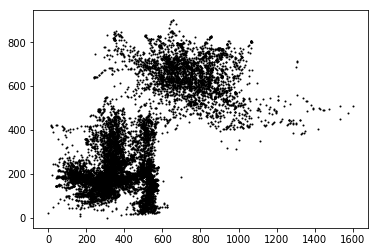

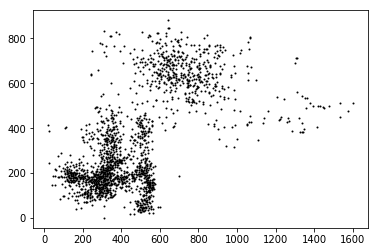

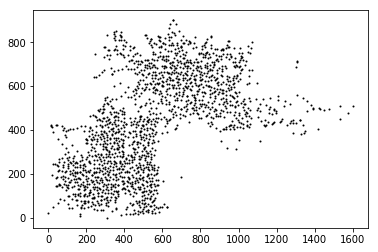

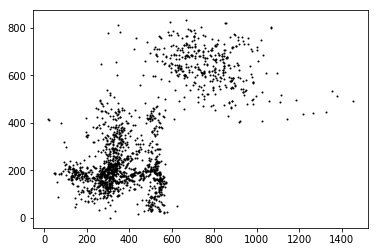

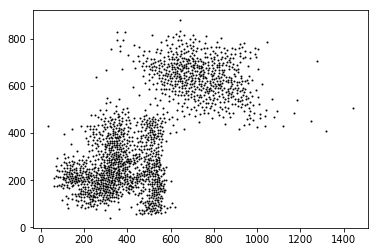

0.9302, 0.6845, 0.4786, 0.0891
0.7976, 0.5834, 0.6105, 0.0042
0.9114, 0.6943, 0.6271, 0.1569
0.8700, 0.5317, 0.5763, 0.1082


In [26]:
selected_labels = {'1200 - 1210', '1210 - 1220', '1220 - 1230'}
facial = read_file('./evaluation_data/facial/origin.csv')
facial_result_our = read_file('./evaluation_data/facial/6_6_002_002_4.csv')
facial_result_non_uniform = read_file('./evaluation_data/facial/6_14_8.csv')
facial_result_random = read_file('./evaluation_data/facial/6_1700.csv')
facial_result_weichen = read_file('./evaluation_data/facial/6_omega680_dt5.csv')
facial_result_weichen[0][:, 1] *= -1
facial_range = Range2D(*np.amin(facial[0], axis=0), *np.amax(facial[0], axis=0))
facial_sa = get_sample_areas(facial, facial_range)
facial_our_sa = get_sample_areas(facial_result_our, facial_range)
facial_non_uniform_sa = get_sample_areas(facial_result_non_uniform, facial_range)
facial_random_sa = get_sample_areas(facial_result_random, facial_range)
facial_weichen_sa = get_sample_areas(facial_result_weichen, weichen_range)
origin_point_num = sum(map(lambda x: facial_sa[x].data_density, facial_sa))
pddr_list.append((PDDr(facial_sa, facial_our_sa), PDDr(facial_sa, facial_non_uniform_sa), 
      PDDr(facial_sa, facial_random_sa), PDDr(facial_sa, facial_weichen_sa)))
pcdr_list.append((PCDr(facial_sa, facial_our_sa), PCDr(facial_sa, facial_non_uniform_sa), 
      PCDr(facial_sa, facial_random_sa), PCDr(facial_sa, facial_weichen_sa)))
lc_list.append((LC(facial_sa, facial_our_sa), LC(facial_sa, facial_non_uniform_sa), 
      LC(facial_sa, facial_random_sa), LC(facial_sa, facial_weichen_sa)))
esar_list.append((esar(facial_sa, facial_our_sa), esar(facial_sa, facial_non_uniform_sa), 
      esar(facial_sa, facial_random_sa), esar(facial_sa, facial_weichen_sa)))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][0], pcdr_list[-1][0], lc_list[-1][0], esar_list[-1][0]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][1], pcdr_list[-1][1], lc_list[-1][1], esar_list[-1][1]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][2], pcdr_list[-1][2], lc_list[-1][2], esar_list[-1][2]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][3], pcdr_list[-1][3], lc_list[-1][3], esar_list[-1][3]))

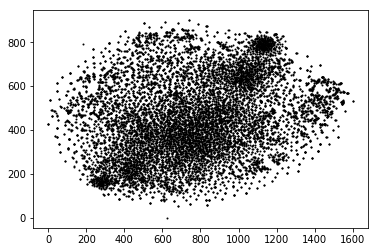

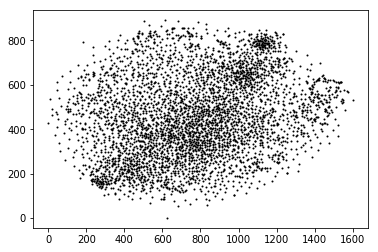

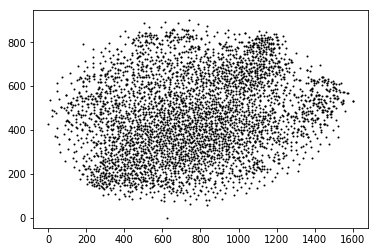

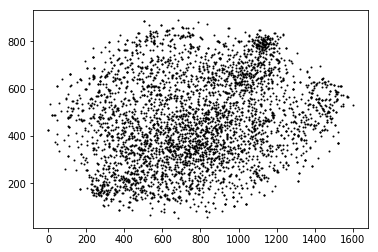

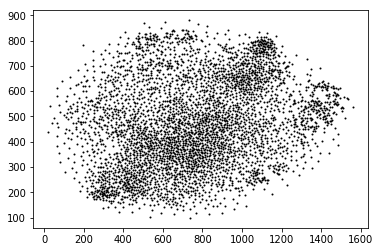

0.8863, 0.6789, 0.4922, 0.0159
0.8390, 0.7077, 0.5034, 0.0042
0.8420, 0.6729, 0.6537, 0.0414
0.7986, 0.6174, 0.8088, 0.0795


In [19]:
selected_labels = {1,2,3,4,5}
Epileptic = read_file('./evaluation_data/Epileptic/origin.csv')
Epileptic_result_our = read_file('./evaluation_data/Epileptic/6_6_0015_002_4.csv')
Epileptic_result_non_uniform = read_file('./evaluation_data/Epileptic/6_11_8.csv')
Epileptic_result_random = read_file('./evaluation_data/Epileptic/6_3850.csv')
Epileptic_result_weichen = read_file('./evaluation_data/Epileptic/6_omega460_dt5.csv')
Epileptic_result_weichen[0][:, 1] *= -1
Epileptic_range = Range2D(*np.amin(Epileptic[0], axis=0), *np.amax(Epileptic[0], axis=0))
Epileptic_sa = get_sample_areas(Epileptic, Epileptic_range)
Epileptic_our_sa = get_sample_areas(Epileptic_result_our, Epileptic_range)
Epileptic_non_uniform_sa = get_sample_areas(Epileptic_result_non_uniform, Epileptic_range)
Epileptic_random_sa = get_sample_areas(Epileptic_result_random, Epileptic_range)
Epileptic_weichen_sa = get_sample_areas(Epileptic_result_weichen, weichen_range)
origin_point_num = sum(map(lambda x: Epileptic_sa[x].data_density, Epileptic_sa))
pddr_list.append((PDDr(Epileptic_sa, Epileptic_our_sa), PDDr(Epileptic_sa, Epileptic_non_uniform_sa), 
      PDDr(Epileptic_sa, Epileptic_random_sa), PDDr(Epileptic_sa, Epileptic_weichen_sa)))
pcdr_list.append((PCDr(Epileptic_sa, Epileptic_our_sa), PCDr(Epileptic_sa, Epileptic_non_uniform_sa), 
      PCDr(Epileptic_sa, Epileptic_random_sa), PCDr(Epileptic_sa, Epileptic_weichen_sa)))
lc_list.append((LC(Epileptic_sa, Epileptic_our_sa), LC(Epileptic_sa, Epileptic_non_uniform_sa), 
      LC(Epileptic_sa, Epileptic_random_sa), LC(Epileptic_sa, Epileptic_weichen_sa)))
esar_list.append((esar(Epileptic_sa, Epileptic_our_sa), esar(Epileptic_sa, Epileptic_non_uniform_sa), 
      esar(Epileptic_sa, Epileptic_random_sa), esar(Epileptic_sa, Epileptic_weichen_sa)))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][0], pcdr_list[-1][0], lc_list[-1][0], esar_list[-1][0]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][1], pcdr_list[-1][1], lc_list[-1][1], esar_list[-1][1]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][2], pcdr_list[-1][2], lc_list[-1][2], esar_list[-1][2]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][3], pcdr_list[-1][3], lc_list[-1][3], esar_list[-1][3]))

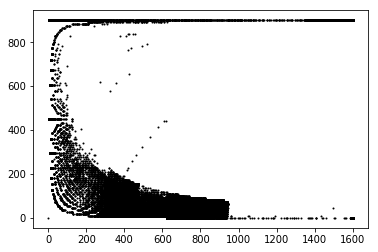

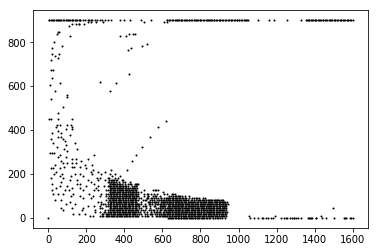

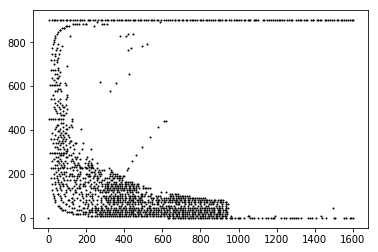

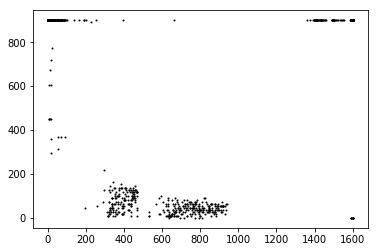

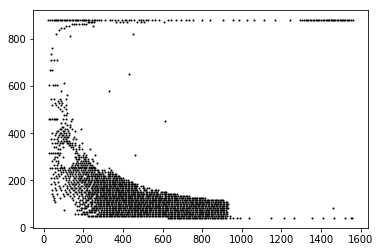

0.4699, 0.3052, 0.8045, 0.2611
0.9938, 0.9951, 0.9908, -0.0694
0.1569, 0.3103, 0.1671, 0.8605
0.0297, 0.0032, 0.1729, 0.0424


In [36]:
selected_labels = {'tcp', 'icmp', 'udp'}
kdd99 = read_file('./evaluation_data/kdd99/origin.csv')
kdd99_result_our = read_file('./evaluation_data/kdd99/6_6_002_002_4.csv')
kdd99_result_non_uniform = read_file('./evaluation_data/kdd99/6_10_8.csv')
kdd99_result_random = read_file('./evaluation_data/kdd99/6_1500.csv')
kdd99_result_weichen = read_file('./evaluation_data/kdd99/6_omega520_dt5.csv')
kdd99_result_weichen[0][:, 1] *= -1
kdd99_range = Range2D(*np.amin(kdd99[0], axis=0), *np.amax(kdd99[0], axis=0))
kdd99_sa = get_sample_areas(kdd99, kdd99_range)
kdd99_our_sa = get_sample_areas(kdd99_result_our, kdd99_range)
kdd99_non_uniform_sa = get_sample_areas(kdd99_result_non_uniform, kdd99_range)
kdd99_random_sa = get_sample_areas(kdd99_result_random, kdd99_range)
kdd99_weichen_sa = get_sample_areas(kdd99_result_weichen, weichen_range)
origin_point_num = sum(map(lambda x: kdd99_sa[x].data_density, kdd99_sa))
pddr_list.append((PDDr(kdd99_sa, kdd99_our_sa), PDDr(kdd99_sa, kdd99_non_uniform_sa), 
      PDDr(kdd99_sa, kdd99_random_sa), PDDr(kdd99_sa, kdd99_weichen_sa)))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][0], pddr_list[-1][1], pddr_list[-1][2], pddr_list[-1][3]))
pcdr_list.append((PCDr(kdd99_sa, kdd99_our_sa), PCDr(kdd99_sa, kdd99_non_uniform_sa), 
      PCDr(kdd99_sa, kdd99_random_sa), PCDr(kdd99_sa, kdd99_weichen_sa)))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pcdr_list[-1][0], pcdr_list[-1][1], pcdr_list[-1][2], pcdr_list[-1][3]))
lc_list.append((LC(kdd99_sa, kdd99_our_sa), LC(kdd99_sa, kdd99_non_uniform_sa), 
      LC(kdd99_sa, kdd99_random_sa), LC(kdd99_sa, kdd99_weichen_sa)))
print('%.4f, %.4f, %.4f, %.4f' % 
      (lc_list[-1][0], lc_list[-1][1], lc_list[-1][2], lc_list[-1][3]))
esar_list.append((esar(kdd99_sa, kdd99_our_sa), esar(kdd99_sa, kdd99_non_uniform_sa), 
      esar(kdd99_sa, kdd99_random_sa), esar(kdd99_sa, kdd99_weichen_sa)))
print('%.4f, %.4f, %.4f, %.4f' % 
      (esar_list[-1][0], esar_list[-1][1], esar_list[-1][2], esar_list[-1][3]))

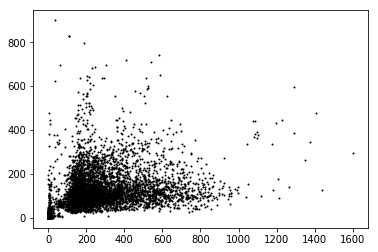

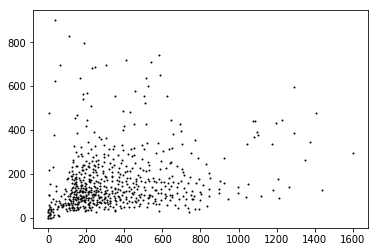

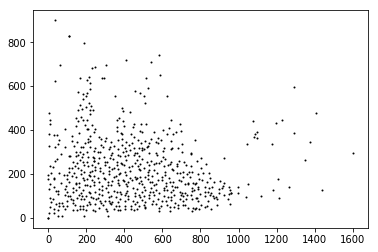

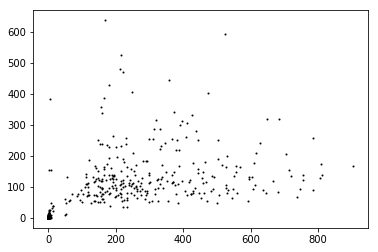

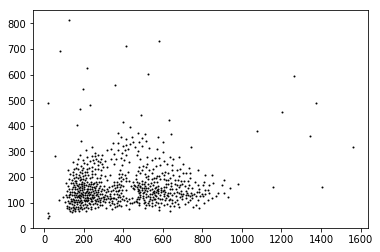

0.9533, 0.8394, 0.3207, 0.0657
0.7465, 0.6839, 0.4814, 0.0106
0.9212, 0.6589, 0.5135, 0.1792
0.3608, 0.7183, 2.1475, 0.1315


In [27]:
selected_labels = {1,2,3,4,5,6}
HumanAcitivityRecognition = read_file('./evaluation_data/HumanAcitivityRecognition/origin.csv')
HumanAcitivityRecognition_result_our = read_file('./evaluation_data/HumanAcitivityRecognition/6_6_008_002_4.csv')
HumanAcitivityRecognition_result_non_uniform = read_file('./evaluation_data/HumanAcitivityRecognition/6_21_8.csv')
HumanAcitivityRecognition_result_random = read_file('./evaluation_data/HumanAcitivityRecognition/6_650.csv')
HumanAcitivityRecognition_result_weichen = read_file('./evaluation_data/HumanAcitivityRecognition/6_omega560_dt5.csv')
HumanAcitivityRecognition_result_weichen[0][:, 1] *= -1
HumanAcitivityRecognition_range = Range2D(*np.amin(HumanAcitivityRecognition[0], axis=0), *np.amax(HumanAcitivityRecognition[0], axis=0))
HumanAcitivityRecognition_sa = get_sample_areas(HumanAcitivityRecognition, HumanAcitivityRecognition_range)
HumanAcitivityRecognition_our_sa = get_sample_areas(HumanAcitivityRecognition_result_our, HumanAcitivityRecognition_range)
HumanAcitivityRecognition_non_uniform_sa = get_sample_areas(HumanAcitivityRecognition_result_non_uniform, HumanAcitivityRecognition_range)
HumanAcitivityRecognition_random_sa = get_sample_areas(HumanAcitivityRecognition_result_random, HumanAcitivityRecognition_range)
HumanAcitivityRecognition_weichen_sa = get_sample_areas(HumanAcitivityRecognition_result_weichen, weichen_range)
origin_point_num = sum(map(lambda x: HumanAcitivityRecognition_sa[x].data_density, HumanAcitivityRecognition_sa))
pddr_list.append((PDDr(HumanAcitivityRecognition_sa, HumanAcitivityRecognition_our_sa), PDDr(HumanAcitivityRecognition_sa, HumanAcitivityRecognition_non_uniform_sa), 
      PDDr(HumanAcitivityRecognition_sa, HumanAcitivityRecognition_random_sa), PDDr(HumanAcitivityRecognition_sa, HumanAcitivityRecognition_weichen_sa)))
pcdr_list.append((PCDr(HumanAcitivityRecognition_sa, HumanAcitivityRecognition_our_sa), PCDr(HumanAcitivityRecognition_sa, HumanAcitivityRecognition_non_uniform_sa), 
      PCDr(HumanAcitivityRecognition_sa, HumanAcitivityRecognition_random_sa), PCDr(HumanAcitivityRecognition_sa, HumanAcitivityRecognition_weichen_sa)))
lc_list.append((LC(HumanAcitivityRecognition_sa, HumanAcitivityRecognition_our_sa), LC(HumanAcitivityRecognition_sa, HumanAcitivityRecognition_non_uniform_sa), 
      LC(HumanAcitivityRecognition_sa, HumanAcitivityRecognition_random_sa), LC(HumanAcitivityRecognition_sa, HumanAcitivityRecognition_weichen_sa)))
esar_list.append((esar(HumanAcitivityRecognition_sa, HumanAcitivityRecognition_our_sa), esar(HumanAcitivityRecognition_sa, HumanAcitivityRecognition_non_uniform_sa), 
      esar(HumanAcitivityRecognition_sa, HumanAcitivityRecognition_random_sa), esar(HumanAcitivityRecognition_sa, HumanAcitivityRecognition_weichen_sa)))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][0], pcdr_list[-1][0], lc_list[-1][0], esar_list[-1][0]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][1], pcdr_list[-1][1], lc_list[-1][1], esar_list[-1][1]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][2], pcdr_list[-1][2], lc_list[-1][2], esar_list[-1][2]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][3], pcdr_list[-1][3], lc_list[-1][3], esar_list[-1][3]))

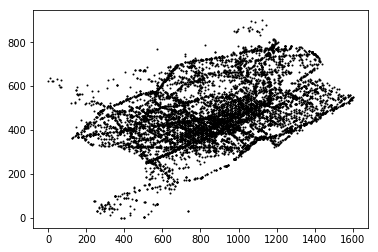

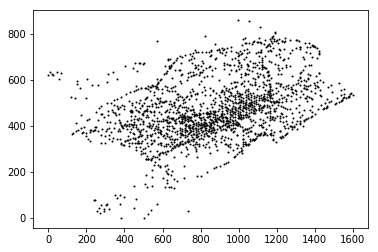

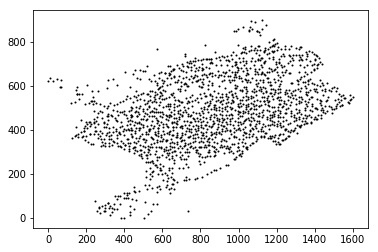

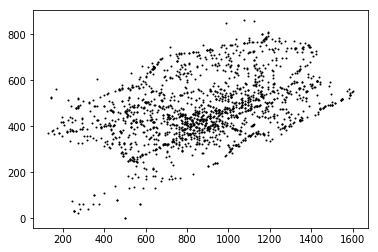

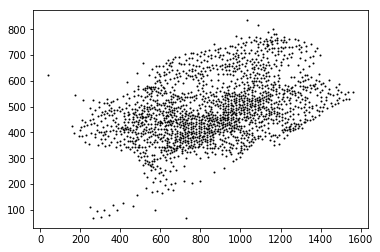

0.8654, 0.2687, 0.9497, 0.0509
0.7295, 0.0339, 1.7230, 0.0032
0.8233, 0.1630, 1.5492, 0.0880
0.7864, -0.0864, 2.0434, 0.0997


In [10]:
selected_labels = {0,1,2,3,4}
Barcelona = read_file('./evaluation_data/Barcelona/origin.csv')
Barcelona_result_our = read_file('./evaluation_data/Barcelona/6_6_002_002_4.csv')
Barcelona_result_non_uniform = read_file('./evaluation_data/Barcelona/6_15_8.csv')
Barcelona_result_random = read_file('./evaluation_data/Barcelona/6_1750.csv')
Barcelona_result_weichen = read_file('./evaluation_data/Barcelona/6_omega580_dt5.csv')
Barcelona_result_weichen[0][:, 1] *= -1
Barcelona_range = Range2D(*np.amin(Barcelona[0], axis=0), *np.amax(Barcelona[0], axis=0))
Barcelona_sa = get_sample_areas(Barcelona, Barcelona_range)
Barcelona_our_sa = get_sample_areas(Barcelona_result_our, Barcelona_range)
Barcelona_non_uniform_sa = get_sample_areas(Barcelona_result_non_uniform, Barcelona_range)
Barcelona_random_sa = get_sample_areas(Barcelona_result_random, Barcelona_range)
Barcelona_weichen_sa = get_sample_areas(Barcelona_result_weichen, weichen_range)
origin_point_num = sum(map(lambda x: Barcelona_sa[x].data_density, Barcelona_sa))
pddr_list.append((PDDr(Barcelona_sa, Barcelona_our_sa), PDDr(Barcelona_sa, Barcelona_non_uniform_sa), 
      PDDr(Barcelona_sa, Barcelona_random_sa), PDDr(Barcelona_sa, Barcelona_weichen_sa)))
pcdr_list.append((PCDr(Barcelona_sa, Barcelona_our_sa), PCDr(Barcelona_sa, Barcelona_non_uniform_sa), 
      PCDr(Barcelona_sa, Barcelona_random_sa), PCDr(Barcelona_sa, Barcelona_weichen_sa)))
lc_list.append((LC(Barcelona_sa, Barcelona_our_sa), LC(Barcelona_sa, Barcelona_non_uniform_sa), 
      LC(Barcelona_sa, Barcelona_random_sa), LC(Barcelona_sa, Barcelona_weichen_sa)))
esar_list.append((esar(Barcelona_sa, Barcelona_our_sa), esar(Barcelona_sa, Barcelona_non_uniform_sa), 
      esar(Barcelona_sa, Barcelona_random_sa), esar(Barcelona_sa, Barcelona_weichen_sa)))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][0], pcdr_list[-1][0], lc_list[-1][0], esar_list[-1][0]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][1], pcdr_list[-1][1], lc_list[-1][1], esar_list[-1][1]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][2], pcdr_list[-1][2], lc_list[-1][2], esar_list[-1][2]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][3], pcdr_list[-1][3], lc_list[-1][3], esar_list[-1][3]))

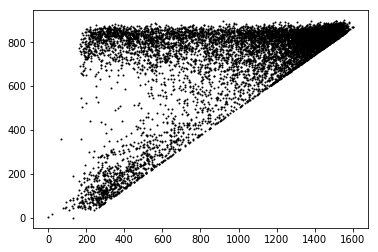

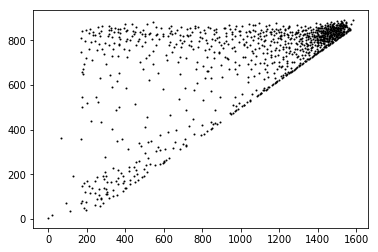

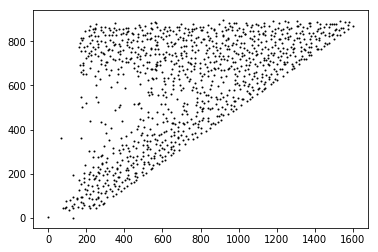

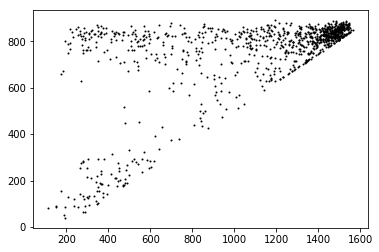

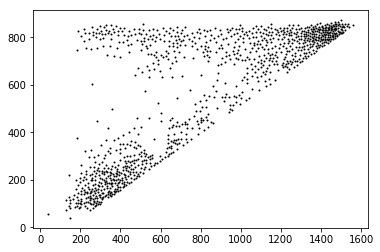

0.8754, 0.4130, 1.6958, 0.1432
0.6405, 0.2557, 2.0436, 0.0170
0.8681, 0.3324, 1.9250, 0.1856
0.7691, 0.2113, 2.2520, 0.1432


In [14]:
selected_labels = {'forest', 'water', 'orchard', 'impervious', 'farm', 'grass'}
crowdsourced = read_file('./evaluation_data/crowdsourced/origin.csv')
crowdsourced_result_our = read_file('./evaluation_data/crowdsourced/6_6_002_002_4.csv')
crowdsourced_result_non_uniform = read_file('./evaluation_data/crowdsourced/6_21_8.csv')
crowdsourced_result_random = read_file('./evaluation_data/crowdsourced/6_1000.csv')
crowdsourced_result_weichen = read_file('./evaluation_data/crowdsourced/6_omega650_dt5.csv')
crowdsourced_result_weichen[0][:, 1] *= -1
crowdsourced_range = Range2D(*np.amin(crowdsourced[0], axis=0), *np.amax(crowdsourced[0], axis=0))
crowdsourced_sa = get_sample_areas(crowdsourced, crowdsourced_range)
crowdsourced_our_sa = get_sample_areas(crowdsourced_result_our, crowdsourced_range)
crowdsourced_non_uniform_sa = get_sample_areas(crowdsourced_result_non_uniform, crowdsourced_range)
crowdsourced_random_sa = get_sample_areas(crowdsourced_result_random, crowdsourced_range)
crowdsourced_weichen_sa = get_sample_areas(crowdsourced_result_weichen, weichen_range)
origin_point_num = sum(map(lambda x: crowdsourced_sa[x].data_density, crowdsourced_sa))
pddr_list.append((PDDr(crowdsourced_sa, crowdsourced_our_sa), PDDr(crowdsourced_sa, crowdsourced_non_uniform_sa), 
      PDDr(crowdsourced_sa, crowdsourced_random_sa), PDDr(crowdsourced_sa, crowdsourced_weichen_sa)))
pcdr_list.append((PCDr(crowdsourced_sa, crowdsourced_our_sa), PCDr(crowdsourced_sa, crowdsourced_non_uniform_sa), 
      PCDr(crowdsourced_sa, crowdsourced_random_sa), PCDr(crowdsourced_sa, crowdsourced_weichen_sa)))
lc_list.append((LC(crowdsourced_sa, crowdsourced_our_sa), LC(crowdsourced_sa, crowdsourced_non_uniform_sa), 
      LC(crowdsourced_sa, crowdsourced_random_sa), LC(crowdsourced_sa, crowdsourced_weichen_sa)))
esar_list.append((esar(crowdsourced_sa, crowdsourced_our_sa), esar(crowdsourced_sa, crowdsourced_non_uniform_sa), 
      esar(crowdsourced_sa, crowdsourced_random_sa), esar(crowdsourced_sa, crowdsourced_weichen_sa)))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][0], pcdr_list[-1][0], lc_list[-1][0], esar_list[-1][0]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][1], pcdr_list[-1][1], lc_list[-1][1], esar_list[-1][1]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][2], pcdr_list[-1][2], lc_list[-1][2], esar_list[-1][2]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][3], pcdr_list[-1][3], lc_list[-1][3], esar_list[-1][3]))

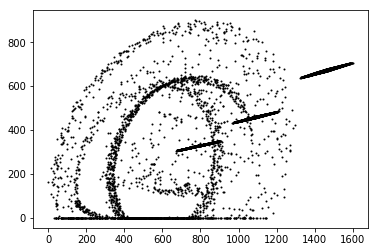

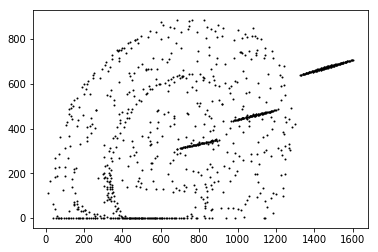

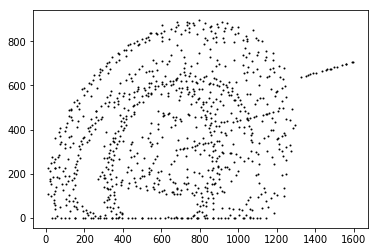

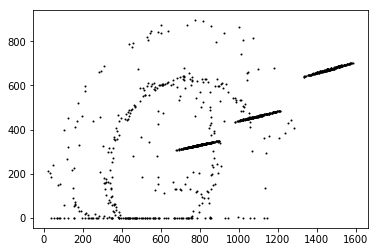

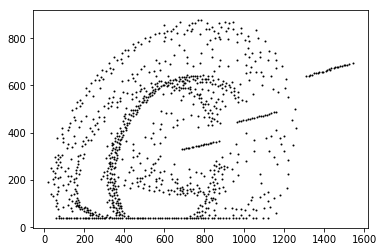

0.8798, 0.8746, 0.1351, 0.1156
0.6174, 0.7547, 0.2371, 0.0159
0.9051, 0.5461, 0.4474, 0.2895
0.5527, 0.3738, 0.8116, 0.0901


In [12]:
selected_labels = {3.0, 6.0, 9.0, 12.0, 15.0}
CBM = read_file('./evaluation_data/CBM/origin.csv')
CBM_result_our = read_file('./evaluation_data/CBM/6_4_006_002_4.csv')
CBM_result_non_uniform = read_file('./evaluation_data/CBM/6_21_8.csv')
CBM_result_random = read_file('./evaluation_data/CBM/6_1000.csv')
CBM_result_weichen = read_file('./evaluation_data/CBM/6_omega650_dt5.csv')
CBM_result_weichen[0][:, 1] *= -1
CBM_range = Range2D(*np.amin(CBM[0], axis=0), *np.amax(CBM[0], axis=0))
CBM_sa = get_sample_areas(CBM, CBM_range)
CBM_our_sa = get_sample_areas(CBM_result_our, CBM_range)
CBM_non_uniform_sa = get_sample_areas(CBM_result_non_uniform, CBM_range)
CBM_random_sa = get_sample_areas(CBM_result_random, CBM_range)
CBM_weichen_sa = get_sample_areas(CBM_result_weichen, weichen_range)
origin_point_num = sum(map(lambda x: CBM_sa[x].data_density, CBM_sa))
pddr_list.append((PDDr(CBM_sa, CBM_our_sa), PDDr(CBM_sa, CBM_non_uniform_sa), 
      PDDr(CBM_sa, CBM_random_sa), PDDr(CBM_sa, CBM_weichen_sa)))
pcdr_list.append((PCDr(CBM_sa, CBM_our_sa), PCDr(CBM_sa, CBM_non_uniform_sa), 
      PCDr(CBM_sa, CBM_random_sa), PCDr(CBM_sa, CBM_weichen_sa)))
lc_list.append((LC(CBM_sa, CBM_our_sa), LC(CBM_sa, CBM_non_uniform_sa), 
      LC(CBM_sa, CBM_random_sa), LC(CBM_sa, CBM_weichen_sa)))
esar_list.append((esar(CBM_sa, CBM_our_sa), esar(CBM_sa, CBM_non_uniform_sa), 
      esar(CBM_sa, CBM_random_sa), esar(CBM_sa, CBM_weichen_sa)))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][0], pcdr_list[-1][0], lc_list[-1][0], esar_list[-1][0]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][1], pcdr_list[-1][1], lc_list[-1][1], esar_list[-1][1]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][2], pcdr_list[-1][2], lc_list[-1][2], esar_list[-1][2]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][3], pcdr_list[-1][3], lc_list[-1][3], esar_list[-1][3]))

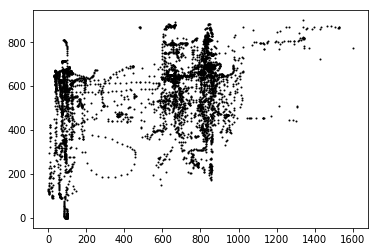

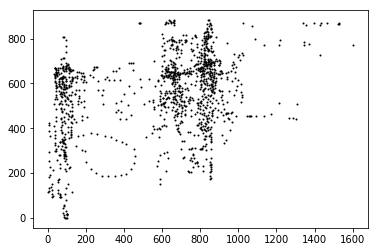

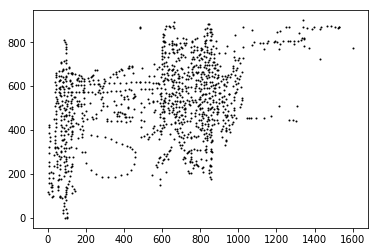

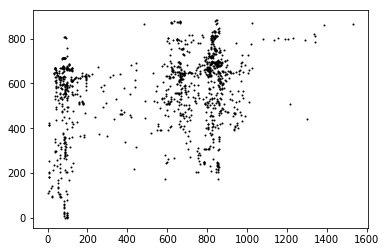

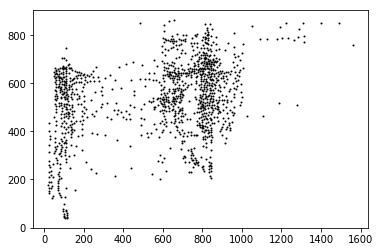

0.8937, 0.7259, 0.3044, 0.0679
0.7906, 0.6440, 0.7692, 0.0106
0.8909, 0.7565, 0.6982, 0.1145
0.7796, 0.6404, 0.9986, 0.0838


In [24]:
selected_labels = {'Rest', 'Preparation', 'Stroke', 'Retraction', 'Hold'}
gesture = read_file('./evaluation_data/gesture/origin.csv')
gesture_result_our = read_file('./evaluation_data/gesture/6_6_006_002_4.csv')
gesture_result_non_uniform = read_file('./evaluation_data/gesture/6_15_8.csv')
gesture_result_random = read_file('./evaluation_data/gesture/6_1150.csv')
gesture_result_weichen = read_file('./evaluation_data/gesture/6_omega520_dt5.csv')
gesture_result_weichen[0][:, 1] *= -1
gesture_range = Range2D(*np.amin(gesture[0], axis=0), *np.amax(gesture[0], axis=0))
gesture_sa = get_sample_areas(gesture, gesture_range)
gesture_our_sa = get_sample_areas(gesture_result_our, gesture_range)
gesture_non_uniform_sa = get_sample_areas(gesture_result_non_uniform, gesture_range)
gesture_random_sa = get_sample_areas(gesture_result_random, gesture_range)
gesture_weichen_sa = get_sample_areas(gesture_result_weichen, weichen_range)
origin_point_num = sum(map(lambda x: gesture_sa[x].data_density, gesture_sa))
pddr_list.append((PDDr(gesture_sa, gesture_our_sa), PDDr(gesture_sa, gesture_non_uniform_sa), 
      PDDr(gesture_sa, gesture_random_sa), PDDr(gesture_sa, gesture_weichen_sa)))
pcdr_list.append((PCDr(gesture_sa, gesture_our_sa), PCDr(gesture_sa, gesture_non_uniform_sa), 
      PCDr(gesture_sa, gesture_random_sa), PCDr(gesture_sa, gesture_weichen_sa)))
lc_list.append((LC(gesture_sa, gesture_our_sa), LC(gesture_sa, gesture_non_uniform_sa), 
      LC(gesture_sa, gesture_random_sa), LC(gesture_sa, gesture_weichen_sa)))
esar_list.append((esar(gesture_sa, gesture_our_sa), esar(gesture_sa, gesture_non_uniform_sa), 
      esar(gesture_sa, gesture_random_sa), esar(gesture_sa, gesture_weichen_sa)))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][0], pcdr_list[-1][0], lc_list[-1][0], esar_list[-1][0]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][1], pcdr_list[-1][1], lc_list[-1][1], esar_list[-1][1]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][2], pcdr_list[-1][2], lc_list[-1][2], esar_list[-1][2]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][3], pcdr_list[-1][3], lc_list[-1][3], esar_list[-1][3]))

In [42]:
kdd99_result_our = read_file('./evaluation_data/kdd99/6_6_002_002_4_9945.csv')
kdd99_our_sa = get_sample_areas(kdd99_result_our, kdd99_range)
print('%.4f, %.4f, %.4f, %.4f' % 
      (PDDr(kdd99_sa, kdd99_our_sa), PDDr(kdd99_sa, kdd99_non_uniform_sa), 
      PDDr(kdd99_sa, kdd99_random_sa), PDDr(kdd99_sa, kdd99_weichen_sa)))
print('%.4f, %.4f, %.4f, %.4f' % 
      (PCDr(kdd99_sa, kdd99_our_sa), PCDr(kdd99_sa, kdd99_non_uniform_sa), 
      PCDr(kdd99_sa, kdd99_random_sa), PCDr(kdd99_sa, kdd99_weichen_sa)))
print('%.4f, %.4f, %.4f, %.4f' % 
      (LC(kdd99_sa, kdd99_our_sa), LC(kdd99_sa, kdd99_non_uniform_sa), 
      LC(kdd99_sa, kdd99_random_sa), LC(kdd99_sa, kdd99_weichen_sa)))
print('%.4f, %.4f, %.4f, %.4f' % 
      (esar(kdd99_sa, kdd99_our_sa), esar(kdd99_sa, kdd99_non_uniform_sa), 
      esar(kdd99_sa, kdd99_random_sa), esar(kdd99_sa, kdd99_weichen_sa)))

OSError: ./evaluation_data/kdd99/6_6_002_002_4_9945.csv not found.

In [272]:
pddr_list.pop()
pcdr_list.pop()
lc_list.pop()
esar_list.pop()

(0.033934252386002124,
 0.003181336161187699,
 0.17179215270413573,
 0.042417815482502653)

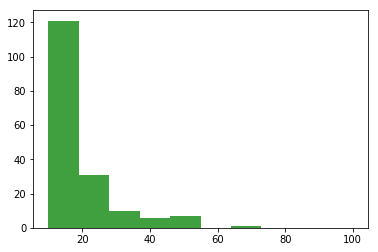

In [23]:
n, bins, patches = plt.hist(diffs, range=(10.0,100.0), facecolor='g', alpha=0.75)

In [133]:
PersonActivity2 = filter_data_by_label(*PersonActivity)
scale(PersonActivity2[0], PersonActivity_range, Range2D(0, 0, canvas_width, canvas_height))

array([[1150.69645859,  480.30498474],
       [1211.39610916,  457.90948671],
       [1229.19280514,  467.02821578],
       ...,
       [ 919.04368185,  484.99016802],
       [ 908.77979867,  488.09843094],
       [ 924.635678  ,  489.79140681]])

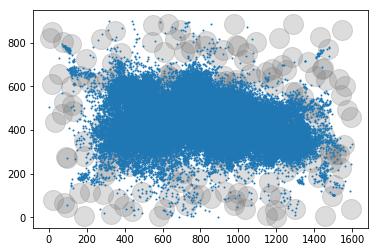

In [134]:
_ = plt.scatter(centers[:, 0], centers[:,1], c='#777777', alpha=0.25, s=400)
_ = plt.scatter(PersonActivity2[0][:, 0], PersonActivity2[0][:, 1], s=1)

In [160]:
selected_labels = {'F', 'I', 'M'}
abalone = read_file('./evaluation_data/abalone/origin.csv')
abalone_result_our = read_file('./evaluation_data/abalone/6_6_002_002_4.csv')
abalone_result_non_uniform = read_file('./evaluation_data/abalone/6_11_8.csv')
abalone_result_random = read_file('./evaluation_data/abalone/6_1000.csv')
abalone_result_weichen = read_file('./evaluation_data/abalone/6_omega500_dt5.csv')
abalone_result_weichen[0][:, 1] *= -1
abalone_range = Range2D(*np.amin(abalone[0], axis=0), *np.amax(abalone[0], axis=0))
centers = get_random_center()
abalone_ra = get_random_disks(abalone, centers, abalone_range)
abalone_our_ra = get_random_disks(abalone_result_our, centers, abalone_range)
abalone_non_uniform_ra = get_random_disks(abalone_result_non_uniform, centers, abalone_range)
abalone_random_ra = get_random_disks(abalone_result_random, centers, abalone_range)
abalone_weichen_ra = get_random_disks(abalone_result_weichen, centers, weichen_range)

In [161]:
score, diffs = point_density_score(abalone_ra, abalone_our_ra)
print('our:', score)
score, diffs = point_density_score(abalone_ra, abalone_non_uniform_ra)
print('non_uniform:',score)
score, diffs = point_density_score(abalone_ra, abalone_random_ra)
print('random:',score)
score, diffs = point_density_score(abalone_ra, abalone_weichen_ra)
print('weichen:',score)

our: 9994.898510723538
non_uniform: 24450.71070560582
random: 6485.804057325924
weichen: 10483.167128202022


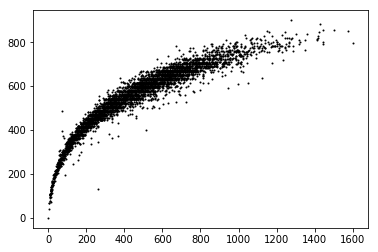

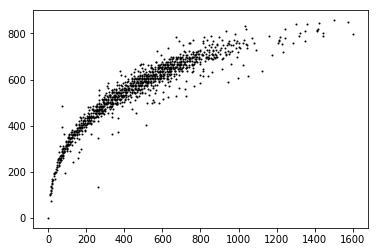

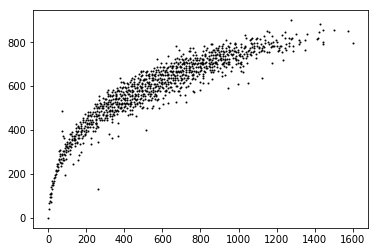

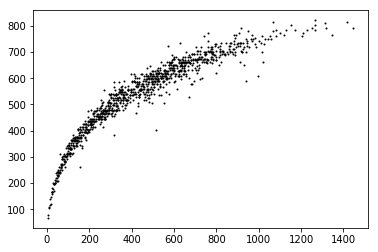

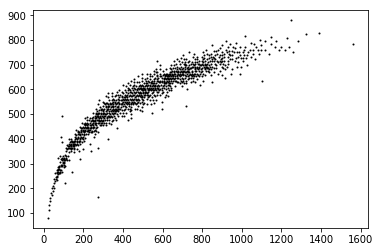

abalone (F, I, M)
modified_lddr: 0.08430481718315676
modified_lddr: 0.1580812409651545
modified_lddr: 0.08489785027787575
modified_lddr: 0.11352700265174429


In [171]:
selected_labels = {'F', 'I', 'M'}
abalone = read_file('./evaluation_data/abalone/origin.csv')
abalone_result_our = read_file('./evaluation_data/abalone/6_6_002_002_4.csv')
abalone_result_non_uniform = read_file('./evaluation_data/abalone/6_11_8.csv')
abalone_result_random = read_file('./evaluation_data/abalone/6_1000.csv')
abalone_result_weichen = read_file('./evaluation_data/abalone/6_omega500_dt5.csv')
abalone_result_weichen[0][:, 1] *= -1
abalone_range = Range2D(*np.amin(abalone[0], axis=0), *np.amax(abalone[0], axis=0))
abalone_sa = get_sample_areas(abalone, abalone_range)
abalone_our_sa = get_sample_areas(abalone_result_our, abalone_range)
abalone_non_uniform_sa = get_sample_areas(abalone_result_non_uniform, abalone_range)
abalone_random_sa = get_sample_areas(abalone_result_random, abalone_range)
abalone_weichen_sa = get_sample_areas(abalone_result_weichen, Range2D(0,-900,1600,0))
print('abalone (F, I, M)')
#print('ESAr:', esar(abalone_sa, abalone_our_sa))
#print('ESAr:', esar(abalone_sa, abalone_non_uniform_sa))
#print('ESAr:', esar(abalone_sa, abalone_random_sa))
#print('ESAr:', esar(abalone_sa, abalone_weichen_sa))
#p_match = lambda a, b: p_diff(a.data_density, b.data_density) == p_diff(len(a.represented_density.keys()), len(b.represented_density.keys()))
#print('PLDDr:', lddr(abalone_sa, p_match))
#print('PLDDr:', lddr(abalone_our_sa, p_match))
#print('PLDDr:', lddr(abalone_non_uniform_sa, p_match))
#print('PLDDr:', lddr(abalone_random_sa, p_match))
#print('PLDDr:', lddr(abalone_weichen_sa, p_match))
print('our modified_lddr:', modified_lddr(abalone_sa, abalone_our_sa))
print('non_uniform modified_lddr:', modified_lddr(abalone_sa, abalone_non_uniform_sa))
print('random modified_lddr:', modified_lddr(abalone_sa, abalone_random_sa))
print('weichen modified_lddr:', modified_lddr(abalone_sa, abalone_weichen_sa))

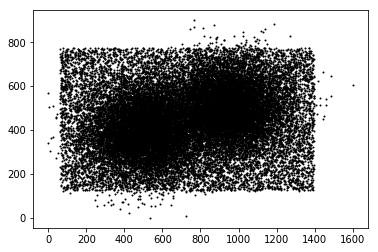

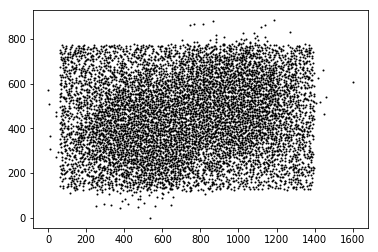

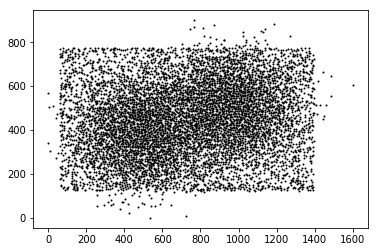

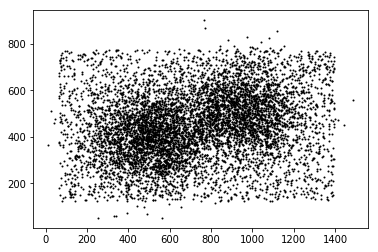

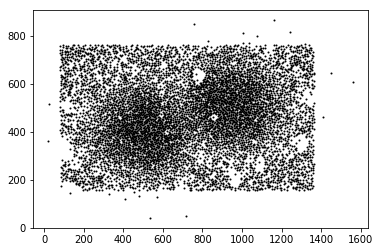

synthesis_weichen (0, 1, 2)
32
ESAr: 0.021636240703177823
14
ESAr: 0.009465855307640297
106
ESAr: 0.07167004732927654
170
ESAr: 0.11494252873563218
PLDDr: 0.4603046277989144
PLDDr: 0.14839901477832512
PLDDr: 0.13595113438045375
PLDDr: 0.28055891703415037
PLDDr: 0.4264069264069264


In [28]:
selected_labels = {0, 1, 2}
synthesis_weichen = read_file('./evaluation_data/synthesis_weichen.csv')
synthesis_weichen_result_our = read_file('./data/synthesis_weichen_result_4_9_0.13.csv')
synthesis_weichen_result_non_uniform = read_file('./data/synthesis_weichen_result_non_uniform_8.csv')
synthesis_weichen_result_random = read_file('./data/synthesis_weichen_result_random_7200.csv')
synthesis_weichen_result_weichen = read_file('./data/synthesis_weichen_result_weichen_dt5.0_omega450.csv')
synthesis_weichen_result_weichen[0][:, 1] *= -1
synthesis_weichen_range = Range2D(*np.amin(synthesis_weichen[0], axis=0), *np.amax(synthesis_weichen[0], axis=0))
synthesis_weichen_sa = get_sample_areas(synthesis_weichen, synthesis_weichen_range)
synthesis_weichen_our_sa = get_sample_areas(synthesis_weichen_result_our, synthesis_weichen_range)
synthesis_weichen_non_uniform_sa = get_sample_areas(synthesis_weichen_result_non_uniform, synthesis_weichen_range)
synthesis_weichen_random_sa = get_sample_areas(synthesis_weichen_result_random, synthesis_weichen_range)
synthesis_weichen_weichen_sa = get_sample_areas(synthesis_weichen_result_weichen, Range2D(0,-900,1600,0))
print('synthesis_weichen (0, 1, 2)')
print('ESAr:', esar(synthesis_weichen_sa, synthesis_weichen_our_sa))
print('ESAr:', esar(synthesis_weichen_sa, synthesis_weichen_non_uniform_sa))
print('ESAr:', esar(synthesis_weichen_sa, synthesis_weichen_random_sa))
print('ESAr:', esar(synthesis_weichen_sa, synthesis_weichen_weichen_sa))
p_match = lambda a, b: p_diff(a.data_density, b.data_density) == p_diff(len(a.represented_density.keys()), len(b.represented_density.keys()))
print('PLDDr:', lddr(synthesis_weichen_sa, p_match))
print('PLDDr:', lddr(synthesis_weichen_our_sa, p_match))
print('PLDDr:', lddr(synthesis_weichen_non_uniform_sa, p_match))
print('PLDDr:', lddr(synthesis_weichen_random_sa, p_match))
print('PLDDr:', lddr(synthesis_weichen_weichen_sa, p_match))

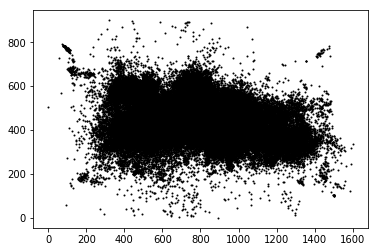

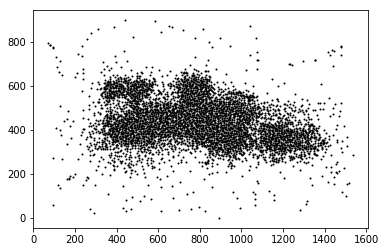

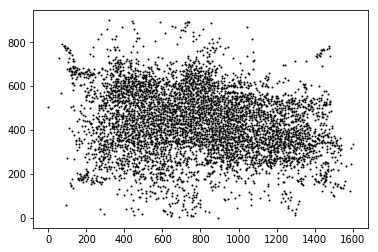

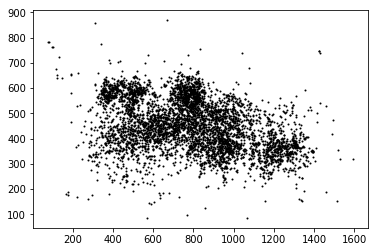

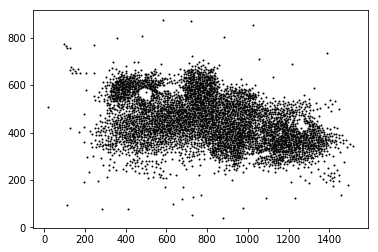

our modified_lddr: 0.03979198117035955
non_uniform modified_lddr: 0.026107864621378134
random modified_lddr: 0.017047642236831428
weichen modified_lddr: 0.033621215810405


In [35]:
selected_labels = {'walking', 'lying', 'lying down', 'on all fours'}
PersonActivity = read_file('./evaluation_data/PersonActivity/origin.csv')
PersonActivity_result_our = read_file('./evaluation_data/PersonActivity/6_7_002_003_4.csv')
PersonActivity_result_non_uniform = read_file('./evaluation_data/PersonActivity/PersonActivity2_result_non_uniform_8_4895.csv')
PersonActivity_result_random = read_file('./evaluation_data/PersonActivity/PersonActivity2_result_random_5000.csv')
PersonActivity_result_weichen = read_file('./evaluation_data/PersonActivity/PersonActivity2_result_dt5.0_omega520_2.csv')
PersonActivity_result_weichen[0][:, 1] *= -1
PersonActivity_range = Range2D(*np.amin(PersonActivity[0], axis=0), *np.amax(PersonActivity[0], axis=0))
PersonActivity_sa = get_sample_areas(PersonActivity, PersonActivity_range)
PersonActivity_our_sa = get_sample_areas(PersonActivity_result_our, PersonActivity_range)
PersonActivity_non_uniform_sa = get_sample_areas(PersonActivity_result_non_uniform, PersonActivity_range)
PersonActivity_random_sa = get_sample_areas(PersonActivity_result_random, PersonActivity_range)
PersonActivity_weichen_sa = get_sample_areas(PersonActivity_result_weichen, Range2D(0,-900,1600,0))
print('our modified_lddr:', modified_lddr(PersonActivity_sa, PersonActivity_our_sa))
print('non_uniform modified_lddr:', modified_lddr(PersonActivity_sa, PersonActivity_non_uniform_sa))
print('random modified_lddr:', modified_lddr(PersonActivity_sa, PersonActivity_random_sa))
print('weichen modified_lddr:', modified_lddr(PersonActivity_sa, PersonActivity_weichen_sa))

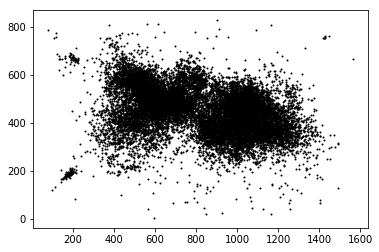

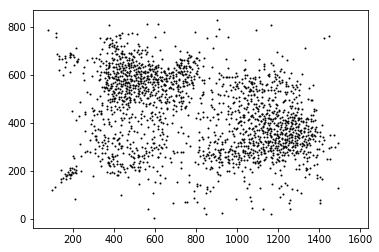

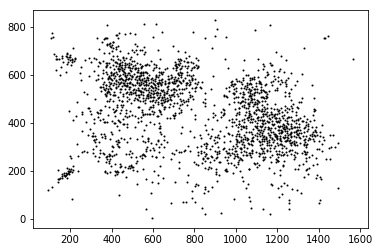

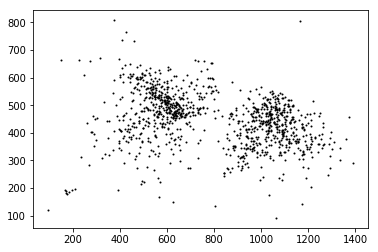

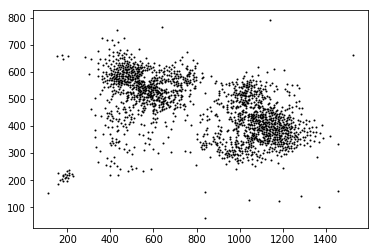

PersonActivity (standing up from lying)
38
ESAr: 0.025693035835023664
67
ESAr: 0.045300878972278566
347
ESAr: 0.23461798512508453
289
ESAr: 0.19540229885057472
PLDDr: 0.46392778973312
PLDDr: 0.27155172413793105
PLDDr: 0.18042328042328043
PLDDr: 0.11127819548872181
PLDDr: 0.029296875


In [35]:
selected_labels = {'standing up from lying'}
PersonActivity_sa = get_sample_areas(PersonActivity, PersonActivity_range)
PersonActivity_our_sa = get_sample_areas(PersonActivity_result_our, PersonActivity_range)
PersonActivity_non_uniform_sa = get_sample_areas(PersonActivity_result_non_uniform, PersonActivity_range)
PersonActivity_random_sa = get_sample_areas(PersonActivity_result_random, PersonActivity_range)
PersonActivity_weichen_sa = get_sample_areas(PersonActivity_result_weichen, Range2D(0,-900,1600,0))
print('PersonActivity (standing up from lying)')
print('ESAr:', esar(PersonActivity_sa, PersonActivity_our_sa))
print('ESAr:', esar(PersonActivity_sa, PersonActivity_non_uniform_sa))
print('ESAr:', esar(PersonActivity_sa, PersonActivity_random_sa))
print('ESAr:', esar(PersonActivity_sa, PersonActivity_weichen_sa))
p_match = lambda a, b: p_diff(a.data_density, b.data_density) == p_diff(len(a.represented_density.keys()), len(b.represented_density.keys()))
print('PLDDr:', lddr(PersonActivity_sa, p_match))
print('PLDDr:', lddr(PersonActivity_our_sa, p_match))
print('PLDDr:', lddr(PersonActivity_non_uniform_sa, p_match))
print('PLDDr:', lddr(PersonActivity_random_sa, p_match))
print('PLDDr:', lddr(PersonActivity_weichen_sa, p_match))

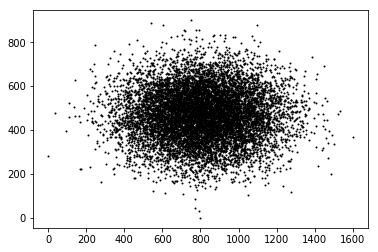

0.3742815363173167


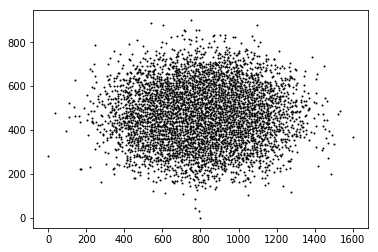

0.07536656891495601


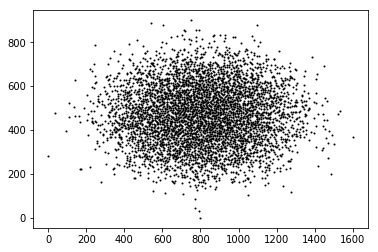

0.11741104424031254


In [16]:
selected_labels = {0, 1, 2}
synthesis4 = read_file('./evaluation_data/synthesis4.csv')
synthesis4_result_our = read_file('./data/synthesis4_result_4_9_1.0.csv')
synthesis4_result_non_uniform = read_file('./data/synthesis4_result_non_uniform_8_2.csv')
synthesis4_range =  Range2D(*np.amin(synthesis4[0], axis=0), *np.amax(synthesis4[0], axis=0))
print(lddr(get_sample_areas(synthesis4, synthesis4_range),
     lambda a, b: p_diff(a.data_density, b.data_density) == p_diff(len(a.represented_density.keys()), len(b.represented_density.keys()))))
print(lddr(get_sample_areas(synthesis4_result_our, synthesis4_range),
     lambda a, b: p_diff(a.data_density, b.data_density) == p_diff(len(a.represented_density.keys()), len(b.represented_density.keys()))))
print(lddr(get_sample_areas(synthesis4_result_non_uniform, synthesis4_range),
     lambda a, b: p_diff(a.data_density, b.data_density) == p_diff(len(a.represented_density.keys()), len(b.represented_density.keys()))))

In [10]:
class RandomDisk(object):
    def __init__(self, center, dataset, radius=100):
        self.center = center
        self.radius = radius
        self.total_points = 0
        self.class_points = defaultdict(int)
        for i,p in enumerate(dataset[0]):
            if self.is_in_bounding_box(p) and math.hypot(center[0] - p[0], center[1] - p[1]) < radius:
                self.total_points+=1
                self.class_points[dataset[1][i]]+=1

    def is_in_bounding_box(self, p):
        return (self.center[0] - self.radius) < p[0] < (self.center[0] + self.radius) and (self.center[1] - self.radius) < p[1] < (self.center[1] + self.radius)

def get_random_center(num=500):
    x = canvas_width*np.random.rand(num)
    y = canvas_height*np.random.rand(num)
    return np.c_[x,y]

def get_random_disks(data, centers, data_range):
    data = filter_data_by_label(*data)
    scale(data[0], data_range, Range2D(0, 0, canvas_width, canvas_height))
    random_disks = []
    for c in centers:
        rd = RandomDisk(c, data)
        random_disks.append(rd)
    return random_disks

def point_density_score(origin_ra, result_ra):
    sum_ = 0
    diffs = []
    for i, j in combinations(range(len(origin_ra)), 2):
        if result_ra[i].total_points > result_ra[j].total_points:
            i,j = j,i
        if result_ra[j].total_points == 0: #skip zeros
            continue
        origin_ratio = (origin_ra[i].total_points)/(origin_ra[j].total_points)
        result_ratio = (result_ra[i].total_points)/(result_ra[j].total_points)
        diff = (origin_ra[j].total_points-origin_ra[i].total_points)*abs(origin_ratio-result_ratio)
        diffs.append(diff)
        sum_ += diff
    return sum_, diffs

def class_density_score(origin_ra, result_ra):
    def get_ordered_label(class_points):
        d = deepcopy(class_points)
        for lb in selected_labels:
            if not d[lb]:
                d[lb] = 0
        return [b for a,b in sorted(zip(d.values(), d.keys()))]
    improper_order, missing_rare_class = [], []
    score_sum, loss_class_degree = 0, 0
    for i in range(len(origin_ra)):
        if len(origin_ra[i].class_points) != len(result_ra[i].class_points):
            missing_rare_class.append((i, origin_ra[i].class_points.keys()-result_ra[i].class_points.keys()))
            loss_class_degree += origin_ra[i].total_points*len(origin_ra[i].class_points.keys()-result_ra[i].class_points.keys())

        origin_order = get_ordered_label(origin_ra[i].class_points)
        result_order = get_ordered_label(result_ra[i].class_points)
        score = origin_ra[i].total_points*stats.spearmanr(result_order, origin_order)[0]
        if score < 1:
            improper_order.append((i, score, origin_order, result_order))
        score_sum += score
    return improper_order, missing_rare_class, score_sum/len(origin_ra)/origin_avg_point_num, loss_class_degree/len(origin_ra)/origin_avg_point_num

In [4]:
# KNNG metric
def label_xor(a, b):
    return 1 if a == b else 0

def KNNG_value(x, indices, labels):
    return sum(label_xor(labels[x], labels[i]) for i in indices)/len(indices)

def calKNNG(fn):
    xy, labels = read_file(fn)
    xy, labels = filter_data_by_label(xy, labels)
    tree = cKDTree(xy)
    dists, indices = tree.query(xy, k=2)
    return sum(KNNG_value(i, idx, labels) for i,idx in enumerate(indices))/len(indices)

In [10]:
print("origin:"+str(calKNNG('./data/PersonActivity.csv')))
print("our:"+str(calKNNG('./data/PersonActivity2_7_7_0.04.csv')))
print("chenwei:"+str(calKNNG('./data/PersonActivity2_result_dt5.0_omega460.csv')))
print("random:"+str(calKNNG('./data/PersonActivity2_result_random_6000.csv')))
print("enrico:"+str(calKNNG('./data/PersonActivity2_result_non_uniform_8.csv')))

origin:0.8386886764423161
our:0.7996711664935964
chenwei:0.8968606180144642
random:0.8764166666666666
enrico:0.8532303370786517


In [9]:
print(calKNNG('./data/synthesis_weichen.csv'))
print(calKNNG('./data/synthesis_weichen_result_4_9_0.13.csv'))
print(calKNNG('./data/synthesis_weichen_result_4_9_0.13_random.csv'))
print(calKNNG('./data/synthesis_weichen_result_non_uniform_8.csv'))

0.8241833333333334
0.7725118483412322
0.8231112350153331
0.8141449683321604


In [10]:
print(calKNNG('./data/synthesis4.csv'))
print(calKNNG('./data/synthesis4_result_4_8_0.25.csv'))
print(calKNNG('./data/synthesis4_result_non_uniform_8.csv'))

0.9924
0.9871626069782752
0.9866177167219328


In [12]:
print(calKNNG('./data/abalone.csv'))
print(calKNNG('./data/abalone_result_4_8_0.25.csv'))
print(calKNNG('./data/abalone_result_4_8_0.25_random.csv'))
print(calKNNG('./data/abalone_result_non_uniform_8.csv'))

0.7376107254010055
0.6975
0.7410714285714286
0.7323369565217391


In [25]:
data_names = ['PersonActivity', 'abalone', 'CreditCardFaurd', 'DailySports', 'avila', 'kiva_loans', 'diabetes', 
              'forest_covertype', 'satimage', 'NewsPopularity', 'Nomao', 'terrorism', 'wine']
colors = ["#4c78a8", "#9ecae9", "#f58518", "#ffbf79"]
a = np.array(pcdr_list)

In [7]:
method_name = ['Our', 'Non-uniform', 'Random', 'Wei Chen\'s']

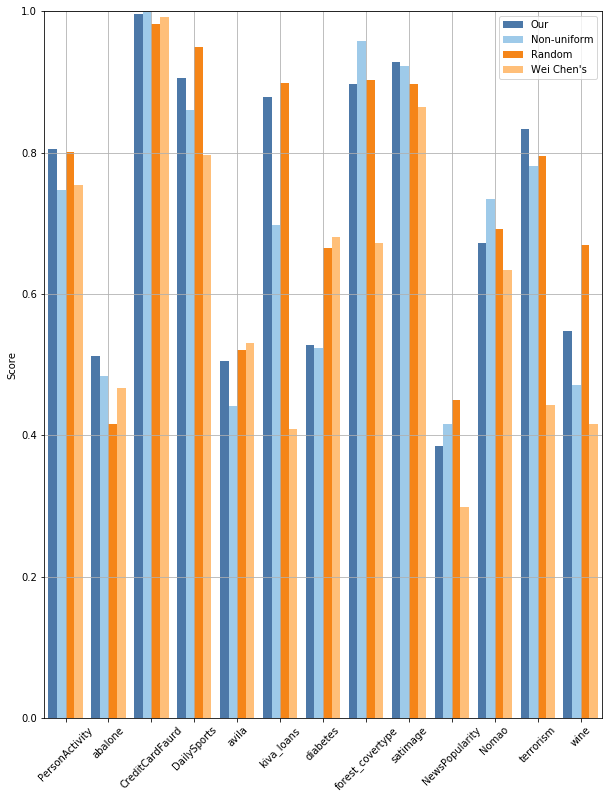

In [221]:
pos = list(range(len(data_names))) 
width = 0.2

# Plotting the bars
fig, ax = plt.subplots(figsize=(10,len(data_names)))

# Create a bar with pre_score data,
# in position pos,
for i, c in enumerate(colors):
    plt.bar([p + width*i for p in pos], 
            #using df['pre_score'] data,
            a[:, i], 
            # of width
            width, 
            # with color
            color=c) 

# Set the y axis label
ax.set_ylabel('Score')

# Set the position of the x ticks
ax.set_xticks([p + 1.5 * width for p in pos])

# Set the labels for the x ticks
ax.tick_params(axis='x', rotation=45)
ax.set_xticklabels(data_names)

# Setting the x-axis and y-axis limits
plt.xlim(min(pos)-width, max(pos)+width*(i+1))
plt.ylim([0, 1.0])

# Adding the legend and showing the plot
plt.legend(method_name)
plt.grid()
plt.show()

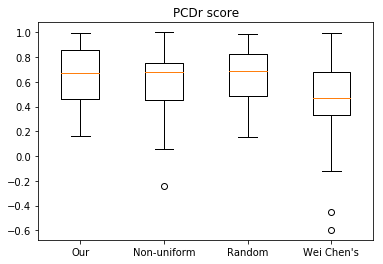

In [313]:
fig, ax = plt.subplots()

ax.set_title('PCDr score')
a = np.array(pcdr_list)
a2 = np.delete(a, [3, 23], 0)
ax.boxplot(a2)
ax.set_xticklabels(method_name)
plt.savefig('PCDr.pdf')

[Text(0, 0, 'Our'),
 Text(0, 0, 'Non-uniform'),
 Text(0, 0, 'Random'),
 Text(0, 0, "Wei Chen's")]

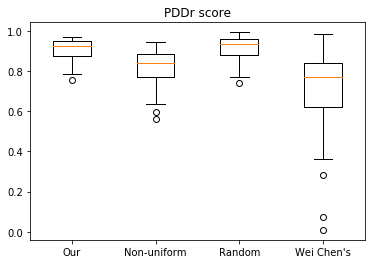

In [309]:
fig, ax = plt.subplots()

ax.set_title('PDDr score')
a = np.array(pddr_list)
a2 = np.delete(a, [3, 23], 0)
ax.boxplot(a2)
ax.set_xticklabels(method_name)
plt.savefig('PDDr.pdf')

[Text(0, 0, 'Our'),
 Text(0, 0, 'Non-uniform'),
 Text(0, 0, 'Random'),
 Text(0, 0, "Wei Chen's")]

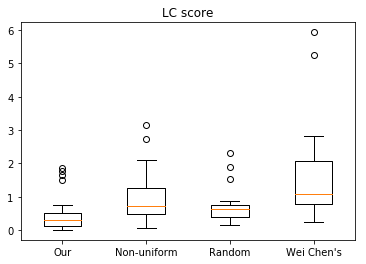

In [310]:
fig, ax = plt.subplots()

ax.set_title('LC score')
a = np.array(lc_list)
a2 = np.delete(a, [3, 23], 0)
ax.boxplot(a2)
ax.set_xticklabels(method_name)
plt.savefig('LC.pdf')

[Text(0, 0, 'Our'),
 Text(0, 0, 'Non-uniform'),
 Text(0, 0, 'Random'),
 Text(0, 0, "Wei Chen's")]

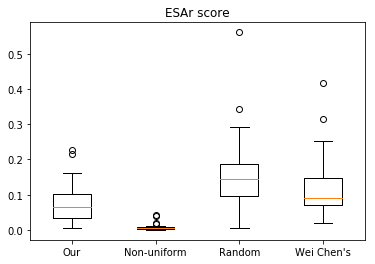

In [311]:
fig, ax = plt.subplots()

ax.set_title('ESAr score')
a = np.array(esar_list)
a2 = np.delete(a, [3, 23], 0)
ax.boxplot(a2)
ax.set_xticklabels(method_name)
plt.savefig('ESAr.pdf')

In [314]:
np.array(pcdr_list)

array([[ 0.80519844,  0.74741498,  0.80104091,  0.75418797],
       [ 0.51256883,  0.48348097,  0.41560929,  0.46732104],
       [ 0.99649587,  0.9997472 ,  0.98221954,  0.99114488],
       [ 0.90612519,  0.8608234 ,  0.94903586,  0.79601219],
       [ 0.50484838,  0.44067348,  0.52018688,  0.53041255],
       [ 0.87856884,  0.69766197,  0.89825255,  0.40925947],
       [ 0.52715769,  0.52270411,  0.66523273,  0.68013328],
       [ 0.89696665,  0.95717908,  0.90237309,  0.67203005],
       [ 0.92818167,  0.92212595,  0.89764535,  0.86442905],
       [ 0.38405817,  0.41515246,  0.44978818,  0.29841161],
       [ 0.67179599,  0.73468468,  0.69186283,  0.6340744 ],
       [ 0.83381075,  0.78048472,  0.79468761,  0.44314385],
       [ 0.54756538,  0.470645  ,  0.66860988,  0.41547024],
       [ 0.96864563,  0.98295348,  0.94173992,  0.73102306],
       [ 0.25033434,  0.1522121 ,  0.44324402, -0.59581874],
       [ 0.68821388,  0.72170398,  0.8546466 ,  0.43854031],
       [ 0.71688963,  0.

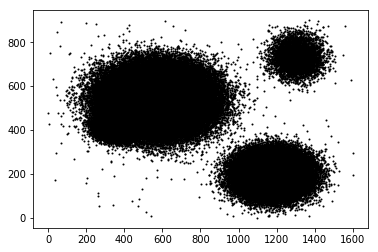

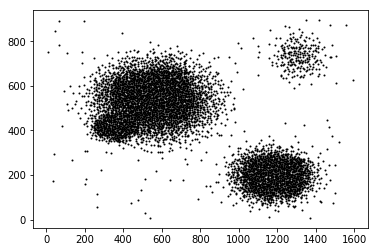

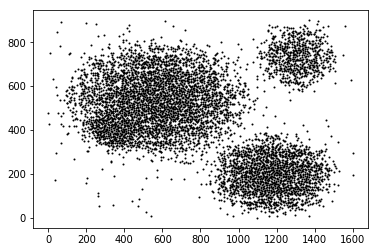

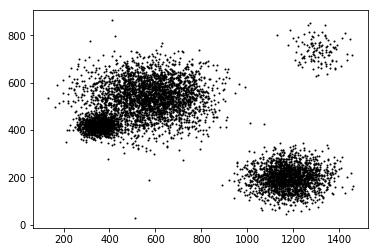

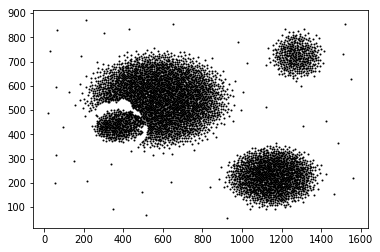

0.9376, 0.9094, 0.9746, 0.9140
0.9847, 0.8752, 0.9117, 0.8353
0.0160, 0.1662, 0.1337, 0.2133
0.1654, 0.0053, 0.3065, 0.2874


In [34]:
selected_labels = {1,2,3,4,5}
cluster_3 = read_file('./evaluation_data/3clu2/origin.csv')
cluster_3_result_our = read_file('./evaluation_data/3clu2/6_6_0015_002_4.csv')
cluster_3_result_non_uniform = read_file('./evaluation_data/3clu2/6_8_8.csv')
cluster_3_result_random = read_file('./evaluation_data/3clu2/6_6000.csv')
cluster_3_result_weichen = read_file('./evaluation_data/3clu2/6_omega460_dt5.csv')
cluster_3_result_weichen[0][:, 1] *= -1
cluster_3_range = Range2D(*np.amin(cluster_3[0], axis=0), *np.amax(cluster_3[0], axis=0))
cluster_3_sa = get_sample_areas(cluster_3, cluster_3_range)
cluster_3_our_sa = get_sample_areas(cluster_3_result_our, cluster_3_range)
cluster_3_non_uniform_sa = get_sample_areas(cluster_3_result_non_uniform, cluster_3_range)
cluster_3_random_sa = get_sample_areas(cluster_3_result_random, cluster_3_range)
cluster_3_weichen_sa = get_sample_areas(cluster_3_result_weichen, weichen_range)
origin_point_num = sum(map(lambda x: cluster_3_sa[x].data_density, cluster_3_sa))
pddr_list.append((PDDr(cluster_3_sa, cluster_3_our_sa), PDDr(cluster_3_sa, cluster_3_non_uniform_sa), 
      PDDr(cluster_3_sa, cluster_3_random_sa), PDDr(cluster_3_sa, cluster_3_weichen_sa)))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][0], pddr_list[-1][1], pddr_list[-1][2], pddr_list[-1][3]))
pcdr_list.append((PCDr(cluster_3_sa, cluster_3_our_sa), PCDr(cluster_3_sa, cluster_3_non_uniform_sa), 
      PCDr(cluster_3_sa, cluster_3_random_sa), PCDr(cluster_3_sa, cluster_3_weichen_sa)))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pcdr_list[-1][0], pcdr_list[-1][1], pcdr_list[-1][2], pcdr_list[-1][3]))
lc_list.append((LC(cluster_3_sa, cluster_3_our_sa), LC(cluster_3_sa, cluster_3_non_uniform_sa), 
      LC(cluster_3_sa, cluster_3_random_sa), LC(cluster_3_sa, cluster_3_weichen_sa)))
print('%.4f, %.4f, %.4f, %.4f' % 
      (lc_list[-1][0], lc_list[-1][1], lc_list[-1][2], lc_list[-1][3]))
esar_list.append((esar(cluster_3_sa, cluster_3_our_sa), esar(cluster_3_sa, cluster_3_non_uniform_sa), 
      esar(cluster_3_sa, cluster_3_random_sa), esar(cluster_3_sa, cluster_3_weichen_sa)))
print('%.4f, %.4f, %.4f, %.4f' % 
      (esar_list[-1][0], esar_list[-1][1], esar_list[-1][2], esar_list[-1][3]))

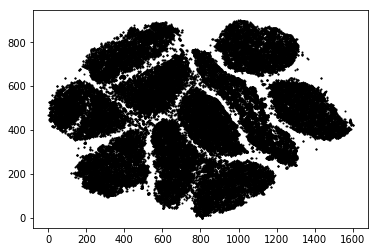

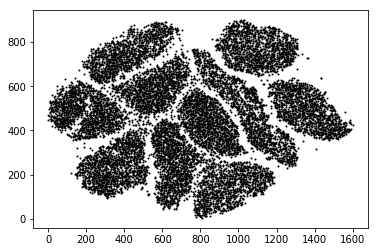

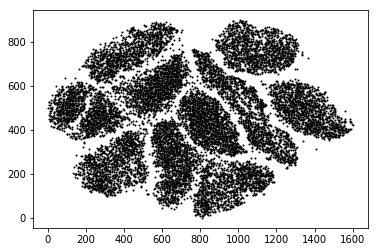

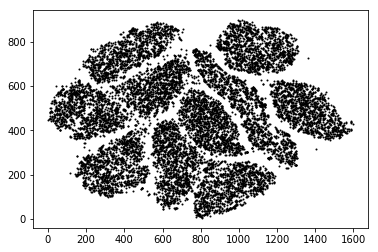

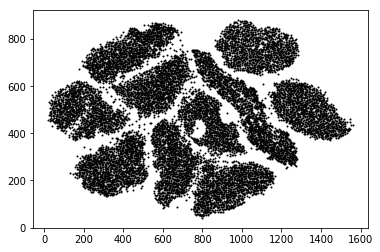

0.8609, 0.8838, 0.8506, 0.7556
0.9364, 0.8297, 0.8202, 0.7925
0.1699, 1.1208, 1.2091, 1.6595
0.0117, 0.0191, 0.0286, 0.0870


In [39]:
selected_labels = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
mnist = read_file('./evaluation_data/mnist/origin.csv')
mnist_result_our = read_file('./evaluation_data/mnist/6_6_002_002_4.csv')
mnist_result_non_uniform = read_file('./evaluation_data/mnist/6_6_8.csv')
mnist_result_random = read_file('./evaluation_data/mnist/6_12500.csv')
mnist_result_weichen = read_file('./evaluation_data/mnist/6_omega400_dt5.csv')
mnist_result_weichen[0][:, 1] *= -1
mnist_range = Range2D(*np.amin(mnist[0], axis=0), *np.amax(mnist[0], axis=0))
mnist_sa = get_sample_areas(mnist, mnist_range)
mnist_our_sa = get_sample_areas(mnist_result_our, mnist_range)
mnist_non_uniform_sa = get_sample_areas(mnist_result_non_uniform, mnist_range)
mnist_random_sa = get_sample_areas(mnist_result_random, mnist_range)
mnist_weichen_sa = get_sample_areas(mnist_result_weichen, weichen_range)
origin_point_num = sum(map(lambda x: mnist_sa[x].data_density, mnist_sa))
pddr_list.append((PDDr(mnist_sa, mnist_our_sa), PDDr(mnist_sa, mnist_non_uniform_sa), 
      PDDr(mnist_sa, mnist_random_sa), PDDr(mnist_sa, mnist_weichen_sa)))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list[-1][0], pddr_list[-1][1], pddr_list[-1][2], pddr_list[-1][3]))
pcdr_list.append((PCDr(mnist_sa, mnist_our_sa), PCDr(mnist_sa, mnist_non_uniform_sa), 
      PCDr(mnist_sa, mnist_random_sa), PCDr(mnist_sa, mnist_weichen_sa)))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pcdr_list[-1][0], pcdr_list[-1][1], pcdr_list[-1][2], pcdr_list[-1][3]))
lc_list.append((LC(mnist_sa, mnist_our_sa), LC(mnist_sa, mnist_non_uniform_sa), 
      LC(mnist_sa, mnist_random_sa), LC(mnist_sa, mnist_weichen_sa)))
print('%.4f, %.4f, %.4f, %.4f' % 
      (lc_list[-1][0], lc_list[-1][1], lc_list[-1][2], lc_list[-1][3]))
esar_list.append((esar(mnist_sa, mnist_our_sa), esar(mnist_sa, mnist_non_uniform_sa), 
      esar(mnist_sa, mnist_random_sa), esar(mnist_sa, mnist_weichen_sa)))
print('%.4f, %.4f, %.4f, %.4f' % 
      (esar_list[-1][0], esar_list[-1][1], esar_list[-1][2], esar_list[-1][3]))

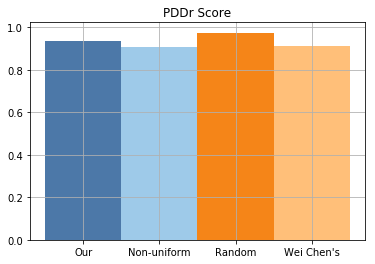

In [35]:
pos = 0.1
width = 0.2

data = pddr_list[1]
# Plotting the bars
fig, ax = plt.subplots()

# Create a bar with pre_score data,
# in position pos,
plt.bar([pos+width*i for i in range(len(data))], data, width, color=colors)

ax.set_title('PDDr Score')

# Set the position of the x ticks
ax.set_xticks([pos+width*i for i in range(len(data))])

# Set the labels for the x ticks
#ax.tick_params(axis='x', rotation=45)
ax.set_xticklabels(method_name)

plt.grid()
plt.savefig('cluster_3 PDDr.pdf')

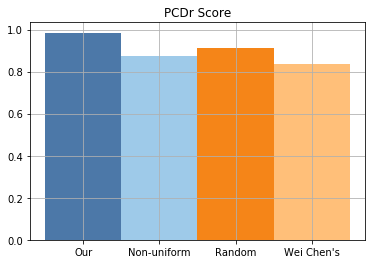

In [36]:
pos = 0.1
width = 0.2

data = pcdr_list[1]
# Plotting the bars
fig, ax = plt.subplots()

# Create a bar with pre_score data,
# in position pos,
plt.bar([pos+width*i for i in range(len(data))], data, width, color=colors)

ax.set_title('PCDr Score')

# Set the position of the x ticks
ax.set_xticks([pos+width*i for i in range(len(data))])

# Set the labels for the x ticks
#ax.tick_params(axis='x', rotation=45)
ax.set_xticklabels(method_name)

plt.grid()
plt.savefig('cluster_3 PCDr.pdf')

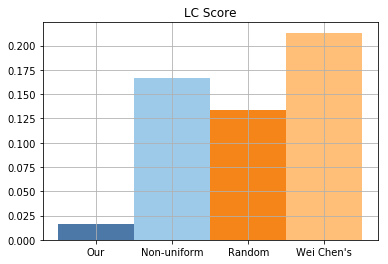

In [37]:
pos = 0.1
width = 0.2

data = lc_list[1]
# Plotting the bars
fig, ax = plt.subplots()

# Create a bar with pre_score data,
# in position pos,
plt.bar([pos+width*i for i in range(len(data))], data, width, color=colors)

ax.set_title('LC Score')

# Set the position of the x ticks
ax.set_xticks([pos+width*i for i in range(len(data))])

# Set the labels for the x ticks
#ax.tick_params(axis='x', rotation=45)
ax.set_xticklabels(method_name)

plt.grid()
plt.savefig('cluster_3 LC.pdf')

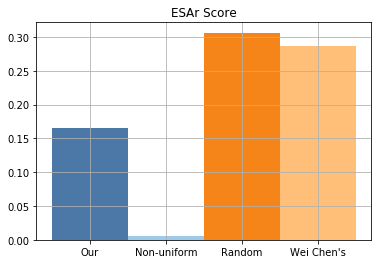

In [38]:
pos = 0.1
width = 0.2

data = esar_list[1]
# Plotting the bars
fig, ax = plt.subplots()

# Create a bar with pre_score data,
# in position pos,
plt.bar([pos+width*i for i in range(len(data))], data, width, color=colors)

ax.set_title('ESAr Score')

# Set the position of the x ticks
ax.set_xticks([pos+width*i for i in range(len(data))])

# Set the labels for the x ticks
#ax.tick_params(axis='x', rotation=45)
ax.set_xticklabels(method_name)

plt.grid()
plt.savefig('cluster_3 ESAr.pdf')

In [40]:
pddr_list2 = []
pcdr_list2 = []
lc_list2 = []
esar_list2 = []

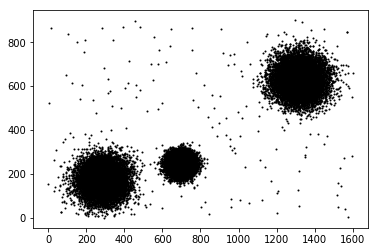

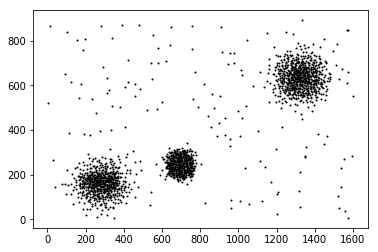

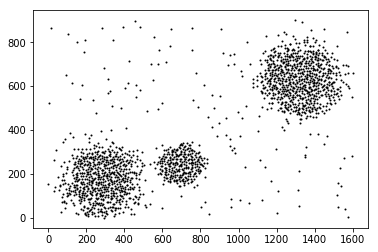

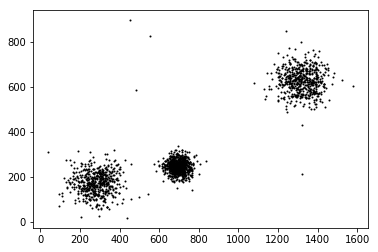

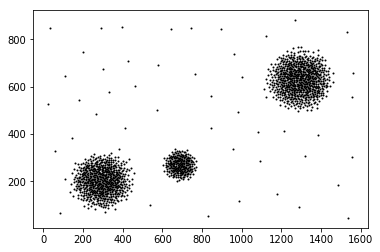

0.9619, 0.9842, 0.0231, 0.1018
0.8710, 0.9352, 0.1136, 0.0074
0.9635, 0.9285, 0.1363, 0.2386
0.9014, 0.8925, 0.1659, 0.2195


In [45]:
selected_labels = {1,2,3}
synthetic_3_1 = read_file('./evaluation_data/synthetic_3_1/origin.csv')
synthetic_3_1_result_our = read_file('./evaluation_data/synthetic_3_1/6_6_002_002_4.csv')
synthetic_3_1_result_non_uniform = read_file('./evaluation_data/synthetic_3_1/6_11_8.csv')
synthetic_3_1_result_random = read_file('./evaluation_data/synthetic_3_1/6_1800.csv')
synthetic_3_1_result_weichen = read_file('./evaluation_data/synthetic_3_1/6_omega500_dt5.csv')
synthetic_3_1_result_weichen[0][:, 1] *= -1
synthetic_3_1_range = Range2D(*np.amin(synthetic_3_1[0], axis=0), *np.amax(synthetic_3_1[0], axis=0))
synthetic_3_1_sa = get_sample_areas(synthetic_3_1, synthetic_3_1_range)
synthetic_3_1_our_sa = get_sample_areas(synthetic_3_1_result_our, synthetic_3_1_range)
synthetic_3_1_non_uniform_sa = get_sample_areas(synthetic_3_1_result_non_uniform, synthetic_3_1_range)
synthetic_3_1_random_sa = get_sample_areas(synthetic_3_1_result_random, synthetic_3_1_range)
synthetic_3_1_weichen_sa = get_sample_areas(synthetic_3_1_result_weichen, weichen_range)
origin_point_num = sum(map(lambda x: synthetic_3_1_sa[x].data_density, synthetic_3_1_sa))
pddr_list2.append((PDDr(synthetic_3_1_sa, synthetic_3_1_our_sa), PDDr(synthetic_3_1_sa, synthetic_3_1_non_uniform_sa), 
      PDDr(synthetic_3_1_sa, synthetic_3_1_random_sa), PDDr(synthetic_3_1_sa, synthetic_3_1_weichen_sa)))
pcdr_list2.append((PCDr(synthetic_3_1_sa, synthetic_3_1_our_sa), PCDr(synthetic_3_1_sa, synthetic_3_1_non_uniform_sa), 
      PCDr(synthetic_3_1_sa, synthetic_3_1_random_sa), PCDr(synthetic_3_1_sa, synthetic_3_1_weichen_sa)))
lc_list2.append((LC(synthetic_3_1_sa, synthetic_3_1_our_sa), LC(synthetic_3_1_sa, synthetic_3_1_non_uniform_sa), 
      LC(synthetic_3_1_sa, synthetic_3_1_random_sa), LC(synthetic_3_1_sa, synthetic_3_1_weichen_sa)))
esar_list2.append((esar(synthetic_3_1_sa, synthetic_3_1_our_sa), esar(synthetic_3_1_sa, synthetic_3_1_non_uniform_sa), 
      esar(synthetic_3_1_sa, synthetic_3_1_random_sa), esar(synthetic_3_1_sa, synthetic_3_1_weichen_sa)))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list2[-1][0], pcdr_list2[-1][0], lc_list2[-1][0], esar_list2[-1][0]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list2[-1][1], pcdr_list2[-1][1], lc_list2[-1][1], esar_list2[-1][1]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list2[-1][2], pcdr_list2[-1][2], lc_list2[-1][2], esar_list2[-1][2]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list2[-1][3], pcdr_list2[-1][3], lc_list2[-1][3], esar_list2[-1][3]))

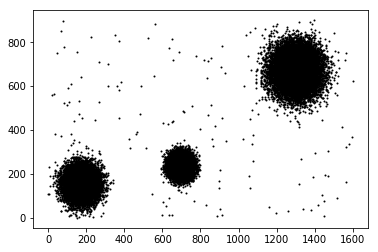

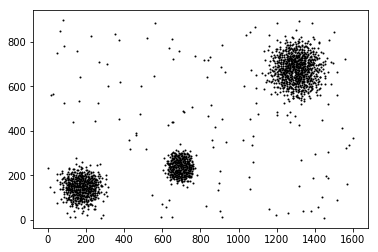

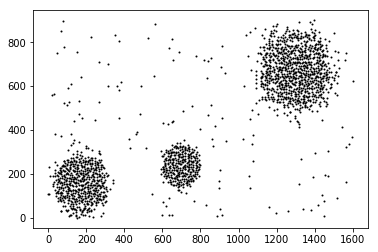

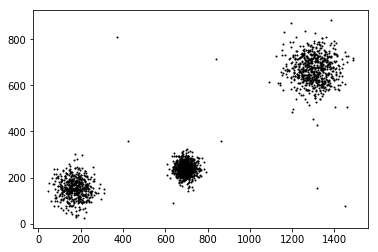

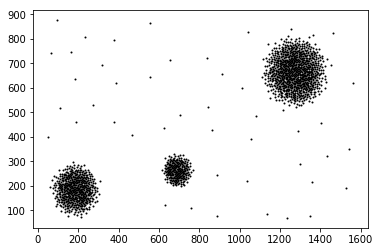

0.9647, 0.9954, 0.0093, 0.0785
0.9014, 0.9516, 0.0967, 0.0032
0.9741, 0.9392, 0.1218, 0.1962
0.8887, 0.8933, 0.1600, 0.1771


In [46]:
selected_labels = {1,2,3}
synthetic_3_7 = read_file('./evaluation_data/synthetic_3_7/origin.csv')
synthetic_3_7_result_our = read_file('./evaluation_data/synthetic_3_7/6_6_002_002_4.csv')
synthetic_3_7_result_non_uniform = read_file('./evaluation_data/synthetic_3_7/6_10_8.csv')
synthetic_3_7_result_random = read_file('./evaluation_data/synthetic_3_7/6_1850.csv')
synthetic_3_7_result_weichen = read_file('./evaluation_data/synthetic_3_7/6_omega460_dt5.csv')
synthetic_3_7_result_weichen[0][:, 1] *= -1
synthetic_3_7_range = Range2D(*np.amin(synthetic_3_7[0], axis=0), *np.amax(synthetic_3_7[0], axis=0))
synthetic_3_7_sa = get_sample_areas(synthetic_3_7, synthetic_3_7_range)
synthetic_3_7_our_sa = get_sample_areas(synthetic_3_7_result_our, synthetic_3_7_range)
synthetic_3_7_non_uniform_sa = get_sample_areas(synthetic_3_7_result_non_uniform, synthetic_3_7_range)
synthetic_3_7_random_sa = get_sample_areas(synthetic_3_7_result_random, synthetic_3_7_range)
synthetic_3_7_weichen_sa = get_sample_areas(synthetic_3_7_result_weichen, weichen_range)
origin_point_num = sum(map(lambda x: synthetic_3_7_sa[x].data_density, synthetic_3_7_sa))
pddr_list2.append((PDDr(synthetic_3_7_sa, synthetic_3_7_our_sa), PDDr(synthetic_3_7_sa, synthetic_3_7_non_uniform_sa), 
      PDDr(synthetic_3_7_sa, synthetic_3_7_random_sa), PDDr(synthetic_3_7_sa, synthetic_3_7_weichen_sa)))
pcdr_list2.append((PCDr(synthetic_3_7_sa, synthetic_3_7_our_sa), PCDr(synthetic_3_7_sa, synthetic_3_7_non_uniform_sa), 
      PCDr(synthetic_3_7_sa, synthetic_3_7_random_sa), PCDr(synthetic_3_7_sa, synthetic_3_7_weichen_sa)))
lc_list2.append((LC(synthetic_3_7_sa, synthetic_3_7_our_sa), LC(synthetic_3_7_sa, synthetic_3_7_non_uniform_sa), 
      LC(synthetic_3_7_sa, synthetic_3_7_random_sa), LC(synthetic_3_7_sa, synthetic_3_7_weichen_sa)))
esar_list2.append((esar(synthetic_3_7_sa, synthetic_3_7_our_sa), esar(synthetic_3_7_sa, synthetic_3_7_non_uniform_sa), 
      esar(synthetic_3_7_sa, synthetic_3_7_random_sa), esar(synthetic_3_7_sa, synthetic_3_7_weichen_sa)))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list2[-1][0], pcdr_list2[-1][0], lc_list2[-1][0], esar_list2[-1][0]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list2[-1][1], pcdr_list2[-1][1], lc_list2[-1][1], esar_list2[-1][1]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list2[-1][2], pcdr_list2[-1][2], lc_list2[-1][2], esar_list2[-1][2]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list2[-1][3], pcdr_list2[-1][3], lc_list2[-1][3], esar_list2[-1][3]))

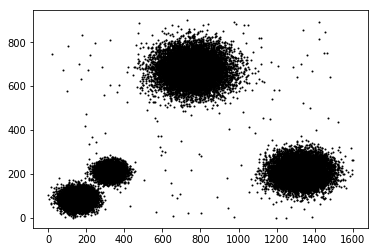

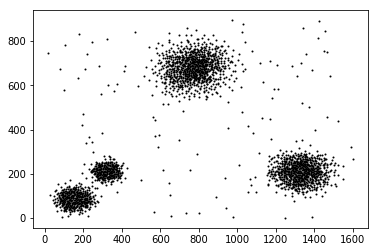

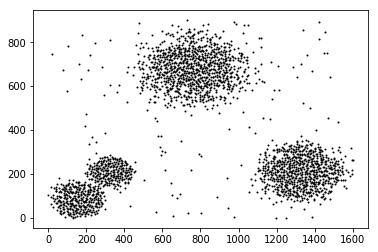

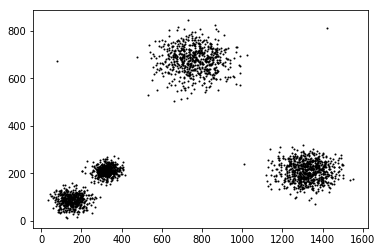

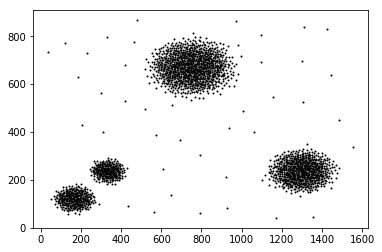

0.9581, 0.9898, 0.0185, 0.1071
0.8811, 0.9209, 0.2004, 0.0042
0.9626, 0.9140, 0.2073, 0.2227
0.8781, 0.9053, 0.2524, 0.2047


In [47]:
selected_labels = {1,2,3,4}
synthetic_4_20 = read_file('./evaluation_data/synthetic_4_20/origin.csv')
synthetic_4_20_result_our = read_file('./evaluation_data/synthetic_4_20/6_6_002_002_4.csv')
synthetic_4_20_result_non_uniform = read_file('./evaluation_data/synthetic_4_20/6_10_8.csv')
synthetic_4_20_result_random = read_file('./evaluation_data/synthetic_4_20/6_2400.csv')
synthetic_4_20_result_weichen = read_file('./evaluation_data/synthetic_4_20/6_omega450_dt5.csv')
synthetic_4_20_result_weichen[0][:, 1] *= -1
synthetic_4_20_range = Range2D(*np.amin(synthetic_4_20[0], axis=0), *np.amax(synthetic_4_20[0], axis=0))
synthetic_4_20_sa = get_sample_areas(synthetic_4_20, synthetic_4_20_range)
synthetic_4_20_our_sa = get_sample_areas(synthetic_4_20_result_our, synthetic_4_20_range)
synthetic_4_20_non_uniform_sa = get_sample_areas(synthetic_4_20_result_non_uniform, synthetic_4_20_range)
synthetic_4_20_random_sa = get_sample_areas(synthetic_4_20_result_random, synthetic_4_20_range)
synthetic_4_20_weichen_sa = get_sample_areas(synthetic_4_20_result_weichen, weichen_range)
origin_point_num = sum(map(lambda x: synthetic_4_20_sa[x].data_density, synthetic_4_20_sa))
pddr_list2.append((PDDr(synthetic_4_20_sa, synthetic_4_20_our_sa), PDDr(synthetic_4_20_sa, synthetic_4_20_non_uniform_sa), 
      PDDr(synthetic_4_20_sa, synthetic_4_20_random_sa), PDDr(synthetic_4_20_sa, synthetic_4_20_weichen_sa)))
pcdr_list2.append((PCDr(synthetic_4_20_sa, synthetic_4_20_our_sa), PCDr(synthetic_4_20_sa, synthetic_4_20_non_uniform_sa), 
      PCDr(synthetic_4_20_sa, synthetic_4_20_random_sa), PCDr(synthetic_4_20_sa, synthetic_4_20_weichen_sa)))
lc_list2.append((LC(synthetic_4_20_sa, synthetic_4_20_our_sa), LC(synthetic_4_20_sa, synthetic_4_20_non_uniform_sa), 
      LC(synthetic_4_20_sa, synthetic_4_20_random_sa), LC(synthetic_4_20_sa, synthetic_4_20_weichen_sa)))
esar_list2.append((esar(synthetic_4_20_sa, synthetic_4_20_our_sa), esar(synthetic_4_20_sa, synthetic_4_20_non_uniform_sa), 
      esar(synthetic_4_20_sa, synthetic_4_20_random_sa), esar(synthetic_4_20_sa, synthetic_4_20_weichen_sa)))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list2[-1][0], pcdr_list2[-1][0], lc_list2[-1][0], esar_list2[-1][0]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list2[-1][1], pcdr_list2[-1][1], lc_list2[-1][1], esar_list2[-1][1]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list2[-1][2], pcdr_list2[-1][2], lc_list2[-1][2], esar_list2[-1][2]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list2[-1][3], pcdr_list2[-1][3], lc_list2[-1][3], esar_list2[-1][3]))

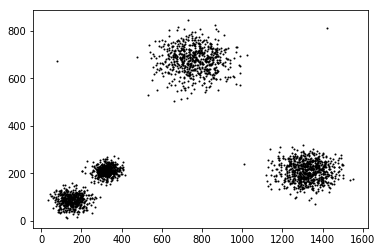

0.9581, 0.8811, 0.9626, 0.8781
0.9898, 0.9209, 0.9140, 0.9053
0.0185, 0.2004, 0.2073, 0.2524
0.1071, 0.0042, 0.2227, 0.2047


In [45]:
synthetic_4_20_result_random = read_file('./evaluation_data/synthetic_4_20/6_2400.csv')
synthetic_4_20_random_sa = get_sample_areas(synthetic_4_20_result_random, synthetic_4_20_range)
origin_point_num = sum(map(lambda x: synthetic_4_20_sa[x].data_density, synthetic_4_20_sa))
print('%.4f, %.4f, %.4f, %.4f' % 
      (PDDr(synthetic_4_20_sa, synthetic_4_20_our_sa), PDDr(synthetic_4_20_sa, synthetic_4_20_non_uniform_sa), 
      PDDr(synthetic_4_20_sa, synthetic_4_20_random_sa), PDDr(synthetic_4_20_sa, synthetic_4_20_weichen_sa)))
print('%.4f, %.4f, %.4f, %.4f' % 
      (PCDr(synthetic_4_20_sa, synthetic_4_20_our_sa), PCDr(synthetic_4_20_sa, synthetic_4_20_non_uniform_sa), 
      PCDr(synthetic_4_20_sa, synthetic_4_20_random_sa), PCDr(synthetic_4_20_sa, synthetic_4_20_weichen_sa)))
print('%.4f, %.4f, %.4f, %.4f' % 
      (LC(synthetic_4_20_sa, synthetic_4_20_our_sa), LC(synthetic_4_20_sa, synthetic_4_20_non_uniform_sa), 
      LC(synthetic_4_20_sa, synthetic_4_20_random_sa), LC(synthetic_4_20_sa, synthetic_4_20_weichen_sa)))
print('%.4f, %.4f, %.4f, %.4f' % 
      (esar(synthetic_4_20_sa, synthetic_4_20_our_sa), esar(synthetic_4_20_sa, synthetic_4_20_non_uniform_sa), 
      esar(synthetic_4_20_sa, synthetic_4_20_random_sa), esar(synthetic_4_20_sa, synthetic_4_20_weichen_sa)))

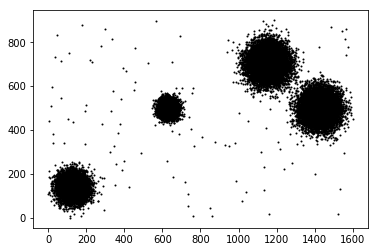

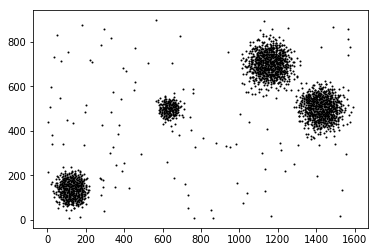

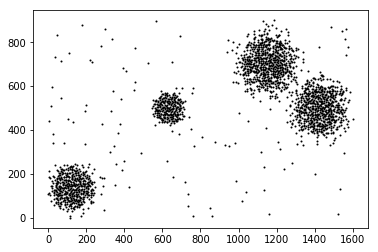

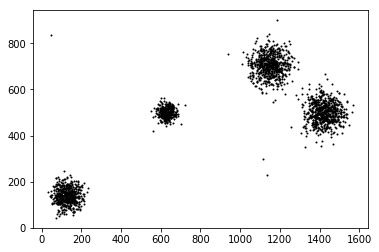

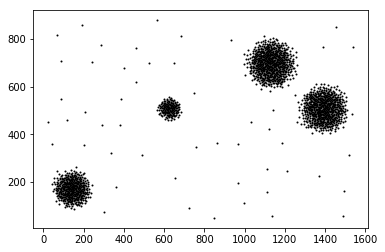

0.9595, 0.9971, 0.0066, 0.0604
0.9270, 0.9825, 0.0567, 0.0064
0.9695, 0.9778, 0.0731, 0.1750
0.9085, 0.9716, 0.0933, 0.1474


In [48]:
selected_labels = {1,2,3,4}
synthetic_4_29 = read_file('./evaluation_data/synthetic_4_29/origin.csv')
synthetic_4_29_result_our = read_file('./evaluation_data/synthetic_4_29/6_6_002_002_4.csv')
synthetic_4_29_result_non_uniform = read_file('./evaluation_data/synthetic_4_29/6_8_8.csv')
synthetic_4_29_result_random = read_file('./evaluation_data/synthetic_4_29/6_2150.csv')
synthetic_4_29_result_weichen = read_file('./evaluation_data/synthetic_4_29/6_omega400_dt5.csv')
synthetic_4_29_result_weichen[0][:, 1] *= -1
synthetic_4_29_range = Range2D(*np.amin(synthetic_4_29[0], axis=0), *np.amax(synthetic_4_29[0], axis=0))
synthetic_4_29_sa = get_sample_areas(synthetic_4_29, synthetic_4_29_range)
synthetic_4_29_our_sa = get_sample_areas(synthetic_4_29_result_our, synthetic_4_29_range)
synthetic_4_29_non_uniform_sa = get_sample_areas(synthetic_4_29_result_non_uniform, synthetic_4_29_range)
synthetic_4_29_random_sa = get_sample_areas(synthetic_4_29_result_random, synthetic_4_29_range)
synthetic_4_29_weichen_sa = get_sample_areas(synthetic_4_29_result_weichen, weichen_range)
origin_point_num = sum(map(lambda x: synthetic_4_29_sa[x].data_density, synthetic_4_29_sa))
pddr_list2.append((PDDr(synthetic_4_29_sa, synthetic_4_29_our_sa), PDDr(synthetic_4_29_sa, synthetic_4_29_non_uniform_sa), 
      PDDr(synthetic_4_29_sa, synthetic_4_29_random_sa), PDDr(synthetic_4_29_sa, synthetic_4_29_weichen_sa)))
pcdr_list2.append((PCDr(synthetic_4_29_sa, synthetic_4_29_our_sa), PCDr(synthetic_4_29_sa, synthetic_4_29_non_uniform_sa), 
      PCDr(synthetic_4_29_sa, synthetic_4_29_random_sa), PCDr(synthetic_4_29_sa, synthetic_4_29_weichen_sa)))
lc_list2.append((LC(synthetic_4_29_sa, synthetic_4_29_our_sa), LC(synthetic_4_29_sa, synthetic_4_29_non_uniform_sa), 
      LC(synthetic_4_29_sa, synthetic_4_29_random_sa), LC(synthetic_4_29_sa, synthetic_4_29_weichen_sa)))
esar_list2.append((esar(synthetic_4_29_sa, synthetic_4_29_our_sa), esar(synthetic_4_29_sa, synthetic_4_29_non_uniform_sa), 
      esar(synthetic_4_29_sa, synthetic_4_29_random_sa), esar(synthetic_4_29_sa, synthetic_4_29_weichen_sa)))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list2[-1][0], pcdr_list2[-1][0], lc_list2[-1][0], esar_list2[-1][0]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list2[-1][1], pcdr_list2[-1][1], lc_list2[-1][1], esar_list2[-1][1]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list2[-1][2], pcdr_list2[-1][2], lc_list2[-1][2], esar_list2[-1][2]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list2[-1][3], pcdr_list2[-1][3], lc_list2[-1][3], esar_list2[-1][3]))

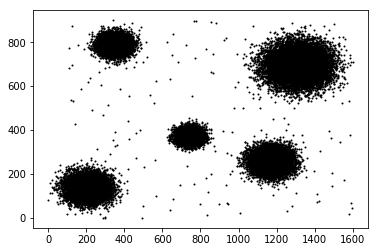

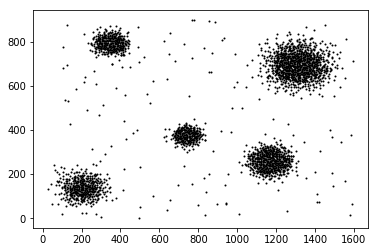

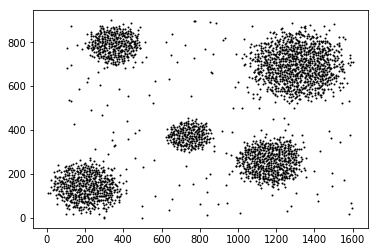

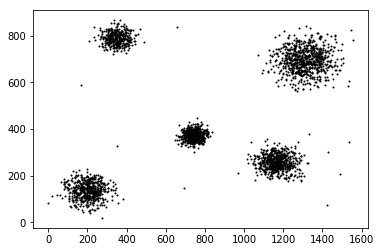

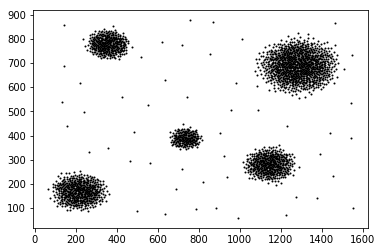

0.9536, 0.9916, 0.0157, 0.0997
0.8957, 0.9430, 0.1886, 0.0032
0.9675, 0.9439, 0.1858, 0.2291
0.8996, 0.9283, 0.2369, 0.2121


In [49]:
selected_labels = {1,2,3,4,5}
synthetic_5_1 = read_file('./evaluation_data/synthetic_5_1/origin.csv')
synthetic_5_1_result_our = read_file('./evaluation_data/synthetic_5_1/6_6_002_002_4.csv')
synthetic_5_1_result_non_uniform = read_file('./evaluation_data/synthetic_5_1/6_9_8.csv')
synthetic_5_1_result_random = read_file('./evaluation_data/synthetic_5_1/6_2800.csv')
synthetic_5_1_result_weichen = read_file('./evaluation_data/synthetic_5_1/6_omega420_dt5.csv')
synthetic_5_1_result_weichen[0][:, 1] *= -1
synthetic_5_1_range = Range2D(*np.amin(synthetic_5_1[0], axis=0), *np.amax(synthetic_5_1[0], axis=0))
synthetic_5_1_sa = get_sample_areas(synthetic_5_1, synthetic_5_1_range)
synthetic_5_1_our_sa = get_sample_areas(synthetic_5_1_result_our, synthetic_5_1_range)
synthetic_5_1_non_uniform_sa = get_sample_areas(synthetic_5_1_result_non_uniform, synthetic_5_1_range)
synthetic_5_1_random_sa = get_sample_areas(synthetic_5_1_result_random, synthetic_5_1_range)
synthetic_5_1_weichen_sa = get_sample_areas(synthetic_5_1_result_weichen, weichen_range)
origin_point_num = sum(map(lambda x: synthetic_5_1_sa[x].data_density, synthetic_5_1_sa))
pddr_list2.append((PDDr(synthetic_5_1_sa, synthetic_5_1_our_sa), PDDr(synthetic_5_1_sa, synthetic_5_1_non_uniform_sa), 
      PDDr(synthetic_5_1_sa, synthetic_5_1_random_sa), PDDr(synthetic_5_1_sa, synthetic_5_1_weichen_sa)))
pcdr_list2.append((PCDr(synthetic_5_1_sa, synthetic_5_1_our_sa), PCDr(synthetic_5_1_sa, synthetic_5_1_non_uniform_sa), 
      PCDr(synthetic_5_1_sa, synthetic_5_1_random_sa), PCDr(synthetic_5_1_sa, synthetic_5_1_weichen_sa)))
lc_list2.append((LC(synthetic_5_1_sa, synthetic_5_1_our_sa), LC(synthetic_5_1_sa, synthetic_5_1_non_uniform_sa), 
      LC(synthetic_5_1_sa, synthetic_5_1_random_sa), LC(synthetic_5_1_sa, synthetic_5_1_weichen_sa)))
esar_list2.append((esar(synthetic_5_1_sa, synthetic_5_1_our_sa), esar(synthetic_5_1_sa, synthetic_5_1_non_uniform_sa), 
      esar(synthetic_5_1_sa, synthetic_5_1_random_sa), esar(synthetic_5_1_sa, synthetic_5_1_weichen_sa)))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list2[-1][0], pcdr_list2[-1][0], lc_list2[-1][0], esar_list2[-1][0]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list2[-1][1], pcdr_list2[-1][1], lc_list2[-1][1], esar_list2[-1][1]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list2[-1][2], pcdr_list2[-1][2], lc_list2[-1][2], esar_list2[-1][2]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list2[-1][3], pcdr_list2[-1][3], lc_list2[-1][3], esar_list2[-1][3]))

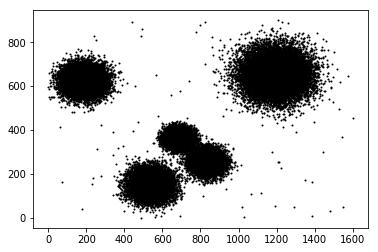

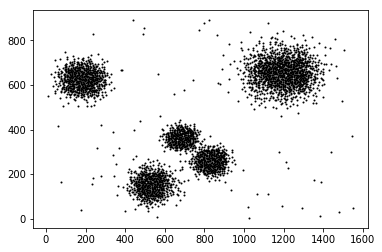

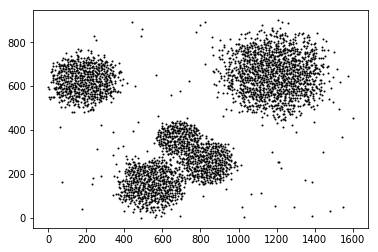

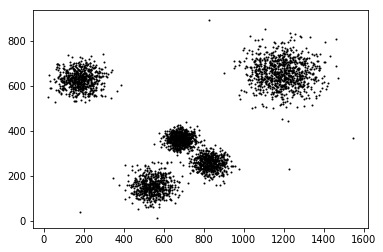

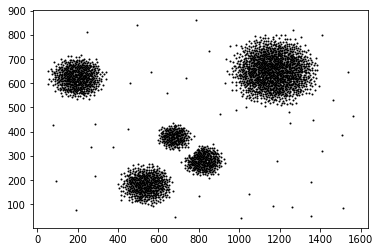

0.9532, 0.9908, 0.0121, 0.1050
0.8701, 0.9540, 0.1187, 0.0021
0.9651, 0.9392, 0.1456, 0.1782
0.8936, 0.9251, 0.1781, 0.1962


In [50]:
selected_labels = {1,2,3,4,5}
synthetic_5_10 = read_file('./evaluation_data/synthetic_5_10/origin.csv')
synthetic_5_10_result_our = read_file('./evaluation_data/synthetic_5_10/6_6_002_002_4.csv')
synthetic_5_10_result_non_uniform = read_file('./evaluation_data/synthetic_5_10/6_9_8.csv')
synthetic_5_10_result_random = read_file('./evaluation_data/synthetic_5_10/6_3400.csv')
synthetic_5_10_result_weichen = read_file('./evaluation_data/synthetic_5_10/6_omega400_dt5.csv')
synthetic_5_10_result_weichen[0][:, 1] *= -1
synthetic_5_10_range = Range2D(*np.amin(synthetic_5_10[0], axis=0), *np.amax(synthetic_5_10[0], axis=0))
synthetic_5_10_sa = get_sample_areas(synthetic_5_10, synthetic_5_10_range)
synthetic_5_10_our_sa = get_sample_areas(synthetic_5_10_result_our, synthetic_5_10_range)
synthetic_5_10_non_uniform_sa = get_sample_areas(synthetic_5_10_result_non_uniform, synthetic_5_10_range)
synthetic_5_10_random_sa = get_sample_areas(synthetic_5_10_result_random, synthetic_5_10_range)
synthetic_5_10_weichen_sa = get_sample_areas(synthetic_5_10_result_weichen, weichen_range)
origin_point_num = sum(map(lambda x: synthetic_5_10_sa[x].data_density, synthetic_5_10_sa))
pddr_list2.append((PDDr(synthetic_5_10_sa, synthetic_5_10_our_sa), PDDr(synthetic_5_10_sa, synthetic_5_10_non_uniform_sa), 
      PDDr(synthetic_5_10_sa, synthetic_5_10_random_sa), PDDr(synthetic_5_10_sa, synthetic_5_10_weichen_sa)))
pcdr_list2.append((PCDr(synthetic_5_10_sa, synthetic_5_10_our_sa), PCDr(synthetic_5_10_sa, synthetic_5_10_non_uniform_sa), 
      PCDr(synthetic_5_10_sa, synthetic_5_10_random_sa), PCDr(synthetic_5_10_sa, synthetic_5_10_weichen_sa)))
lc_list2.append((LC(synthetic_5_10_sa, synthetic_5_10_our_sa), LC(synthetic_5_10_sa, synthetic_5_10_non_uniform_sa), 
      LC(synthetic_5_10_sa, synthetic_5_10_random_sa), LC(synthetic_5_10_sa, synthetic_5_10_weichen_sa)))
esar_list2.append((esar(synthetic_5_10_sa, synthetic_5_10_our_sa), esar(synthetic_5_10_sa, synthetic_5_10_non_uniform_sa), 
      esar(synthetic_5_10_sa, synthetic_5_10_random_sa), esar(synthetic_5_10_sa, synthetic_5_10_weichen_sa)))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list2[-1][0], pcdr_list2[-1][0], lc_list2[-1][0], esar_list2[-1][0]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list2[-1][1], pcdr_list2[-1][1], lc_list2[-1][1], esar_list2[-1][1]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list2[-1][2], pcdr_list2[-1][2], lc_list2[-1][2], esar_list2[-1][2]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list2[-1][3], pcdr_list2[-1][3], lc_list2[-1][3], esar_list2[-1][3]))

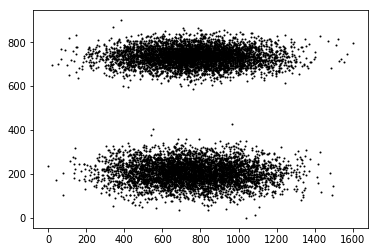

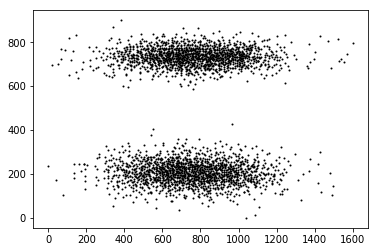

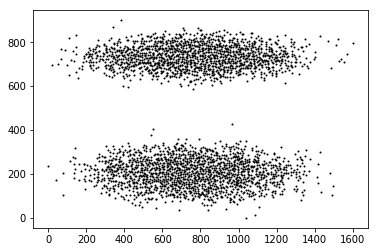

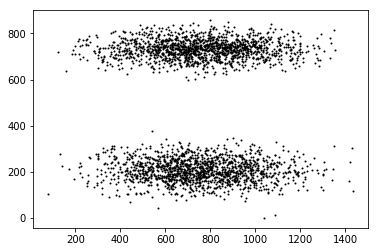

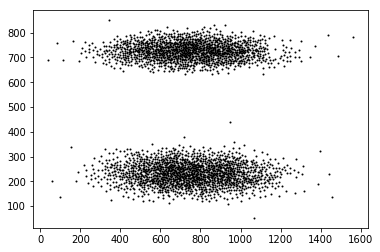

0.9453, 0.9848, 0.0225, 0.0530
0.8879, 0.9996, 0.2165, 0.0021
0.9327, 0.9782, 0.2421, 0.1135
0.8929, 0.9386, 0.3395, 0.1400


In [41]:
selected_labels = {0,1}
synthesis2 = read_file('./evaluation_data/synthesis2/origin.csv')
synthesis2_result_our = read_file('./evaluation_data/synthesis2/6_6_002_002_4.csv')
synthesis2_result_non_uniform = read_file('./evaluation_data/synthesis2/6_10_8.csv')
synthesis2_result_random = read_file('./evaluation_data/synthesis2/6_2900.csv')
synthesis2_result_weichen = read_file('./evaluation_data/synthesis2/6_omega360_dt5.csv')
synthesis2_result_weichen[0][:, 1] *= -1
synthesis2_range = Range2D(*np.amin(synthesis2[0], axis=0), *np.amax(synthesis2[0], axis=0))
synthesis2_sa = get_sample_areas(synthesis2, synthesis2_range)
synthesis2_our_sa = get_sample_areas(synthesis2_result_our, synthesis2_range)
synthesis2_non_uniform_sa = get_sample_areas(synthesis2_result_non_uniform, synthesis2_range)
synthesis2_random_sa = get_sample_areas(synthesis2_result_random, synthesis2_range)
synthesis2_weichen_sa = get_sample_areas(synthesis2_result_weichen, weichen_range)
origin_point_num = sum(map(lambda x: synthesis2_sa[x].data_density, synthesis2_sa))
pddr_list2.append((PDDr(synthesis2_sa, synthesis2_our_sa), PDDr(synthesis2_sa, synthesis2_non_uniform_sa), 
      PDDr(synthesis2_sa, synthesis2_random_sa), PDDr(synthesis2_sa, synthesis2_weichen_sa)))
pcdr_list2.append((PCDr(synthesis2_sa, synthesis2_our_sa), PCDr(synthesis2_sa, synthesis2_non_uniform_sa), 
      PCDr(synthesis2_sa, synthesis2_random_sa), PCDr(synthesis2_sa, synthesis2_weichen_sa)))
lc_list2.append((LC(synthesis2_sa, synthesis2_our_sa), LC(synthesis2_sa, synthesis2_non_uniform_sa), 
      LC(synthesis2_sa, synthesis2_random_sa), LC(synthesis2_sa, synthesis2_weichen_sa)))
esar_list2.append((esar(synthesis2_sa, synthesis2_our_sa), esar(synthesis2_sa, synthesis2_non_uniform_sa), 
      esar(synthesis2_sa, synthesis2_random_sa), esar(synthesis2_sa, synthesis2_weichen_sa)))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list2[-1][0], pcdr_list2[-1][0], lc_list2[-1][0], esar_list2[-1][0]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list2[-1][1], pcdr_list2[-1][1], lc_list2[-1][1], esar_list2[-1][1]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list2[-1][2], pcdr_list2[-1][2], lc_list2[-1][2], esar_list2[-1][2]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list2[-1][3], pcdr_list2[-1][3], lc_list2[-1][3], esar_list2[-1][3]))

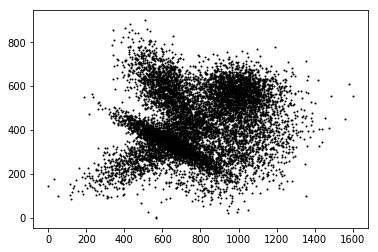

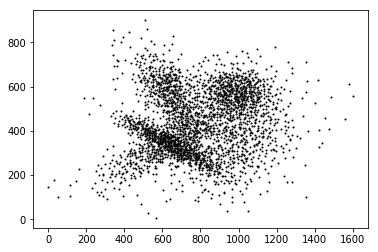

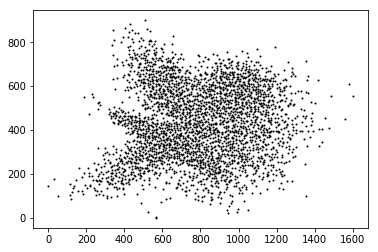

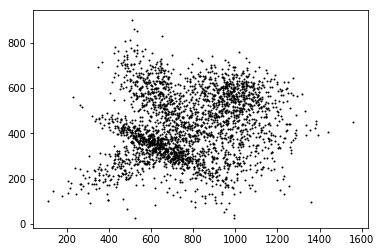

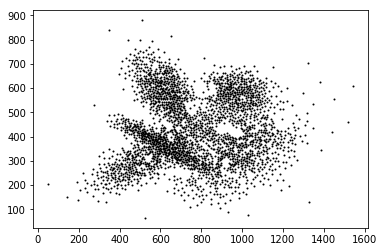

0.9330, 0.8509, 0.1341, 0.0785
0.8637, 0.7138, 0.6874, 0.0032
0.9158, 0.7293, 0.5777, 0.1071
0.8681, 0.6000, 1.0491, 0.1432


In [42]:
selected_labels = {0,1,2,3,4}
synthesis3 = read_file('./evaluation_data/synthesis3/origin.csv')
synthesis3_result_our = read_file('./evaluation_data/synthesis3/6_6_002_002_4.csv')
synthesis3_result_non_uniform = read_file('./evaluation_data/synthesis3/6_11_8.csv')
synthesis3_result_random = read_file('./evaluation_data/synthesis3/6_2700.csv')
synthesis3_result_weichen = read_file('./evaluation_data/synthesis3/6_omega420_dt5.csv')
synthesis3_result_weichen[0][:, 1] *= -1
synthesis3_range = Range2D(*np.amin(synthesis3[0], axis=0), *np.amax(synthesis3[0], axis=0))
synthesis3_sa = get_sample_areas(synthesis3, synthesis3_range)
synthesis3_our_sa = get_sample_areas(synthesis3_result_our, synthesis3_range)
synthesis3_non_uniform_sa = get_sample_areas(synthesis3_result_non_uniform, synthesis3_range)
synthesis3_random_sa = get_sample_areas(synthesis3_result_random, synthesis3_range)
synthesis3_weichen_sa = get_sample_areas(synthesis3_result_weichen, weichen_range)
origin_point_num = sum(map(lambda x: synthesis3_sa[x].data_density, synthesis3_sa))
pddr_list2.append((PDDr(synthesis3_sa, synthesis3_our_sa), PDDr(synthesis3_sa, synthesis3_non_uniform_sa), 
      PDDr(synthesis3_sa, synthesis3_random_sa), PDDr(synthesis3_sa, synthesis3_weichen_sa)))
pcdr_list2.append((PCDr(synthesis3_sa, synthesis3_our_sa), PCDr(synthesis3_sa, synthesis3_non_uniform_sa), 
      PCDr(synthesis3_sa, synthesis3_random_sa), PCDr(synthesis3_sa, synthesis3_weichen_sa)))
lc_list2.append((LC(synthesis3_sa, synthesis3_our_sa), LC(synthesis3_sa, synthesis3_non_uniform_sa), 
      LC(synthesis3_sa, synthesis3_random_sa), LC(synthesis3_sa, synthesis3_weichen_sa)))
esar_list2.append((esar(synthesis3_sa, synthesis3_our_sa), esar(synthesis3_sa, synthesis3_non_uniform_sa), 
      esar(synthesis3_sa, synthesis3_random_sa), esar(synthesis3_sa, synthesis3_weichen_sa)))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list2[-1][0], pcdr_list2[-1][0], lc_list2[-1][0], esar_list2[-1][0]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list2[-1][1], pcdr_list2[-1][1], lc_list2[-1][1], esar_list2[-1][1]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list2[-1][2], pcdr_list2[-1][2], lc_list2[-1][2], esar_list2[-1][2]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list2[-1][3], pcdr_list2[-1][3], lc_list2[-1][3], esar_list2[-1][3]))

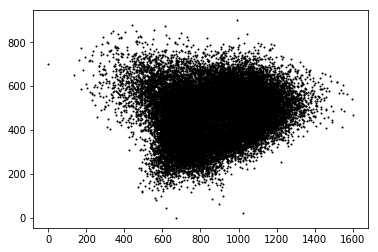

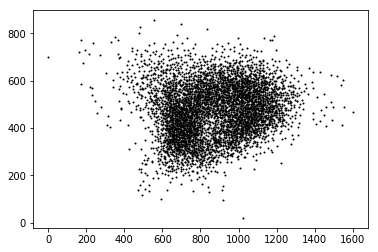

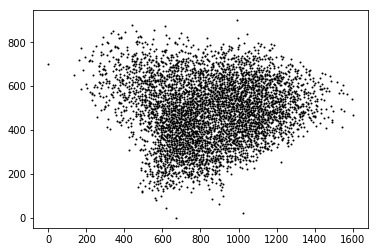

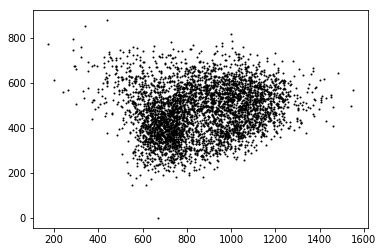

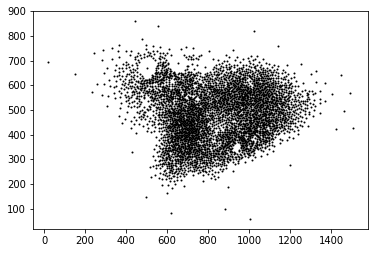

0.9519, 0.6034, 0.3414, 0.0954
0.9145, 0.4952, 1.3610, 0.0021
0.9409, 0.5388, 1.1616, 0.1495
0.9210, 0.4783, 2.0075, 0.1622


In [44]:
selected_labels = {0,1,2,3,4,5}
synthesis7 = read_file('./evaluation_data/synthesis7/origin.csv')
synthesis7_result_our = read_file('./evaluation_data/synthesis7/6_6_002_002_4.csv')
synthesis7_result_non_uniform = read_file('./evaluation_data/synthesis7/6_8_8.csv')
synthesis7_result_random = read_file('./evaluation_data/synthesis7/6_4300.csv')
synthesis7_result_weichen = read_file('./evaluation_data/synthesis7/6_omega390_dt5.csv')
synthesis7_result_weichen[0][:, 1] *= -1
synthesis7_range = Range2D(*np.amin(synthesis7[0], axis=0), *np.amax(synthesis7[0], axis=0))
synthesis7_sa = get_sample_areas(synthesis7, synthesis7_range)
synthesis7_our_sa = get_sample_areas(synthesis7_result_our, synthesis7_range)
synthesis7_non_uniform_sa = get_sample_areas(synthesis7_result_non_uniform, synthesis7_range)
synthesis7_random_sa = get_sample_areas(synthesis7_result_random, synthesis7_range)
synthesis7_weichen_sa = get_sample_areas(synthesis7_result_weichen, weichen_range)
origin_point_num = sum(map(lambda x: synthesis7_sa[x].data_density, synthesis7_sa))
pddr_list2.append((PDDr(synthesis7_sa, synthesis7_our_sa), PDDr(synthesis7_sa, synthesis7_non_uniform_sa), 
      PDDr(synthesis7_sa, synthesis7_random_sa), PDDr(synthesis7_sa, synthesis7_weichen_sa)))
pcdr_list2.append((PCDr(synthesis7_sa, synthesis7_our_sa), PCDr(synthesis7_sa, synthesis7_non_uniform_sa), 
      PCDr(synthesis7_sa, synthesis7_random_sa), PCDr(synthesis7_sa, synthesis7_weichen_sa)))
lc_list2.append((LC(synthesis7_sa, synthesis7_our_sa), LC(synthesis7_sa, synthesis7_non_uniform_sa), 
      LC(synthesis7_sa, synthesis7_random_sa), LC(synthesis7_sa, synthesis7_weichen_sa)))
esar_list2.append((esar(synthesis7_sa, synthesis7_our_sa), esar(synthesis7_sa, synthesis7_non_uniform_sa), 
      esar(synthesis7_sa, synthesis7_random_sa), esar(synthesis7_sa, synthesis7_weichen_sa)))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list2[-1][0], pcdr_list2[-1][0], lc_list2[-1][0], esar_list2[-1][0]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list2[-1][1], pcdr_list2[-1][1], lc_list2[-1][1], esar_list2[-1][1]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list2[-1][2], pcdr_list2[-1][2], lc_list2[-1][2], esar_list2[-1][2]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list2[-1][3], pcdr_list2[-1][3], lc_list2[-1][3], esar_list2[-1][3]))


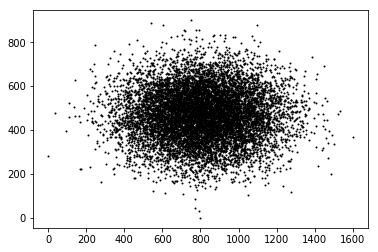

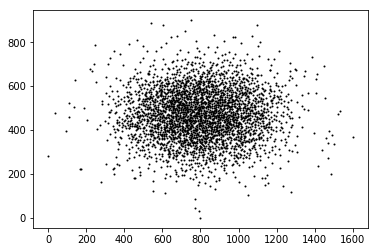

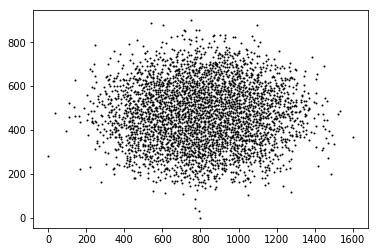

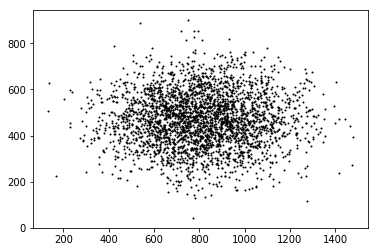

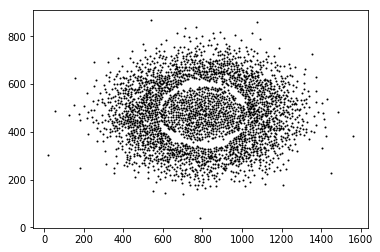

0.9380, 0.9505, 0.0762, 0.0848
0.8940, 0.9484, 0.0575, 0.0000
0.9253, 0.9504, 0.0846, 0.1326
0.7984, 0.8583, 0.1156, 0.0912


In [43]:
selected_labels = {0,1,2}
synthesis4 = read_file('./evaluation_data/synthesis4/origin.csv')
synthesis4_result_our = read_file('./evaluation_data/synthesis4/6_6_002_002_4.csv')
synthesis4_result_non_uniform = read_file('./evaluation_data/synthesis4/6_10_8.csv')
synthesis4_result_random = read_file('./evaluation_data/synthesis4/6_3000.csv')
synthesis4_result_weichen = read_file('./evaluation_data/synthesis4/6_omega480_dt5.csv')
synthesis4_result_weichen[0][:, 1] *= -1
synthesis4_range = Range2D(*np.amin(synthesis4[0], axis=0), *np.amax(synthesis4[0], axis=0))
synthesis4_sa = get_sample_areas(synthesis4, synthesis4_range)
synthesis4_our_sa = get_sample_areas(synthesis4_result_our, synthesis4_range)
synthesis4_non_uniform_sa = get_sample_areas(synthesis4_result_non_uniform, synthesis4_range)
synthesis4_random_sa = get_sample_areas(synthesis4_result_random, synthesis4_range)
synthesis4_weichen_sa = get_sample_areas(synthesis4_result_weichen, weichen_range)
origin_point_num = sum(map(lambda x: synthesis4_sa[x].data_density, synthesis4_sa))
pddr_list2.append((PDDr(synthesis4_sa, synthesis4_our_sa), PDDr(synthesis4_sa, synthesis4_non_uniform_sa), 
      PDDr(synthesis4_sa, synthesis4_random_sa), PDDr(synthesis4_sa, synthesis4_weichen_sa)))
pcdr_list2.append((PCDr(synthesis4_sa, synthesis4_our_sa), PCDr(synthesis4_sa, synthesis4_non_uniform_sa), 
      PCDr(synthesis4_sa, synthesis4_random_sa), PCDr(synthesis4_sa, synthesis4_weichen_sa)))
lc_list2.append((LC(synthesis4_sa, synthesis4_our_sa), LC(synthesis4_sa, synthesis4_non_uniform_sa), 
      LC(synthesis4_sa, synthesis4_random_sa), LC(synthesis4_sa, synthesis4_weichen_sa)))
esar_list2.append((esar(synthesis4_sa, synthesis4_our_sa), esar(synthesis4_sa, synthesis4_non_uniform_sa), 
      esar(synthesis4_sa, synthesis4_random_sa), esar(synthesis4_sa, synthesis4_weichen_sa)))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list2[-1][0], pcdr_list2[-1][0], lc_list2[-1][0], esar_list2[-1][0]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list2[-1][1], pcdr_list2[-1][1], lc_list2[-1][1], esar_list2[-1][1]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list2[-1][2], pcdr_list2[-1][2], lc_list2[-1][2], esar_list2[-1][2]))
print('%.4f, %.4f, %.4f, %.4f' % 
      (pddr_list2[-1][3], pcdr_list2[-1][3], lc_list2[-1][3], esar_list2[-1][3]))

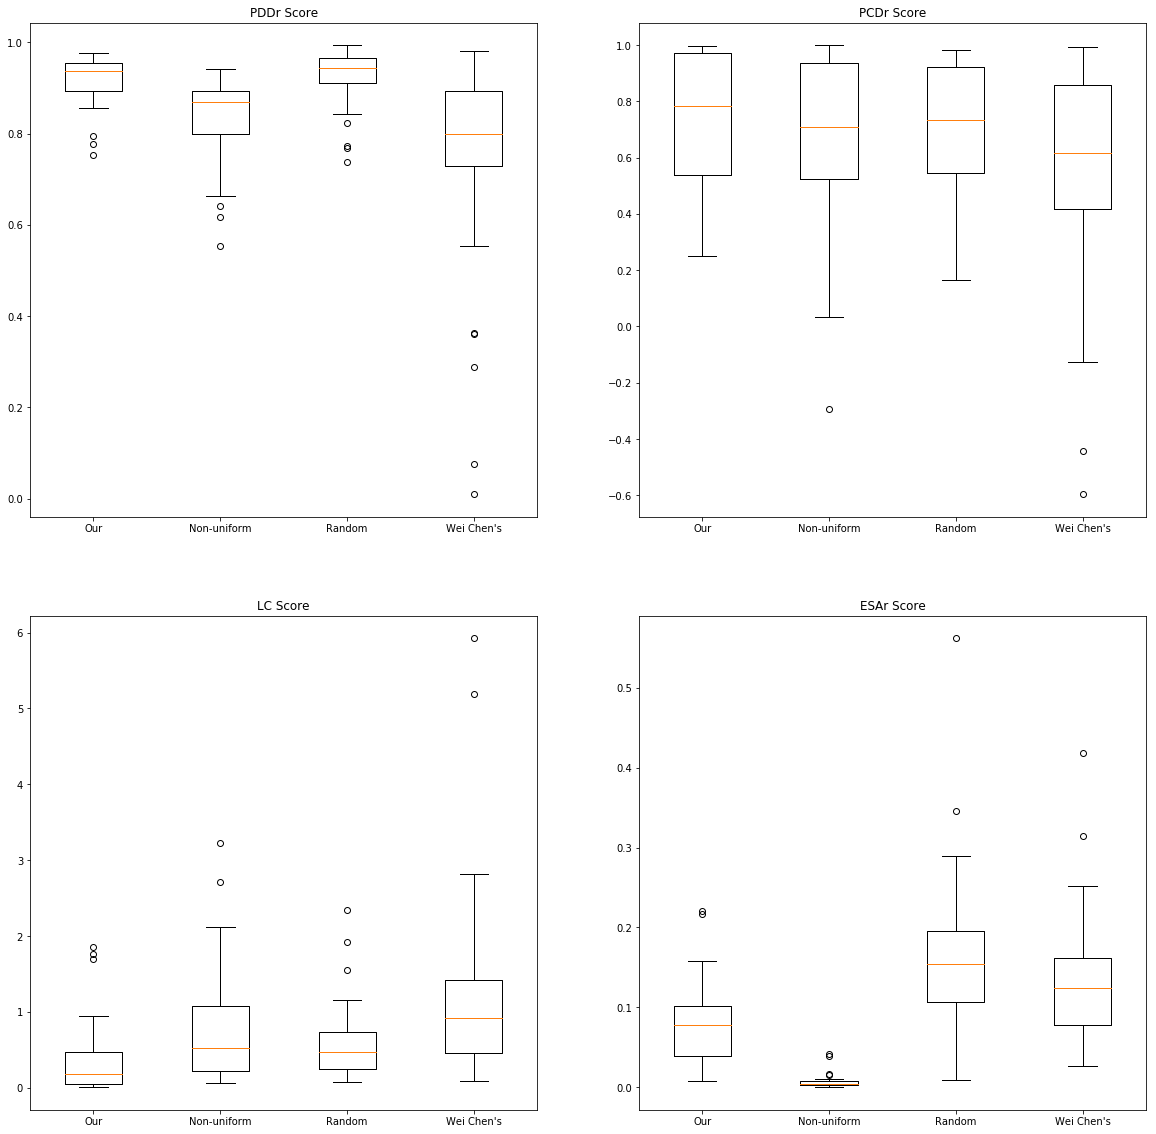

In [55]:
plt.figure(figsize=(20,20))
ax1 = plt.subplot(221)
ax1.set_title('PDDr Score')
a = np.append(pddr_list, pddr_list2, axis=0)
#a2 = np.delete(a, [21, 23], 0)
ax1.boxplot(a)
ax1.set_xticklabels(method_name)
ax2 = plt.subplot(222)
ax2.set_title('PCDr Score')
a = np.append(pcdr_list, pcdr_list2, axis=0)
#a2 = np.delete(a, [21, 23], 0)
ax2.boxplot(a)
ax2.set_xticklabels(method_name)
ax3 = plt.subplot(223)
ax3.set_title('LC Score')
a = np.append(lc_list, lc_list2, axis=0)
#a2 = np.delete(a, [21, 23], 0)
ax3.boxplot(a)
ax3.set_xticklabels(method_name)
ax4 = plt.subplot(224)
ax4.set_title('ESAr Score')
a = np.append(esar_list, esar_list2, axis=0)
#a2 = np.delete(a, [21, 23], 0)
ax4.boxplot(a)
ax4.set_xticklabels(method_name)
plt.savefig('Scores.pdf')
plt.show()

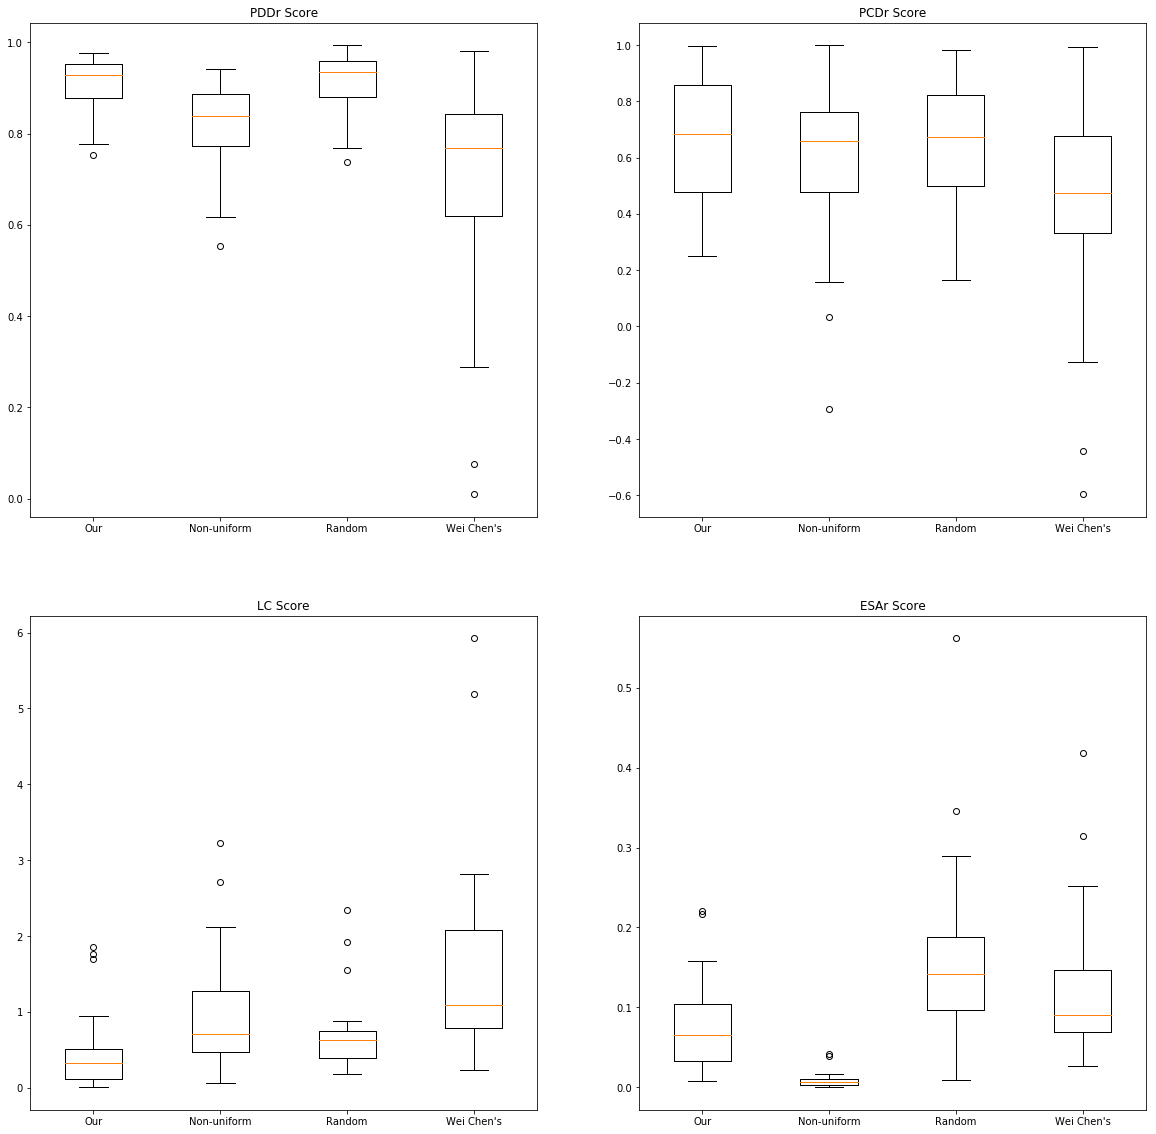

In [56]:
plt.figure(figsize=(20,20))
ax1 = plt.subplot(221)
ax1.set_title('PDDr Score')
a = np.array(pddr_list)
#a2 = np.delete(a, [21, 23], 0)
ax1.boxplot(a)
ax1.set_xticklabels(method_name)
ax2 = plt.subplot(222)
ax2.set_title('PCDr Score')
a = np.array(pcdr_list)
#a2 = np.delete(a, [21, 23], 0)
ax2.boxplot(a)
ax2.set_xticklabels(method_name)
ax3 = plt.subplot(223)
ax3.set_title('LC Score')
a = np.array(lc_list)
#a2 = np.delete(a, [21, 23], 0)
ax3.boxplot(a)
ax3.set_xticklabels(method_name)
ax4 = plt.subplot(224)
ax4.set_title('ESAr Score')
a = np.array(esar_list)
#a2 = np.delete(a, [21, 23], 0)
ax4.boxplot(a)
ax4.set_xticklabels(method_name)
plt.savefig('Real scores.pdf')
plt.show()

In [80]:
np.array(pcdr_list)

array([[ 0.78335362,  0.69734802,  0.78976341,  0.74871155],
       [ 0.53758678,  0.50335169,  0.41908068,  0.47558056],
       [ 0.99648885,  0.99969804,  0.98210718,  0.99112381],
       [ 0.62632228,  0.52415374,  0.57351904,  0.49523977],
       [ 0.52937895,  0.52919401,  0.6540048 ,  0.68139668],
       [ 0.90040189,  0.9601598 ,  0.89775609,  0.67010669],
       [ 0.92908359,  0.92180383,  0.8917829 ,  0.86795941],
       [ 0.3859222 ,  0.41755918,  0.45694184,  0.2886067 ],
       [ 0.6601424 ,  0.76591107,  0.71486486,  0.64777681],
       [ 0.8192443 ,  0.78042601,  0.77965822,  0.43855408],
       [ 0.48432701,  0.45268177,  0.667384  ,  0.41713274],
       [ 0.97185187,  0.98367489,  0.94182008,  0.73185134],
       [ 0.25074968,  0.24773404,  0.47457104, -0.59695228],
       [ 0.68470093,  0.71611135,  0.85364551,  0.45405122],
       [ 0.71599066,  0.6586142 ,  0.73457819,  0.42117639],
       [ 0.9881663 ,  0.91522026,  0.9231881 ,  0.85156257],
       [ 0.46767249,  0.

In [93]:
del pddr_list[23]
del pcdr_list[23]
del lc_list[23]
del esar_list[23]

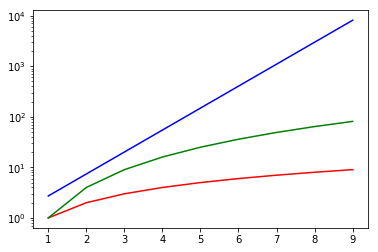

In [5]:
x = np.arange(1, 10)
y0 = x
y1 = x**2
y2 = math.e**x

plt.plot(x, y0, 'r', x, y1, 'g', x, y2, 'b')
plt.yscale('log')

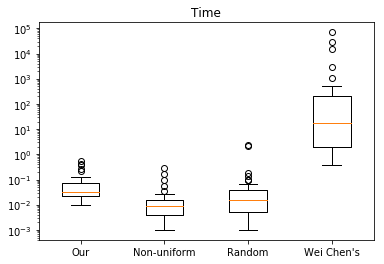

In [13]:
data = np.array([[0.015, 0.022, 0.018, 0.02, 0.012, 0.033, 0.04, 0.033, 0.02, 0.029, 0.011, 0.065, 0.028, 0.01, 0.07, 0.029, 0.028, 0.029, 0.027, 0.025, 0.041, 0.01, 0.019, 0.063, 0.048, 0.038, 0.056, 0.087, 0.213, 0.107, 0.093, 0.045, 0.125, 0.268, 0.424, 0.391, 0.545],
                [0.001, 0.002, 0.001, 0.003, 0.001, 0.005, 0.007, 0.008, 0.003, 0.003, 0.003, 0.004, 0.005, 0.003, 0.015, 0.008, 0.009, 0.01, 0.008, 0.009, 0.009, 0.013, 0.009, 0.016, 0.015, 0.01, 0.013, 0.015, 0.036, 0.026, 0.02, 0.017, 0.027, 0.057, 0.292, 0.092, 0.168,],
                [0.001, 0.001, 0.001, 0.001, 0.001, 0.005, 0.005, 0.005, 0.002, 0.004, 0.002, 0.008, 0.005, 0.002, 0.024, 0.01, 0.016, 0.015, 0.013, 0.016, 0.021, 0.005, 0.011, 0.031, 0.029, 0.025, 0.039, 0.069, 0.137, 0.096, 0.056, 0.022, 0.093, 0.094, 0.174, 2.255, 2.161,],
                [0.363, 0.638, 0.607, 0.605, 0.928, 1.387, 1.889, 1.484, 1.962, 1.88, 1.88, 2.475, 2.097, 3.007, 13.272, 13.268, 16.567, 18.864, 14.698, 17.016, 20.19, 23.071, 25.404, 29.294, 28.244, 42.951, 62.953, 201.052, 266.686, 281.823, 364.741, 494.472, 1032.12, 3013.13, 15302, 27909.2, 69930]])

fig, ax = plt.subplots()
plt.yscale('log')
ax.set_title('Time')
ax.boxplot(data.T)
ax.set_xticklabels(method_name)
plt.savefig('Time.pdf')

In [30]:
df = pd.read_csv('./data/iris.csv', header=None)

In [42]:
l = [0.015, 0.022, 0.018, 0.02, 0.012, 0.033, 0.04, 0.033, 0.02, 0.029, 0.011, 0.065, 0.028, 0.01, 0.07, 0.029, 0.028, 0.029, 0.027, 0.025, 0.041, 0.01, 0.019, 0.063, 0.048, 0.038, 0.056, 0.087, 0.213, 0.107, 0.093, 0.045]

sum(l)/len(l)

0.04325000000000001